In [1]:
import numpy as np
from skimage import data, io
from skimage.filters import threshold_otsu
import os
import imageio
from matplotlib import pyplot as plt
import pandas as pd
import napari
import tifffile
from threadpoolctl import threadpool_limits
from scipy import spatial
from sklearn.preprocessing import normalize
import zarr
# import warnings
# warnings.filterwarnings('ignore')

import pydeform.sitk_api as pydeform

In [2]:
import importlib
from virtualRG import trace
#importlib.reload(trace)

import itertools

In [3]:
import ray
# num_cpus=48
# ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

In [4]:
# For interpolation
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

# For seeding
from skimage.filters import gaussian
from scipy import ndimage as ndi
from skimage import measure
from skimage.transform import resize
from skimage.morphology import binary_closing, binary_dilation, dilation, binary_erosion
from skimage.morphology import ball

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# For ODE
from scipy.integrate import solve_ivp

import pandas as pd
# Study curve https://www.cse.usf.edu/~r1k/MachineVisionBook/MachineVision.files/MachineVision_Chapter13.pdf
from sklearn_extra.cluster import KMedoids
from sklearn import manifold
import ants
from scipy import interpolate
import SimpleITK as sitk

from scipy.ndimage import map_coordinates

from tqdm import tqdm
# import importlib
# import sys
# SCRIPT_DIR = '/home/tmurakami/src/virtualRG/virtualRG'
# sys.path.append(os.path.dirname(SCRIPT_DIR))
# import virtualRG
# from virtualRG import trace
# #importlib.reload(trace)


In [5]:
from vispy import color
from vispy.color import Colormap
turbo_list = [[0.0,0.0,0.0],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
turbo_dark = Colormap(turbo_list)

In [6]:
io_directory = '/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis'

In [7]:
%%time
asma_downscale = np.load(os.path.join(io_directory,'vessel.npy'))
dim = asma_downscale.ndim

# make mask using binary vessel
asma_downscale_mask = np.load(os.path.join(io_directory,'binary_final.npy'))

# Begin from ball(5). 8 may take a couple of minutes.
asma_downscale_mask = binary_dilation(asma_downscale_mask,footprint=ball(4)) # ball size to be a parameter. This process is because filling of ClearMap sometime fails.

CPU times: user 42.6 s, sys: 229 ms, total: 42.8 s
Wall time: 43.4 s


In [7]:
# viewer = napari.Viewer()
# viewer.add_image(asma_downscale_mask, contrast_limits=[0,1], rgb=False, name='mask', colormap='cyan', blending='additive', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,2000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False)

## vector field interpolation

In [8]:
def polynomial_eq(w, coeff, ij_powers):
    x0, x1, x2 = w
    return sum((b * (x0**ij_powers[i,0]) * (x1**ij_powers[i,1]) * (x2**ij_powers[i,2]) for i, b in enumerate(coeff)))

In [9]:
def vectorfield(t, w, coeff, ij_powers):
    '''
    Arguments: 
        w : vector of the coordinate
        t : time
        p : vector of the parameters
        ij_powers: matrix to compose polynomial function
    '''
    x0, x1, x2 = w
    # Create f = (x0', x1', x2')
    f = [
        polynomial_eq(w,list(coeff[0]),ij_powers),
        polynomial_eq(w,list(coeff[1]),ij_powers),
        polynomial_eq(w,list(coeff[2]),ij_powers)
    ]
    return f

In [10]:
def fill_value_in_range(array, index_array, value=255.):
    '''
    The function fill the value in a given array using indexing array. 
    The indexing array can have the index outside of the given array. The position indicated by index array is filled with the value.
    The outside index will be disregarded. 
    array: numpy array to be filled with value.
    index_array: numpy array for indexing. Each column has the position of the array to be filled.
    value: value to be filled. int or numpy array with the size of column number in index_array.
    '''
    dim = array.ndim
    # Select indices within the range of the array.
    column_to_select = np.all(
        [np.all([index_array[i,:] >= 0 for i in range(dim)], axis=0), np.all([index_array[i,:] < (array.shape[i] - 0.5) for i in range(dim)], axis=0)],
        axis=0
    )
    select_idx = index_array[:,column_to_select]
    select_idx = np.around(select_idx).astype(int)
    
    # Fill the value in the array.
    if isinstance(value,np.ndarray):
        array[tuple([select_idx[i,:] for i in range(dim)])] = value[column_to_select]
    else:
        array[tuple([select_idx[i,:] for i in range(dim)])] = value
    return array

In [11]:
# load values from the previous notebook
extract_idx = np.load(os.path.join(io_directory,'extract_idx.npy'))
keeping = np.load(os.path.join(io_directory,'keeping.npy'))
point_vectors = np.load(os.path.join(io_directory,'point_vectors.npy'))

In [12]:
# Fit to the nth polynomial
degree = 5
idx = np.array(np.unravel_index(extract_idx,asma_downscale.shape)).T
vec = point_vectors[keeping,:]
poly = PolynomialFeatures(degree=degree) # Overfitting may happen at the edge?
idx_ = poly.fit_transform(idx)

clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(idx_,vec)# Fit the model

LinearRegression(fit_intercept=False)

In [12]:
# Export the vector field as image if it is required.
if False: # honestly, the interpretation is difficult and does not help much.
    all_coord = np.indices(asma_downscale.shape)
    all_coord = np.stack([all_coord[i,:,:,:].flatten() for i in range(dim)], axis=1).astype(int)
    all_coord_ = poly.fit_transform(all_coord)

    fit_img = clf.predict(all_coord_)
    fit_img = fit_img.reshape(asma_downscale.shape+(dim,))
    vector_field_tif = os.path.join(io_directory,'vector_field_interpolation.tif')

    # export extracted vetors as image
    tifffile.imwrite(vector_field_tif,
             np.moveaxis(fit_img,-1,1).astype(np.float32),
             imagej=True,
             metadata={'spacing': 10, 'unit': 'um', 'axes': 'ZCYX'})
    del(all_coord)
    del(all_coord_)
    del(fit_img)

## seeding and extension

In [13]:
# load autofluorescence/nuclei for segmentation
autofl_zarr = zarr.open('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/ch488_10um.zarr',mode='r')
autofl = autofl_zarr['0'][:]
voxel_size = [10, 10, 10]
# reshape_size = [autofl.shape[0], round((autofl.shape[1]/3) * 1.3),round((autofl.shape[2]/3) * 1.3)]
# autofl = resize(autofl, reshape_size, preserve_range=True)

In [14]:
%%time
# To avoid the impact of artery for the layer alignment, give a vessel mask onto nuclei.
autofl_masked = autofl * (1-asma_downscale_mask)

# Do interpolation against masked potions. Nearest neighbor is used for the speed.
# Interpolation may take a couple of minutes.
autofl_filled = np.copy(autofl_masked)
nonzero_coord = np.argwhere(asma_downscale_mask==0)
zero_coord = np.argwhere(asma_downscale_mask==1)
val = interpolate.griddata(nonzero_coord,autofl_masked[tuple(nonzero_coord.T)],xi=zero_coord,method='nearest') # nearest extrapolates while linear not.
autofl_filled[tuple(zero_coord.T)] = val

CPU times: user 1min 48s, sys: 3.56 s, total: 1min 51s
Wall time: 1min 51s


In [15]:
# viewer = napari.Viewer()
# viewer.add_image(autofl_filled, contrast_limits=[0,2000], rgb=False, name='masked', colormap='magenta', blending='additive', multiscale=False)
# viewer.add_image(autofl, contrast_limits=[0,2000], rgb=False, name='auto', colormap='green', blending='additive', multiscale=False)

In [16]:
%%time
# Segmentation of the image
# autofl_gauss = gaussian(autofl,sigma=10,mode='nearest',preserve_range=True)
autofl_gauss = gaussian(autofl_filled,sigma=10,mode='nearest',preserve_range=True)
background_val = 300
segmented_tissue = (autofl_gauss>background_val)

CPU times: user 18.7 s, sys: 588 ms, total: 19.3 s
Wall time: 19.3 s


In [467]:
viewer = napari.Viewer()
viewer.add_image(segmented_tissue, contrast_limits=[0,2], rgb=False, name='mask', colormap='magenta', blending='additive', multiscale=False)
viewer.add_image(autofl, contrast_limits=[0,2000], rgb=False, name='auto', colormap='green', blending='additive', multiscale=False)
viewer.add_image(autofl_gauss, contrast_limits=[0,2000], rgb=False, name='auto_blur', colormap='cyan', blending='additive', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,2000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False)

<Image layer 'asma' at 0x7f39cab66f40>

In [17]:
def extract_largest_object_from_binary(binary_img):
    """
    input
        binary_img: ndarray. binarized image.
    return
        object_img: ndarray. binarized image of the largest object
    """
    # Find object and select the largest object.
    label_objects, nb_labels = ndi.label(binary_img, structure=np.ones((3,3,3)))
    sizes = np.bincount(label_objects.ravel()) 
    sizes[0] = 0 #To remove index=0. because it is background.
    object_img = (label_objects==np.argmax(sizes)).astype(float) # Get the largest objects. Making it a mask.
    
    return object_img

In [18]:
def extract_largest_cluster(coord):
    """
    input
        coord: 2d array. coordinate in column.
    return
        index_array: index of points in the major cluster.
    """
    
    coord = coord.T.astype(int)
    binary_array = np.zeros(coord.max(axis=1)+1)
    binary_array[tuple(coord)] = 1
    
    largest_object = extract_largest_object_from_binary(binary_array)
    selected_coord = np.transpose(largest_object.nonzero()) # Get the largest objects. Extract index. Transpose to original orientation.

    return selected_coord

In [19]:
def flow_on_coordinate(coord, degree, clf):
    poly = PolynomialFeatures(degree=degree)
    coord_ = poly.fit_transform(coord)
    flow_on_coord = normalize(clf.predict(coord_),axis=1)
    
    return flow_on_coord

In [20]:
def get_flow_on_coordinate_func(degree, clf):
    def get_flow(coord):
        poly = PolynomialFeatures(degree=degree)
        coord_ = poly.fit_transform(coord)
        flow_on_coord = normalize(clf.predict(coord_),axis=1)
        return flow_on_coord
    return get_flow

In [21]:
def get_gradient_func(coeff, ij_powers):
    grad_coeff =  np.asarray([ij_powers[:,i] * coeff for i in range(3)])
    def a(w):
        element = []
        for i in range(3):
            powers = ij_powers.copy()
            diff = powers[:,i]-1
            powers[:,i] = diff
            powers[powers<0] = 0  # to avoid an error
            element.append(polynomial_eq(w,list(grad_coeff[i]),powers))
        return np.asarray(element)
    return a 

In [24]:
# the better algorithm is HDBSCAN. This makes more sense to me in this case.
def seed_selection(seeds, normals, flow_on_seeds, n_clusters=6, cluster_selection='min'):
    """
    Select the seeds on the surface of interest. 
    """
    # Calculate dot product of normal vector and flows
    seeds_dot_product = np.sum(normals*flow_on_seeds, axis=1) # This will return the dot product.

    # Start clusterings
    features = np.concatenate((seeds,normals,seeds_dot_product[...,np.newaxis]),axis=1) # Make feature matrix, xyz coordinates + normal vectors + dot products
    scaler = StandardScaler().fit(features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scaler.transform(features)) # Clustering 

    # Extract seeds in the cluster of interest.
    if cluster_selection=='min':
        cluster_of_interest = np.argmin(kmeans.cluster_centers_[:,-1]) # Minimum in this case. Could be maximum depending on the orientation of the tissue or guide vector.
    elif cluster_selection=='max':
        cluster_of_interest = np.argmax(kmeans.cluster_centers_[:,-1])
    else:
        print("error")
        return None
    return (kmeans.labels_==cluster_of_interest)

In [25]:
# read cellular coordinate
cells_info = pd.read_csv('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/coord_centroids.csv',index_col=0) # the unit is original voxel.
scaling_factor = np.asarray([3,0.65,0.65])
cell_coords = cells_info.loc[:,['centroid-0','centroid-1','centroid-2']] * scaling_factor / 10# convert unit to 10 um for consistency
cell_coords = cell_coords.to_numpy()

# make kdTree of the nuclei
coords_tree = spatial.KDTree(cell_coords)

In [26]:
%%time
### selection of the outer most cells.
import alphashape
import networkx as nx

# convex hull is not successful. Try alpha shape instead.
# 750,000 takes ~7 min.
downsample = 10
alpha = alphashape.alphashape(cell_coords[::downsample,:], 0.1)

# use network to select the largest point clouds
groups = nx.connected_components(alpha.vertex_adjacency_graph)
groups = list(groups)
# select the largest point clouds
idx = groups[np.asarray([len(c) for c in groups]).argmax()]
ver = np.asarray(alpha.vertices[tuple(idx),:])
nor = np.asarray(alpha.vertex_normals[tuple(idx),:])

# check the selected vertices
viewer = napari.Viewer()
points = viewer.add_points(
    ver,
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)

Validation errors in config file(s).
The following fields have been reset to the default value:

schema_version
  value is not a valid tuple (type=type_error.tuple)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



CPU times: user 7min 18s, sys: 10.2 s, total: 7min 28s
Wall time: 7min 19s


In [24]:
flow_on_coordinate = get_flow_on_coordinate_func(degree, clf)

In [25]:
selection = seed_selection(ver, nor, flow_on_coordinate(ver), n_clusters=3)
viewer = napari.Viewer()
points = viewer.add_points(
    ver[selection],
    size=2,#oblique_size/5,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)

seeds_df = pd.DataFrame(ver[selection], columns=['x0','x1','x2'])

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [19]:
marching_cube = False

if marching_cube:
    # Extract surface by marching cube.
    marching_step_size = 1
    seeds, faces, normals, values = measure.marching_cubes(
        extract_largest_object_from_binary(segmented_tissue), # Find object and select the largest object.
        level=0, # Adjust the space using step_size, not the level.
        step_size=marching_step_size, # Make mesh on the edge. step_size determines the coarseness of the mesh. 10 means 10 voxel intervals.
        allow_degenerate=False # To prevent duplicated vertices.
    )

    # Create selection data frame through clustering. 
    selection = seed_selection(seeds, normals, flow_on_coordinate(seeds), n_clusters=3)
    # Exclude the vertices which are not continuous to the largest cluster.
    comp_coord = (seeds[selection] / marching_step_size).astype(int)
    # Select the largest connected cluster.|
    seeds_df = pd.DataFrame(extract_largest_cluster(comp_coord).astype(int), columns=['x0','x1','x2'])


In [26]:
# # Export vertices as image if necessary.
# if False:
#     kmeans_verts = np.zeros_like(asma_downscale)
#     # verts_to_export = (seeds_df.to_numpy()).astype(np.uint16)
#     verts_to_export = (comp_coord).astype(np.uint16)
#     kmeans_verts[verts_to_export[:,0],verts_to_export[:,1],verts_to_export[:,2]] = 255
#     imageio.mimwrite(os.path.join(io_directory,'kmeans_verts.tif'),kmeans_verts)

In [25]:
'''Solving ODE numerically'''

'Solving ODE numerically'

In [27]:
seed_choice = seeds_df.index.tolist()

In [28]:
def initialize_virtual_rg(seed_num, seed, model, model_parameters):
    """
    """
    virtual_rg = trace.VirtualRG(seed,vectorfield)
    virtual_rg.set_seed_number(seed_num)
    virtual_rg.set_model_parameters(*model_parameters)
    return virtual_rg

In [29]:
@ray.remote
def solve_ode(virtual_rg, time_start, time_end):
    # SCRIPT_DIR = '/home/tmurakami/src/virtualRG/virtualRG'
    # sys.path.append(os.path.dirname(SCRIPT_DIR))
    # import virtualRG
    # from virtualRG import trace

    virtual_rg.solve_ode(time_start, time_end)
    
    return virtual_rg

In [30]:
# Initialize virutal radial glial fibers
virtual_rgs = {}
model_parameters = (clf.coef_,poly.powers_)
for seed_num in seed_choice:
    seed_position = seeds_df.iloc[seed_num,:].tolist()
    virtual_rg = initialize_virtual_rg(seed_num, seed_position, vectorfield, model_parameters)
    virtual_rgs[seed_num] = virtual_rg

In [31]:
%%time
time_start = 0
time_end = 500
ode_results = []
for seed_num in seed_choice:
    ode_results.append(solve_ode.remote(virtual_rgs[seed_num], time_start, time_end))
ode_results = ray.get(ode_results)

(pid=426742) /tmp/ipykernel_425507/915462932.py:3: RuntimeWarning: overflow encountered in double_scalars
(pid=426742) /tmp/ipykernel_425507/915462932.py:3: RuntimeWarning: invalid value encountered in double_scalars
(pid=426739) /tmp/ipykernel_425507/915462932.py:3: RuntimeWarning: overflow encountered in double_scalars
(pid=426739) /tmp/ipykernel_425507/915462932.py:3: RuntimeWarning: invalid value encountered in double_scalars
(pid=426743) /tmp/ipykernel_425507/915462932.py:3: RuntimeWarning: overflow encountered in double_scalars
(pid=426743) /tmp/ipykernel_425507/915462932.py:3: RuntimeWarning: invalid value encountered in double_scalars
(pid=426803) /tmp/ipykernel_425507/915462932.py:3: RuntimeWarning: overflow encountered in double_scalars
(pid=426803) /tmp/ipykernel_425507/915462932.py:3: RuntimeWarning: invalid value encountered in double_scalars
(pid=426749) /tmp/ipykernel_425507/915462932.py:3: RuntimeWarning: overflow encountered in double_scalars
(pid=426749) /tmp/ipykerne

CPU times: user 7.79 s, sys: 1.26 s, total: 9.05 s
Wall time: 15.3 s


In [32]:
%%time
import copy
virtual_rgs = {}
for virtual_rg in ode_results:
    virtual_rg = copy.deepcopy(virtual_rg)
    virtual_rg.fetch_value(autofl_gauss, segmented_tissue)
    virtual_rgs[virtual_rg.seed_number] = virtual_rg

CPU times: user 2.84 s, sys: 76.6 ms, total: 2.91 s
Wall time: 2.87 s


In [1719]:
# Export image if necessary
from vispy.color import Colormap
label_r = Colormap([[1.0, 1.0, 1.0, 0.0], [1.0, 0.0, 0.0, 1.0]])
label_g = Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 1.0, 0.0, 1.0]])
label_b = Colormap([[1.0, 1.0, 1.0, 0.0], [0.0, 0.0, 1.0, 1.0]])
palette = [label_r,label_g,label_b]
directions = ['red','green','blue']
if True:
    flow_img = np.zeros(asma_downscale.shape+(3,))
    for seed_num in seed_choice[::5]:
        virtual_rg = virtual_rgs[seed_num]
        position = virtual_rg.trajectory.ode_solution.y
        for i in range(3):
            flow_vector = abs(flow_on_coordinate(position.T)[:,i])
            flow_img[...,i] = fill_value_in_range(flow_img[...,i],position,flow_vector)
    for i in range(3):
        flow_img[...,i] = flow_img[...,i]*segmented_tissue
    viewer = napari.Viewer()
    viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='sma', colormap='gray', blending='additive') # [100:250,...]
    for i in range(3):
        viewer.add_image(flow_img[...,i], contrast_limits=[0,1], rgb=False, name=directions[i], colormap=palette[i], blending='translucent')
    # viewer.add_image(flow_img, rgb=True, name='flow', blending='additive')
    viewer.add_image(segmented_tissue, contrast_limits=[0,2], rgb=False, name='mask', colormap='cyan', blending='additive', multiscale=False, visible=False)

In [1718]:
# ray.shutdown()

In [33]:
seeds_df['sel3'] = False # ODE was solved 
seeds_df['sel4'] = False # Trajectory is continuous
seeds_df['sel5'] = False # Trajectory is long enough for alignment analysis.
min_length = 200 # minimum 3
for seed_num in seed_choice:
    virtual_rg = virtual_rgs[seed_num]
    if virtual_rg.trajectory.ode_solution.success:
        seeds_df.loc[seed_num,'sel3'] = True
    if virtual_rg.trajectory.continuity:
        seeds_df.loc[seed_num,'sel4'] = True
    if virtual_rg.trajectory.inloc.sum() > min_length:
        seeds_df.loc[seed_num,'sel5'] = True

In [34]:
def generate_duplication_table(df):
    """
    Get the correspondance table which to which is duplicated.
    """
    # Make a table for without duplication.
    no_duplication = pd.Series(df[~df.duplicated(keep=False)].index,index=df[~df.duplicated(keep=False)].index)
    # Make a table for with duplication
    df.index.names = ['index']
    grouped = df[df.duplicated(keep=False)].reset_index().groupby(by=df.columns.tolist())
    duplicated_df = grouped['index'].unique().reset_index()

    duplicated_correspondance = {}
    for duplicated_combination in duplicated_df['index'].tolist():
        duplicated_combination = duplicated_combination.tolist()
        for point in duplicated_combination:
            duplicated_correspondance[point] = duplicated_combination[0]
    duplicated_correspondance = pd.Series(duplicated_correspondance)#pd.DataFrame.from_dict(duplicated_correspondance, orient='index')
    
    # Combine the table for with/without duplication
    duplicated_correspondance = pd.concat([no_duplication,duplicated_correspondance]).sort_index()
    
    return duplicated_correspondance

In [35]:
def isin_thickness(half_thickness, position, flow, neighbors):
    cond1 = np.dot(neighbors-(position+flow*half_thickness),flow)<0
    cond2 = np.dot(neighbors-(position-flow*half_thickness),flow)>0
    
    return neighbors[(cond1*cond2)], cond1*cond2

In [36]:
def conv_along_line(half_thickness, positions, flow, coords_tree, radius=20, size=None):
    # get coordinates
    coords = coords_tree.data
    # get index of the neighbors. idx is an array of lists. 
    indices = coords_tree.query_ball_point(positions, r=radius)
    
    coords_in_thickness = []
    column_sum = []
    idx_in_thickness = []
    
    # convert index to the xyz coordinate. to each array element (i.e. list), convert to coord.
    for i, idx in enumerate(indices.tolist()):
        neighbor_coords = coords[idx,:]
        in_thickness, subidx = isin_thickness(half_thickness, positions[i,:],flow[i,:], neighbor_coords)# [0].size
        coords_in_thickness.append(in_thickness)
        column_sum.append(in_thickness.size)
        idx_in_thickness.append(np.asarray(idx)[subidx])
    
    column_sum = np.asarray(column_sum)
    if size is not None:
        column_sum = np.pad(column_sum, (0, size-column_sum.size), 'constant', constant_values=(0, 0)) # pad to the size
    
    return column_sum, idx_in_thickness, coords_in_thickness

In [37]:
def get_unique_number(list_of_array):
    if len(list_of_array) == 0:
        sequence = np.empty(0, dtype=np.int64)
    else:
        sequence = np.concatenate(list_of_array, axis=0)
        sequence = sequence.astype(np.int64)
    unique_number = np.unique(sequence)
    return unique_number

In [ ]:
# def detect_along_line(half_thickness, positions, flow, coords_tree, radius=20, size=time_end+1):
#     # get coordinates
#     coords = coords_tree.data
#     # get index of the neighbors.
#     idx = coords_tree.query_ball_point(positions, r=radius)
#     # convert index to the xyz coordinate. to each array element (i.e. list), convert to coord.
#     neighbor_along_line = [coords[i,:] for i in idx]
#     # count the number of cells in a disk along the line
    
#     in_thickness 
#     column_convolution, subidx = np.asarray([isin_thickness(half_thickness, positions[i,:],flow[i,:],neighbor_along_line[i]).size for i in range(len(neighbor_along_line))])
#     column_convolution = np.pad(column_convolution, (0, size-column_convolution.size), 'constant', constant_values=(0, 0)) # pad to the size
    
#     return column_convolution

In [38]:
def grid_pos_in_circle(radius, sigma=5.0):
    """ 
    sigma controls the number of the point
    radius controls the size
    """
    positions = []

    X = int(sigma)
    for i in range(-X, X + 1):
        Y = int(pow(sigma * sigma - i * i, 1/2))
        for j in range(-Y, Y + 1):
            positions.append((i, j))
    grid_in_circle = np.asarray(positions)
    grid_in_circle = grid_in_circle * radius / sigma

    return grid_in_circle

In [39]:
def grid_pos_in_circle_3d(radius, sigma=5.0, zero_axis=0):
    positions = grid_pos_in_circle(radius, sigma=sigma)
    return np.asarray(np.insert(positions,[zero_axis],np.zeros(positions.shape[0])[:,np.newaxis], axis=1))

In [40]:
def position_on_circunference(radius, n_points=8, dim=3):
    """ 
    n_points control the number of the points on circunference.
    """
    theta = np.arange(0, 2*np.pi, 2*np.pi/n_points)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)

    position = np.stack((y, x))
    if dim == 3:
        position = np.vstack((np.zeros_like(x),position))
    
    return position.T

In [41]:
def get_orthonogals(k,x=np.asarray([0.0,1.0,0.0])):
    """
    k: 2darray. nx3 
    Assume input vector k to be normalized
    """
    x = x - k.dot(x)[:,None] * k       # make x orthogonal to k
    x = x / np.linalg.norm(x,axis=1)[:,None]  # normalize it

    y = np.cross(k, x)
    
    return k, x, y

In [42]:
def rotate_with_normals(coord, vectors):
    """
    rotate agianst normal. (0,0,0) is used as the origin of the rotation
        coord: 2darray. ix3. coordinates to be rotated. 
        vectors: 2darray. jx3. j is a number of the normal vectors. 
    return
        points: 3darray. ixjx3. rotated position of coordinates for each normal vector.  
    """
    M = get_orthonogals(vectors)

    points = np.einsum('ij,jkl->ikl', coord, np.asarray(M)) # [measurement point, position in line, xyz coordinate]
    #points = np.moveaxis(points,1,0)

    return points

In [43]:
def get_gradient_func(coeff, ij_powers):
    grad_coeff =  np.asarray([ij_powers[:,i] * coeff for i in range(3)])
    def a(w):
        element = []
        for i in range(3):
            powers = ij_powers.copy()
            diff = powers[:,i]-1
            powers[:,i] = diff
            powers[powers<0] = 0  # to avoid an error
            element.append(polynomial_eq(w,list(grad_coeff[i]),powers))
        return np.asarray(element)
    return a 

In [44]:
def get_divergence_func(coeffs, ij_powers):
    """
    coeffs: coefficients of the polynomial for each element of a vector
    """
    div_coeffs = np.asarray([ij_powers[:,i] * coeffs[i,:] for i in range(3)])
    def a(w):
        div = 0
        for i in range(3):
            powers = ij_powers.copy()
            powers[:,i] = powers[:,i] - 1 
            powers[powers<0] = 0 # to avoid an error
            div += polynomial_eq(w.T, div_coeffs[i,:], powers)
        return div
    return a

In [45]:
from sklearn.metrics import mutual_info_score

#https://stackoverflow.com/questions/20491028/optimal-way-to-compute-pairwise-mutual-information-using-numpy
def mutual_information(s1, s2, bins=10):
    """
    """
    hist = np.histogram2d(s1, s2, bins)[0]
    mi = mutual_info_score(None,None,contingency=hist)
    return mi

In [465]:
def make_displacement_map(position_arr):
    coords = np.meshgrid(*[range(x) for x in position_arr.shape], indexing='ij')
    coords = np.array(coords).astype(np.int16)
    coords[0,:,:] = position_arr
    
    return coords

In [ ]:
'''count the cells in the kernel along fiber'''

In [47]:
seed_choice = seeds_df.index[seeds_df.iloc[:,4:].all(axis=1)].to_list()

# convolve the cell count along the growthline.
# prepare column cell number convolution
half_thickness = 2.5 # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer
downsample = 1 # downsample if necessary. if not, 1

# column cell number convolution
seed_choice = seed_choice[::downsample]
column_conv_np_ = np.zeros((time_end+1, len(seed_choice)))
for i, seed_num in tqdm(list(enumerate(seed_choice))):
    virtual_rg = virtual_rgs[seed_num]

    # get position of a line as 1D array.
    positions = virtual_rg.trajectory.ode_solution.y.T
    # get flow on the postion
    flow = flow_on_coordinate(positions) # flow is normalized
    
    # count the number of cells in a disk along the line
    column_conv_np_[:,i], _, _ = conv_along_line(half_thickness, positions, flow, coords_tree, radius, time_end+1)
    
column_conv = pd.DataFrame(column_conv_np_.T,index=seed_choice)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [06:50<00:00, 16.32it/s]


In [ ]:
'''The scripts below is extremely ugly. '''
'''manihold 2D & 1D'''

In [322]:
%%time
# do 2D isomap
X0 = seeds_df.iloc[:,0:3]
# X0_sampled = X0.sample(frac=1, replace=False, random_state=1) # downsample for faster computation
iso = manifold.Isomap(n_neighbors=20, n_components=2, n_jobs=-1)
iso.fit(X0)
manifold_2D = iso.transform(X0)

translate_manifold2D = manifold_2D - manifold_2D.min(axis=0)[np.newaxis,:]
translate_manifold2D_df = pd.DataFrame(pd.DataFrame(translate_manifold2D,index=seeds_df.index),index=seeds_df.index)

CPU times: user 45.7 s, sys: 12.1 s, total: 57.8 s
Wall time: 37.4 s


In [610]:
# manually label the cells on surface using 2D plot

# https://napari.org/api/napari.view_layers.html#napari.view_layers.view_points
viewer = napari.Viewer()
points = viewer.add_points(
    translate_manifold2D,
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)
labels = viewer.add_labels(np.zeros(translate_manifold2D.max(axis=0).astype(int),int), name='label')

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [611]:
# Check the labeled positions in 3D

label_coords = np.asarray(np.nonzero(labels.data)).astype(int).T

# a bit of trick. use pandas to choose the points where they belong to the manual label.
elem = pd.DataFrame(translate_manifold2D.astype(int),index=seeds_df.index).reset_index().merge(pd.DataFrame(label_coords),how='inner',on=[0,1]).set_index('index')

cond1 = seeds_df.iloc[:,4:].all(axis=1)
cond2 = seeds_df.index.isin(elem.index)

# visualize the label in 3D
viewer = napari.Viewer()
points = viewer.add_points(
    seeds_df.iloc[:,0:3][cond1 * cond2],
    size=2,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)
viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='green', blending='additive', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7faeaa816130>

In [48]:
#seed_choice = seed_df[cond1*cond2].index.to_list()
seed_choice = np.load('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/selected_seed_num.npy')
seed_choice = seed_choice.tolist()

In [49]:
# reduce dimention to 1d for manual alignment
# X0_selected = seeds_df.iloc[:,0:3][cond1 * cond2]
X0_selected = seeds_df.iloc[:,0:3].loc[seed_choice,:]#[cond1 * cond2]
iso1d = manifold.Isomap(n_neighbors=20, n_components=1, n_jobs=-1) # change n_neighbors in case of error.
iso1d.fit(X0_selected)
manifold_1D = iso1d.transform(X0_selected)
manifold_1D_df = pd.DataFrame(manifold_1D,index=seed_choice)#seeds_df.iloc[:,0:3][cond1 * cond2].index)
# manifold_1D_df = manifold_1D_df.sort_values(0)

In [468]:
seed_choice = manifold_1D_df.sort_values(0).index.to_list()
# np.save(os.path.join(io_directory,'selected_seed_num.npy'), manifold_1D_df.sort_values(0).index.to_numpy())

In [53]:
# visualize the label in 3D with color

points_vis = seeds_df.iloc[:,0:3].reindex(seed_choice)
color_mapper = manifold_1D_df.sort_values(0).to_numpy()
color_vis = color.get_colormap('plasma').map((color_mapper-np.min(color_mapper)) / (np.max(color_mapper)-np.min(color_mapper)))

viewer = napari.Viewer()
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray_r', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
# viewer.theme = 'dark'

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3a53153fa0>

In [469]:
target = column_conv.reindex(seed_choice).to_numpy().T
viewer0 = napari.Viewer()
viewer0.add_image(target, rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)

<Image layer 'original' at 0x7f39c5b55c40>

In [470]:
std_idx = 596
std_seed = seed_choice[std_idx]# selected_manihold_1D.iloc[std_idx,:].name
std_values = target[:,std_idx]
standard = np.repeat(std_values[:,np.newaxis],len(seed_choice),axis=1)
viewer0.add_image(standard, rgb=False, name='std', colormap='gray', blending='additive', multiscale=False)
labels = viewer0.add_labels(np.zeros_like(standard.astype(int)), name='labeling')

In [471]:
# make initial displacement using manual labels.
# labels_np = labels.data
labels_np = np.load('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/layer_labels.npy')

initial_standard2target = np.zeros_like(standard)
initial_target2standard = np.zeros_like(standard)

std_landmark = np.array([0,22,33,108,126,266,standard.shape[0]]) # these are fixed numbers.
f = interpolate.interp1d(np.arange(std_values.size), std_values, bounds_error=False, fill_value='extrapolate') # f converts standard to target.

for line, seed_num in enumerate(seed_choice):
    # make landmarks_fix
    landmarks = std_landmark.copy()
    for i in range(1, std_landmark.size-1):
        positions = np.where(labels_np[:,line]==i)[0]
        if positions.size != 0:
            landmarks[i] = round(positions.mean())
        else:
            landmarks[i] = std_landmark[i]

    # make manually generated position shift
    coord = np.arange(labels_np.shape[0])
    pos_standard2target = interpolate.griddata(landmarks,std_landmark,xi=coord,method='linear')
    pos_target2standard = interpolate.griddata(std_landmark,landmarks,xi=coord,method='linear') # cubic distort the thing...
    initial_standard2target[:,line] = pos_standard2target
    initial_target2standard[:,line] = pos_target2standard
    
    values = column_conv.loc[seed_num,:].to_numpy()
    g = interpolate.interp1d(np.arange(values.size), values, bounds_error=False, fill_value='extrapolate') # g converts target to standard
    
    standard2target_shifted = f(pos_standard2target)
    target2standard_shifted = g(pos_target2standard) 


In [472]:
viewer2 = napari.Viewer()
initial_displaced_tar2std = map_coordinates(target, make_displacement_map(initial_target2standard), order=1, mode='constant') # transform fix for better interpretation.
initial_displaced_std2tar = map_coordinates(standard, make_displacement_map(initial_standard2target), order=1, mode='constant') # transform fix for better interpretation.
viewer2.add_image(initial_displaced_tar2std, rgb=False, name='manual_aligned', colormap='green', blending='additive', multiscale=False)
viewer2.add_image(initial_displaced_std2tar, rgb=False, name='manual_deformed', colormap='magenta', blending='additive', multiscale=False)
viewer2.add_image(standard, rgb=False, name='standard', colormap='gray', blending='additive', multiscale=False)

<Image layer 'standard' at 0x7f39cfc660d0>

In [473]:
# set parameters
settings = {
    'pyramid_levels':3, # larger number can deteriorate the initial alignment.
    'pyramid_stop_level': 0, # 1 is good. 2 is just enough, 3 is not enough. 
    # 'landmarks_weight': 1.0,
    # 'landmarks_stop_level': 0,
    'step_size': [1.0, 1.0, 1.0], # [1.0,1.0,1.0] seems enough. more than that will degrade the quality
    'block_size': [32,32,32],#[512,512,512],
    'block_energy_epsilon':1e-7,
    'max_iteration_count':100,
    'constraints_weight':1000.0,
    'regularization_weight': 0.25, # default 0.25
    'regularization_scale': 1.0, # default 1.0
    'regularization_exponent': 2.0, # default 2.0
    'image_slots':[{
            'resampler': 'gaussian',
            'normalize': True,
            'cost_function':[
                {
                    'function':'ncc',
                    'weight':1.0,
                    'radius':9
                }
            ]
        }]
}



In [474]:
def pydeform_wrapper(standard, target, target2standard, settings):
    displaced_tar2std = map_coordinates(target, make_displacement_map(target2standard), order=1, mode='constant') # transform fix for better interpretation.
    fix_itk = sitk.Cast(sitk.GetImageFromArray(displaced_tar2std[np.newaxis,:,:]),sitk.sitkFloat32) # itk convert numpy zyx to xyz
    mov_itk = sitk.Cast(sitk.GetImageFromArray(standard[np.newaxis,:,:]),sitk.sitkFloat32)
    
    df_sitk = pydeform.register(
        fix_itk,
        mov_itk,
        settings=settings,
        num_threads=60,
        use_gpu=True
    )

    displacement = sitk.GetArrayFromImage(df_sitk)[0,:,:,1] #pos = sitk.GetArrayFromImage(df_sitk)[:,0,0,2]

    coords = np.meshgrid(*[range(x) for x in displacement.shape], indexing='ij')
    coords = np.array(coords).astype(np.int16)
    coords[0,:,:] = coords[0,:,:]-displacement
    adjusted_target2standard = map_coordinates(target2standard, coords, order=1, mode='constant')
    
    return adjusted_target2standard

In [475]:
%%time
adjusted_target2standard = pydeform_wrapper(standard, target, initial_target2standard, settings)
adjusted_standard2target = pydeform_wrapper(target, standard, initial_standard2target, settings)

target2standard_df = pd.DataFrame(adjusted_target2standard.T,index=seed_choice)
standard2target_df = pd.DataFrame(adjusted_standard2target.T,index=seed_choice)

CPU times: user 2min 52s, sys: 42.1 s, total: 3min 34s
Wall time: 1min 28s


In [476]:
aligned = map_coordinates(target, make_displacement_map(adjusted_target2standard), order=1, mode='constant') # transform fix for better interpretation.
deformed = map_coordinates(standard, make_displacement_map(adjusted_standard2target), order=1, mode='constant') # transform fix for better interpretation.

viewer2 = napari.Viewer()
viewer2.add_image(standard, rgb=False, name='standard', colormap='gray', blending='additive', visible=False)
viewer2.add_image(aligned, rgb=False, name='aligned', colormap='green', blending='additive')
viewer2.add_image(deformed, rgb=False, name='deformed', colormap='blue', blending='additive')
viewer2.add_image(target, rgb=False, name='original', colormap='magenta', blending='additive')

<Image layer 'original' at 0x7f39caa46eb0>

In [844]:
from tslearn.metrics import dtw, dtw_path, ctw_path, dtw_path_limited_warping_length, soft_dtw_alignment
# import dtw

In [64]:
def local_duplicate(series, l):
    """
    input:
        series: 1d numpy (dim=n) array
        l: local window to duplicate. 
    return:
        (n+l)*(2l+1) 2d array
    """
    append_series = np.insert(series,0,[series[0]]*l)
    append_series = np.insert(append_series,-1,[append_series[-1]]*l)
    local_duplicated_series = np.array([append_series[i:-(l-i)] for i in range(l)])
    local_duplicated_series = local_duplicated_series.T
    
    return local_duplicated_series

In [65]:
def local_derivative(series, l):
    local_duplicated_series = local_duplicate(series, l)
    
    # trim the end of the matrix to make the size consistent.
    return np.diff(local_duplicated_series,axis=1)[:-l,:]
    

In [66]:
def filter_signal(signal, threshold=1e3):
    fourier = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    
    fft_filtered_signal = np.fft.irfft(fourier)
    # pad to original size
    if fft_filtered_signal.size < signal.size:
        fft_filtered_signal = np.append(fft_filtered_signal,[fft_filtered_signal[-1]]*(signal.size-fft_filtered_signal.size))

    return fft_filtered_signal

In [67]:
def dtw_aligner(standard, target, l, fft_threshold=1e3, gamma=1):
    mtx, score = soft_dtw_alignment(
        local_derivative(filter_signal(standard, fft_threshold), l),
        local_derivative(filter_signal(target, fft_threshold), l),
        gamma=gamma
    )
    idx1 = np.argmax(mtx,axis=0)
    idx2 = np.argmax(mtx,axis=1)

    if idx1.size < target.size:
        idx1 = np.append(idx1,[idx1[-1]]*(target.size-idx1.size))

    if idx2.size < target.size:
        idx2 = np.append(idx2,[idx2[-1]]*(target.size-idx2.size))

    return idx1, idx2, score

In [68]:
def line_wise_dtw_aligner(standard, target, l, fft_threshold=1e3, gamma=1):
    
    standard2target = np.zeros_like(target)
    target2standard = np.zeros_like(target)
    score_ = np.zeros(target.shape[1])

    for line in tqdm(range(target.shape[1])):
        idx1, idx2, score = dtw_aligner(standard, target[:,line], l, fft_threshold=1e3, gamma=1)
        
        standard2target[:,line] = idx1
        target2standard[:,line] = idx2
        score_[line] = score
        
    return standard2target, target2standard, score_

In [477]:
def position2distance(positions):
    """
    positions: 2d array. Nx3.
    """
    diff = np.diff(positions,axis=0,prepend=0) # prepend to make the size consistent
    dist = np.linalg.norm(diff,2,axis=1)
    dist[0] = 0
    return dist

In [759]:
# find 3D coordinate and map back into the 3D image for better visualization. Quality check
pos_img = np.zeros_like(asma_downscale)
for i, seed_num in enumerate(seed_choice):
    virtual_rg = virtual_rgs[seed_num]
    positional_displacement = standard2target_df.loc[seed_num].to_numpy()
    positional_displacement[positional_displacement<0]=0 # clipping

    positions = virtual_rg.trajectory.ode_solution.y

    positional_displacement = positional_displacement[:positions.shape[1]]
    pos_img[tuple(positions.astype(int))] = positional_displacement
    
pos_img = pos_img * segmented_tissue.astype(np.uint16)
viewer = napari.Viewer()
viewer.add_image(pos_img, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='additive', multiscale=False)
viewer.add_image(autofl, contrast_limits=[0,5000], rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False, visible=False)

<Image layer 'asma' at 0x7fabe168ab50>

In [70]:
def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), 'same') / w

In [857]:
def cosine_similarity(a1, a2):
    return np.dot(a1,a2) / (np.linalg.norm(a1)*np.linalg.norm(a2))

In [478]:
# stretch map

virtual_rg_std = virtual_rgs[std_seed]
positions_std = virtual_rg_std.trajectory.ode_solution.y.T
window = 21
averaged_dist_std = moving_average(position2distance(positions_std),window)
f = interpolate.interp1d(np.arange(positions_std.shape[0]), positions_std.T, bounds_error=False)
logFC = []

for seed_num in seed_choice:
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    
    # get position in standard space. convert it to distance.
    interp_dist = position2distance(f(target2standard_df.loc[seed_num].to_numpy()).T)
    # get moving average to avoid log0 and division by zero.
    averaged_dist = moving_average(interp_dist,window)
    # averaged_dist_list.append(averaged_dist)
    logFC.append(np.log2(averaged_dist)-np.log2(averaged_dist_std))
    
logFC_df = pd.DataFrame(np.asarray(logFC),index=seed_choice)

/tmp/ipykernel_425507/570322235.py:19: RuntimeWarning:

divide by zero encountered in log2



In [504]:
viewer = napari.Viewer()
blue2red = Colormap([[0,0,1],[1,1,1],[1,0,0]])
viewer.add_image(logFC_df.to_numpy().T, contrast_limits=[-3,3], rgb=False, name='stretchiness', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned, rgb=False, name='aligned', colormap=color.colormap.MatplotlibColormap('pink_r'), blending='additive', multiscale=False)
viewer.add_image(target, rgb=False, name='original', colormap=color.colormap.MatplotlibColormap('PRGn'), blending='additive')

<Image layer 'original' at 0x7f39be24dc70>

In [506]:
viewer = napari.Viewer()
viewer.add_image(tes, rgb=False, name='stretchiness', colormap=color.colormap.MatplotlibColormap('pink_r'), blending='additive', multiscale=False)

<Image layer 'stretchiness' at 0x7f39c0a070a0>

In [74]:
def get_local_flux(positions, vector_field, radius, dim=3, n_points=8):
    """
    positions: ndarray
    vector_field: function. return vector for each position
    radius: int
    """
    flow = vector_field(positions)
    # generate measuring points. circles around position
    points_on_cicle = position_on_circunference(radius, n_points=n_points, dim=dim)
    rotated_points = rotate_with_normals(points_on_cicle, flow)
    measuring_point = rotated_points + positions 
    
    # calculate local flux
    temp = vector_field(measuring_point.reshape(-1, measuring_point.shape[-1]))
    vectors_on_points = temp.reshape(measuring_point.shape) # get vectors on measuring points
    local_flux = np.einsum('ijk,ijk->j', vectors_on_points, rotated_points/radius) / points_on_cicle.shape[0]
    
    return local_flux

In [480]:
# local flux map
local_flux = []
for i, seed_num in tqdm(list(enumerate(seed_choice))):
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    # append positions to be consisntent in size.
    positions = np.pad(positions,[(0,501-positions.shape[0]),(0,0)],mode='edge')
    # get local flux
    local_flux.append(get_local_flux(positions, flow_on_coordinate, radius))
    
local_flux_df = pd.DataFrame(np.vstack(local_flux),index=seed_choice)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 807/807 [00:02<00:00, 292.33it/s]


In [481]:
# transform local_flux map for better interpretation
aligned_local_flux = map_coordinates(np.vstack(local_flux).T, make_displacement_map(adjusted_target2standard), order=1, mode='constant')
aligned_local_flux_df = pd.DataFrame(aligned_local_flux.T, index=seed_choice)

In [482]:
viewer = napari.Viewer()
viewer.add_image(aligned_local_flux, rgb=False, name='local_flux', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned_local_flux - aligned_local_flux.mean(axis=1)[:,None], rgb=False, name='local_flux', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned, rgb=False, name='aligned', colormap='gray', blending='additive', multiscale=False)

<Image layer 'aligned' at 0x7f39cfb05a00>

In [483]:
# distance map
# virtual_rg_std = virtual_rgs[std_seed]
# positions_std = virtual_rg_std.trajectory.ode_solution.y.T
window = 21
# averaged_dist_std = moving_average(position2distance(positions_std),window)
# f = interpolate.interp1d(np.arange(positions_std.shape[0]), positions_std.T, bounds_error=False)
# logFC = []

travelled_dist = []
for seed_num in seed_choice:
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    
    # 
    g = interpolate.interp1d(np.arange(positions.shape[0]), positions.T, bounds_error=False)
    # get position in standard space. convert it to distance.
    interp_dist = position2distance(g(target2standard_df.loc[seed_num].to_numpy()).T)
    # get moving average to avoid log0 and division by zero.
    travelled_dist.append(moving_average(interp_dist,window))

# transform local_flux map for better interpretation
aligned_travelled_dist_df = pd.DataFrame(np.vstack(travelled_dist), index=seed_choice)
aligned_travelled_dist = aligned_travelled_dist_df.to_numpy().T

In [484]:
viewer = napari.Viewer()
viewer.add_image(aligned_travelled_dist_df.to_numpy().T, contrast_limits=[0,3], rgb=False, name='distnace', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(aligned, rgb=False, name='aligned', colormap='gray', blending='additive', multiscale=False)

<Image layer 'aligned' at 0x7f39cadae370>

In [ ]:
# I found aligned travelled distance to be not useful metrics. 
# I should use more coarse resolution (e.g. layer thickness)
# Another thing is I can expect similar local flux along grothline. I can pick up representitive one like in layer 3.

In [485]:
# manual determine the position of the layer in d' space
layer1 = range(0,20); layer2 = range(20,33); layer3 = range(33,100)
layer4 = range(100,120); layer56 = range(120,243)
layers = [layer1, layer2, layer3, layer4, layer56]

In [486]:
half_thickness = 2.5
radius = 10
layer_cell_count = []
layer_thickness = []

for seed_num in tqdm(seed_choice):
    # get positions and flows
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    flow = flow_on_coordinate(positions) # flow is normalized
    
    dist = position2distance(positions)
    dprime = target2standard_df.loc[seed_num,:]
    cell_number_list = []
    thickness = []
    for layer in layers:
        # get range of layers
        eval_range = dprime[layer]
        eval_range = range(round(eval_range.min()),round(eval_range.max()))
        # count cell number
        _, idx, _ = conv_along_line(half_thickness, positions[eval_range], flow[eval_range], coords_tree, radius, time_end+1)
        cell_number_list.append(get_unique_number(idx).size)
        # measure thickness
        thickness.append(dist[eval_range].sum())
    layer_cell_count.append(np.asarray(cell_number_list))
    layer_thickness.append(np.asarray(thickness))
    
layer_cell_count = np.vstack(layer_cell_count).T
layer_cell_count_df = pd.DataFrame(layer_cell_count.T,index=seed_choice)
layer_thickness = np.vstack(layer_thickness).T
layer_thickness_df = pd.DataFrame(layer_thickness.T,index=seed_choice)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 807/807 [00:30<00:00, 26.17it/s]


In [487]:
viewer = napari.Viewer()
viewer.add_image(layer_thickness, rgb=False, name='thickness', colormap=blue2red, blending='additive', multiscale=False)
viewer.add_image(layer_cell_count, rgb=False, name='cell number', colormap='gray', blending='additive', multiscale=False)

<Image layer 'cell number' at 0x7f39d4ea6430>

In [492]:
# these are not accurate. but close.
mean_cell_density = []
mean_local_flux = []
for layer in layers:
    mean_cell_density.append(aligned[layer,:].mean(axis=0))
    mean_local_flux.append(aligned_local_flux[layer,:].mean(axis=0))
mean_cell_density = np.vstack(mean_cell_density)
mean_local_flux = np.vstack(mean_local_flux)
layer4_mean_local_flux = mean_local_flux[3,:]

In [493]:
from scipy.stats import pearsonr

In [494]:
layer4_mean_local_flux = mean_local_flux[3,:]
crown_idx = layer4_mean_local_flux.argmin()

In [495]:
bins = 15
binrange = np.arange(
    layer4_mean_local_flux[crown_idx:].min(),
    layer4_mean_local_flux[crown_idx:].max(),
    (layer4_mean_local_flux[crown_idx:].max()-layer4_mean_local_flux[crown_idx:].min())/(bins+1)
)
my_df = pd.Series(layer4_mean_local_flux)
even_selection = my_df[crown_idx:].groupby(pd.cut(my_df[crown_idx:], binrange)).sample(n=1, random_state=1)
selection = even_selection.index.to_list()

In [503]:
# visualize the label in 3D with color

points_vis = seeds_df.iloc[:,0:3].reindex(seed_choice)
points_vis = points_vis.iloc[crown_idx:,:]
color_mapper = manifold_1D_df.sort_values(0).to_numpy()
#color_vis = color.get_colormap('plasma').map((mean_local_flux[3,crown_idx:]-np.min(mean_local_flux[3,crown_idx:])) / (np.max(mean_local_flux[3,crown_idx:])-np.min(mean_local_flux[3,crown_idx:])))
color_vis = color.get_colormap('plasma').map(np.arange(points_vis.shape[0]) / points_vis.shape[0])
viewer = napari.Viewer()
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray_r', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
# viewer.theme = 'dark'

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f39c09f2e80>

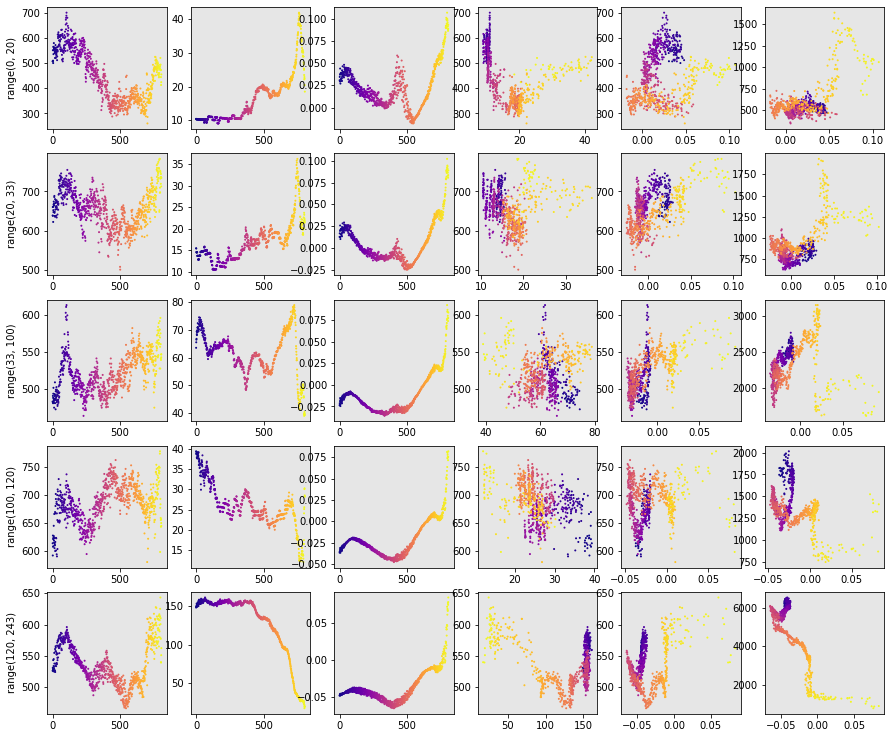

In [270]:
crown_idx = layer4_mean_local_flux.argmin()
crown_idx = 0
fig_column = 6
plt.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
fig = plt.figure(figsize=(2.5*fig_column,2.6*len(layers)))
# corr1 = []
# corr2 = []
my_size = len(seed_choice[crown_idx:])
for i, idx in enumerate(layers):
    fig.add_subplot(len(layers),fig_column,fig_column*i+1)
    plt.scatter(np.arange(my_size), mean_cell_density[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    plt.ylabel(idx)
    fig.add_subplot(len(layers),fig_column,fig_column*i+2)
    plt.scatter(np.arange(my_size), layer_thickness[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+3)
    plt.scatter(np.arange(my_size), mean_local_flux[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+4)
    plt.scatter(layer_thickness[i,crown_idx:], mean_cell_density[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+5)
    plt.scatter(mean_local_flux[i,crown_idx:], mean_cell_density[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    # corr1.append(pearsonr(layer_thickness[i,selection], mean_cell_density[i,selection]))
    # corr2.append(pearsonr(mean_local_flux[i,selection], mean_cell_density[i,selection]))
    fig.add_subplot(len(layers),fig_column,fig_column*i+6)
    plt.scatter(mean_local_flux[i,crown_idx:], layer_cell_count[i,:],s=1,c=np.arange(len(seed_choice)),cmap='plasma')


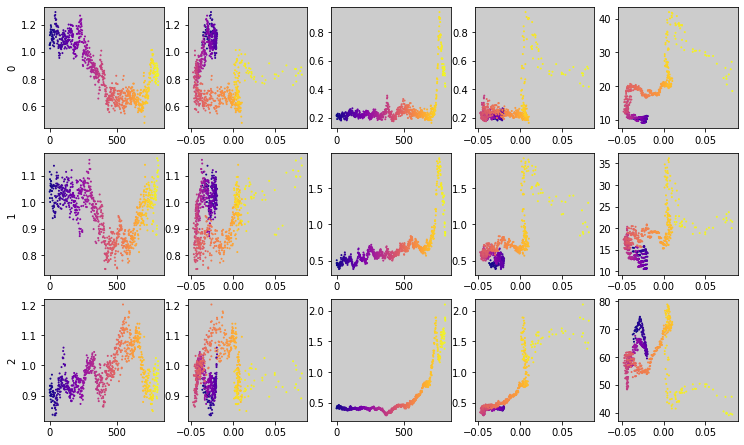

In [507]:
crown_idx = layer4_mean_local_flux.argmin()
crown_idx = 0
fig_column = 6
plt.rcParams['axes.facecolor'] = [0.8,0.8,0.8]
fig = plt.figure(figsize=(2.5*fig_column,2.6*len(layers)))
my_size = len(seed_choice[crown_idx:])
for i in range(3):
    fig.add_subplot(len(layers),fig_column,fig_column*i+1)
    plt.scatter(np.arange(my_size), mean_cell_density[i,crown_idx:]/mean_cell_density[i+2,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    plt.ylabel(i)
    fig.add_subplot(len(layers),fig_column,fig_column*i+2)
    plt.scatter(layer4_mean_local_flux[crown_idx:], mean_cell_density[i,crown_idx:]/mean_cell_density[i+2,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    # layer_cell_count
    fig.add_subplot(len(layers),fig_column,fig_column*i+3)
    plt.scatter(np.arange(my_size), layer_cell_count[i,crown_idx:]/layer_cell_count[i+2,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+4)
    #plt.scatter(layer4_mean_local_flux[crown_idx:], layer_cell_count[i,crown_idx:]/layer_cell_count[i+2,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    plt.scatter(layer4_mean_local_flux, layer_cell_count[i,:]/layer_cell_count[i+2,:],s=1,c=np.arange(layer4_mean_local_flux.size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+5)
    plt.scatter(layer4_mean_local_flux[crown_idx:], layer_thickness[i,crown_idx:],s=1,c=np.arange(my_size),cmap='plasma')
    # corr1.append(pearsonr(layer_thickness[i,selection], mean_cell_density[i,selection]))
    # corr2.append(pearsonr(mean_local_flux[i,selection], mean_cell_density[i,selection]))
    # fig.add_subplot(len(layers),fig_column,fig_column*i+6)
    # plt.scatter(np.arange(len(seed_choice)), mean_cell_density[i,:],s=1,c=np.arange(len(seed_choice)),cmap='plasma')


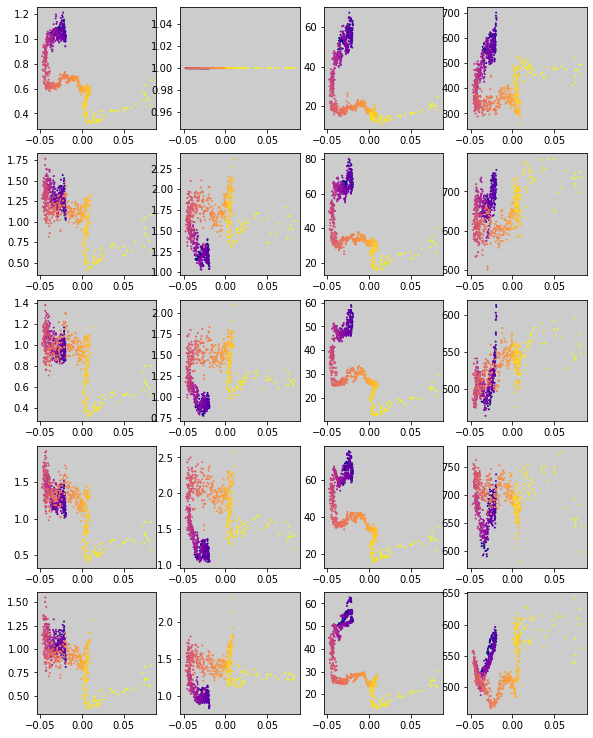

In [309]:
crown_idx = (layer4_mean_local_flux!=0)
fig_column = 6
plt.rcParams['axes.facecolor'] = [0.8,0.8,0.8]
fig = plt.figure(figsize=(2.5*fig_column,2.6*len(layers)))
my_size = crown_idx.sum()
for i in range(5):
    fig.add_subplot(len(layers),fig_column,fig_column*i+1)
    plt.scatter(layer4_mean_local_flux[crown_idx], mean_cell_density[i,crown_idx]/layer_cell_count[0,crown_idx],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+2)
    plt.scatter(layer4_mean_local_flux[crown_idx], mean_cell_density[i,crown_idx]/mean_cell_density[0,crown_idx],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+3)
    plt.scatter(layer4_mean_local_flux[crown_idx], mean_cell_density[i,crown_idx]/layer_thickness[0,crown_idx],s=1,c=np.arange(my_size),cmap='plasma')
    fig.add_subplot(len(layers),fig_column,fig_column*i+4)
    plt.scatter(layer4_mean_local_flux[crown_idx], mean_cell_density[i,crown_idx],s=1,c=np.arange(my_size),cmap='plasma')

    # corr1.append(pearsonr(layer_thickness[i,selection], mean_cell_density[i,selection]))
    # corr2.append(pearsonr(mean_local_flux[i,selection], mean_cell_density[i,selection]))
    # fig.add_subplot(len(layers),fig_column,fig_column*i+6)
    # plt.scatter(np.arange(len(seed_choice)), mean_cell_density[i,:],s=1,c=np.arange(len(seed_choice)),cmap='plasma')


In [376]:
def line_wise_aligner(std, target, initial_displacement, settings):
    displacement = np.zeros_like(target)
    f = interpolate.interp1d(np.arange(std.size), std, bounds_error=False, fill_value='extrapolate')

    for line in tqdm(range(target.shape[1])):
        # load initial_displacement
        shift = initial_displacement[:,line]
        
        # initial transform for the registration
        std_shift = f(np.arange(shift.size)-shift)

        # run pydeform line by line
        target_np = target[:,line]
        
        # convert to itk image for registration
        fix_l_itk = sitk.Cast(sitk.GetImageFromArray(target_np[:, np.newaxis, np.newaxis]),sitk.sitkFloat32)
        mov_l_itk = sitk.Cast(sitk.GetImageFromArray(std_shift[:, np.newaxis, np.newaxis]),sitk.sitkFloat32)

        df_sitk = pydeform.register(
            fix_l_itk,
            mov_l_itk,
            settings=settings,
            num_threads=60,
            use_gpu=True
        )

        pos = sitk.GetArrayFromImage(df_sitk)[:,0,0,2]
        displacement[:,line] = pos - shift
        coords = np.meshgrid(*[range(x) for x in displacement.shape], indexing='ij')
        coords = np.array(coords).astype(np.int16)
        target2standard = coords[0,:,:]-displacement
        standard2target = coords[0,:,:]+displacement

    return target2standard, standard2target

In [323]:
# # manually label the cells on surface using 2D plot

# # https://napari.org/api/napari.view_layers.html#napari.view_layers.view_points
# viewer = napari.Viewer()
# points = viewer.add_points(
#     translate_manifold2D,
#     size=2,
#     face_color = 'white',
#     edge_width=0,
#     symbol='disc',
# )
# labels = viewer.add_labels(np.zeros(translate_manifold2D.max(axis=0).astype(int),int), name='label')


/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [326]:
# # Check the labeled positions in 3D

# label_coords = np.asarray(np.nonzero(labels.data)).astype(int).T

# # a bit of trick. use pandas to choose the points where they belong to the manual label.
# elem = pd.DataFrame(translate_manifold2D.astype(int),index=seeds_df.index).reset_index().merge(pd.DataFrame(label_coords),how='inner',on=[0,1]).set_index('index')

# cond1 = seeds_df.iloc[:,4:].all(axis=1)
# cond2 = seeds_df.index.isin(elem.index)

# # visualize the label in 3D
# viewer = napari.Viewer()
# points = viewer.add_points(
#     seeds_df.iloc[:,0:3][cond1 * cond2],
#     size=2,
#     face_color = 'white',
#     edge_width=0,
#     symbol='disc',
# )
# viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='green', blending='additive', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3a1725b790>

In [508]:
# fonus analysis in crown 
seed_choice = seeds_df.index[seeds_df.iloc[:,4:].all(axis=1)].to_list()
#seed_choice = seeds_df[cond1*cond2].index.to_list()
# reduce dimention to 1d for manual alignment
X0_selected = seeds_df.iloc[:,0:3].loc[seed_choice,:]
iso1d = manifold.Isomap(n_neighbors=20, n_components=1, n_jobs=-1) # change n_neighbors in case of error.
iso1d.fit(X0_selected)
manifold_1D_ver2 = iso1d.transform(X0_selected)
manifold_1D_ver2_df = pd.DataFrame(manifold_1D_ver2,index=seed_choice)
seed_choice = manifold_1D_ver2_df.sort_values(0).index.to_list()

In [621]:
target_df = column_conv.reindex(seed_choice)
target = column_conv.reindex(seed_choice).to_numpy().T
viewer0 = napari.Viewer()
viewer0.add_image(target, rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)

<Image layer 'original' at 0x7f397d4391f0>

In [622]:
# std_idx = 596
# std_seed = seed_choice[std_idx]# dprime is done with std_seed 5582
# std_values = column_conv.loc[std_seed].to_numpy()

standard = np.repeat(std_values[:,np.newaxis],len(seed_choice),axis=1)
viewer0.add_image(standard, rgb=False, name='std', colormap='gray', blending='additive', multiscale=False)
# manually label layer IV for the flux calculation.
# based on the flux, choose gyrus-bank area
labels = viewer0.add_labels(np.zeros_like(standard.astype(int)), name='labeling')

In [623]:
# make initial displacement using manual labels.
labels_np = labels.data

initial_displacement = np.zeros_like(standard)

std_landmark = np.array([0,28,120,253,standard.shape[0]-1,standard.shape[0]]) # these are fixed numbers.
# target_landmarks = [] 
for line in range(standard.shape[1]):
    # make landmarks_fix
    landmark = std_landmark.copy()
    for i in range(1, std_landmark.size-1):
        positions = np.where(labels_np[:,line]==i)[0]
        if positions.size != 0:
            landmark[i] = round(positions.mean())
        else:
            landmark[i] = std_landmark[i]
    # make manually generated position shift
    shift = interpolate.griddata(std_landmark,landmark-std_landmark,xi=coord,method='linear') # cubic distort the thing...
    initial_displacement[:,line] = shift

In [624]:
# set parameters
settings = {
    'pyramid_levels':1, # larger number can deteriorate the initial alignment.
    'pyramid_stop_level': 0, # 1 is good. 2 is just enough, 3 is not enough.
    'step_size': [0.2, 0.2, 0.2], # [1.0,1.0,1.0] seems enough. more than that will degrade the quality
    'block_size': [0,0,0],
    'block_energy_epsilon':1e-7,
    'max_iteration_count':100,
    'constraints_weight':1000.0,
    'regularization_weight': 0.25, # default 0.25
    'regularization_scale': 1.0, # default 1.0
    'regularization_exponent': 2.0, # default 2.0
    'image_slots':[{
            'resampler': 'gaussian',
            'normalize': True,
            'cost_function':[
                {
                    'function':'ncc',
                    'weight':1.0,
                    'radius':15
                }
            ]
        }]
}

In [625]:
#my_choice = np.r_[-300:len(seed_choice)]
my_choice = list(range(0,len(seed_choice)))#list(range(100,150)) + list(range(-300,-1))

In [626]:
target2standard_ver2, standard2target_ver2 = line_wise_aligner(std_values, target[:,my_choice], initial_displacement[:,my_choice], settings)
# target2standard_ver2, standard2target_ver2 = line_wise_aligner(std_values, target[:,-300:], np.zeros_like(initial_displacement[:,-300:]), settings)
# pd.DataFrame(target2standard_ver2.T,index=seed_choice).to_csv('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/vessel_analysis/linewise_aligned.csv')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [1:51:10<00:00,  1.00it/s]


In [627]:
target2standard_ver2_df = pd.DataFrame(target2standard_ver2.T,index=seed_choice)
standard2target_ver2_df = pd.DataFrame(standard2target_ver2.T,index=seed_choice)

In [629]:
viewer = napari.Viewer()
viewer.add_image(np.diff(target2standard_ver2,axis=0), contrast_limits=[-0.1,0], rgb=False, name='tgt2std', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(target2standard_ver2, rgb=False, name='tgt2std', colormap='gray', blending='additive', multiscale=False)

<Image layer 'tgt2std [1]' at 0x7f39786595e0>

In [630]:
aligned_ver2 = map_coordinates(target[:,my_choice], make_displacement_map(target2standard_ver2), order=1, mode='constant')
aligned_ver2_df = pd.DataFrame(aligned_ver2.T,index=seed_choice)
aligned_standard_ver2 = map_coordinates(standard[:,my_choice], make_displacement_map(standard2target_ver2), order=1, mode='constant')
viewer = napari.Viewer()
viewer.add_image(target[:,my_choice], rgb=False, name='original', colormap='green', blending='additive', multiscale=False)
viewer.add_image(aligned_ver2, rgb=False, name='deform', colormap='magenta', blending='additive', multiscale=False)
viewer.add_image(standard[:,my_choice], rgb=False, name='standard', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(aligned_standard_ver2, rgb=False, name='standard', colormap='gray', blending='additive', multiscale=False)

<Image layer 'standard [1]' at 0x7f39783b9610>

In [797]:
# local flux map
local_flux = []
for i, seed_num in tqdm(list(enumerate(seed_choice))):
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    # append positions to be consisntent in size.
    positions = np.pad(positions,[(0,501-positions.shape[0]),(0,0)],mode='edge')
    # get local flux
    local_flux.append(get_local_flux(positions, flow_on_coordinate, radius))
    
local_flux_df = pd.DataFrame(np.vstack(local_flux),index=seed_choice)

aligned_local_flux = map_coordinates(np.vstack(local_flux).T, make_displacement_map(target2standard_ver2_df.reindex(seed_choice).T), order=1, mode='constant')
aligned_local_flux_df = pd.DataFrame(aligned_local_flux.T, index=seed_choice)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [00:24<00:00, 270.79it/s]


In [798]:
# ask layer mean cell density and thickness 

half_thickness = 2.5
radius = 10
layer_cell_count = []
layer_thickness = []

for seed_num in tqdm(seed_choice):
    # get positions and flows
    virtual_rg = virtual_rgs[seed_num]
    positions = virtual_rg.trajectory.ode_solution.y.T
    flow = flow_on_coordinate(positions) # flow is normalized
    
    dist = position2distance(positions)
    dprime = target2standard_ver2_df.loc[seed_num,:]
    cell_number_list = []
    thickness = []
    for layer in layers:
        # get range of layers
        eval_range = dprime[layer]
        eval_range = range(round(eval_range.min()),round(eval_range.max()))
        # count cell number
        _, idx, _ = conv_along_line(half_thickness, positions[eval_range], flow[eval_range], coords_tree, radius, time_end+1)
        cell_number_list.append(get_unique_number(idx).size)
        # measure thickness
        thickness.append(dist[eval_range].sum())
    layer_cell_count.append(np.asarray(cell_number_list))
    layer_thickness.append(np.asarray(thickness))
    
layer_cell_count = np.vstack(layer_cell_count).T
layer_cell_count_df = pd.DataFrame(layer_cell_count.T,index=seed_choice) # layer_cell_count_df = pd.DataFrame(layer_cell_count.T,index=seed_choice[:layer_cell_count.shape[1]])
layer_thickness = np.vstack(layer_thickness).T
layer_thickness_df = pd.DataFrame(layer_thickness.T,index=seed_choice) # layer_thickness_df = pd.DataFrame(layer_thickness.T,index=seed_choice[:layer_thickness.shape[1]])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [03:46<00:00, 29.64it/s]


In [891]:
# these are not accurate. but close.
layer_cell_density = []
layer_local_flux = []
for layer in layers:
    layer_cell_density.append(aligned_ver2[layer,:].mean(axis=0))
    layer_local_flux.append(aligned_local_flux[layer,:].mean(axis=0))

layer_cell_density = np.vstack(layer_cell_density) 
layer_cell_density_df = pd.DataFrame(layer_cell_density.T,index=seed_choice)
layer_cell_density = layer_cell_density_df.to_numpy().T

layer_local_flux = np.vstack(layer_local_flux)
layer_local_flux_df = pd.DataFrame(layer_local_flux.T,index=seed_choice)
layer4_local_flux = layer_local_flux[3,:]


In [695]:
# # redefine isomap for better visualization
# X0_selected = seeds_df.iloc[:,0:3].loc[my_choice,:]
# iso1d = manifold.Isomap(n_neighbors=10, n_components=1, n_jobs=-1) # change n_neighbors in case of error.
# iso1d.fit(X0_selected)
# manifold_1d_ver3 = iso1d.transform(X0_selected)
# manifold_1d_ver3_df = pd.DataFrame(manifold_1d_ver3,index=my_choice)
# my_sort = manifold_1d_ver3_df.sort_values(0).index.to_list()

In [696]:
# # visualize the label in 3D with color

# points_vis = seeds_df.iloc[:,0:3].reindex(my_sort)
# color_vis = color.get_colormap('plasma').map(np.arange(points_vis.shape[0]) / points_vis.shape[0])
# viewer = napari.Viewer()
# points = viewer.add_points(
#     points_vis,
#     size=10,
#     face_color = color_vis,
#     edge_width=0,
#     symbol='disc',
# )
# viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3972f4c3d0>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6699/6699 [00:01<00:00, 3645.63it/s]


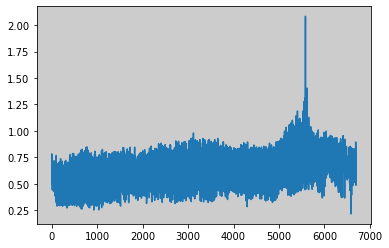

In [872]:
# remove seeds with low quality
mi = []
# dtws = [] # dtw and cosine similarity is almost same
cos_sim = []
for i in tqdm(list(range(aligned_ver2.shape[1]))):
    mi.append(mutual_information(std_values, aligned_ver2[:,i], bins=10))
    # dtws.append(dtw(std_values, aligned_ver2[:,i]))
    cos_sim.append(cosine_similarity(std_values, aligned_ver2[:,i]))
mi = np.asarray(mi)
# dtws = np.asarray(dtws)
cos_sim = np.asarray(cos_sim)


plt.plot(mi)

In [1397]:
# print(np.percentile(mi,50))
# print(np.percentile(cos_sim,50))

4313

0.6273109903903874
0.7670435176437579
1497


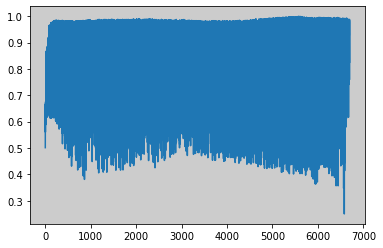

In [1419]:
# metrics = np.vstack([mi,cos_sim])
# metrics = zscore(metrics,axis=1)
# sns.clustermap(metrics, row_cluster=False)
th1 = threshold_otsu(mi)#np.percentile(mi,50)
th2 = threshold_otsu(cos_sim)#np.percentile(cos_sim,50)
print(th1)
print(th2)
plt.plot(cos_sim)
my_choice = np.asarray(seed_choice)[(mi>th1)*(cos_sim>th2)].tolist()
print(len(my_choice))

In [1440]:
# find 3D coordinate and map back into the 3D image for better visualization. Quality check
pos_img = np.zeros_like(asma_downscale)
for i, seed_num in enumerate(my_choice):
    virtual_rg = virtual_rgs[seed_num]
    positional_displacement = standard2target_ver2_df.loc[seed_num].to_numpy()
    positional_displacement[positional_displacement<0]=0 # clipping

    positions = virtual_rg.trajectory.ode_solution.y

    positional_displacement = positional_displacement[:positions.shape[1]]
    pos_img[tuple(positions.astype(int))] = positional_displacement
    
pos_img = pos_img * segmented_tissue.astype(np.uint16)
viewer = napari.Viewer()
viewer.add_image(pos_img, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='additive', multiscale=False)
viewer.add_image(autofl, contrast_limits=[0,5000], rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False, visible=False)


points_vis = seeds_df.iloc[:,0:3].reindex(my_choice)
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = 'white',
    edge_width=0,
    symbol='disc',
)

viewer2 = napari.Viewer()
viewer2.add_image(aligned_ver2_df.reindex(my_choice).to_numpy().T, rgb=False, name='aligned', colormap=turbo_dark, blending='additive', multiscale=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'aligned' at 0x7f356ef1f670>

[0.24013176 0.12114869 0.09221766 0.08084641 0.04541628 0.0447428
 0.03277949 0.03035387 0.02474309 0.01790013]
0.7302801679069882


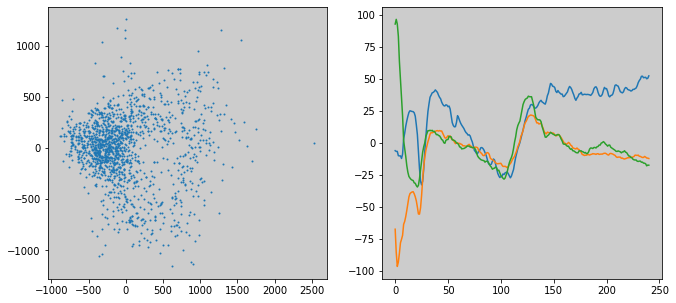

In [1673]:
# Can I do PCA/tSNE to the aligned space?
# However, pca only indicates how far from edge. It is an artifact and not biological.
from sklearn.decomposition import PCA

trim = 240
aligned_trimmed = aligned_ver2_df.loc[:,:trim].reindex(my_choice)
aligned_trimmed_zscore = zscore(aligned_trimmed,axis=0)
pca = PCA().fit(aligned_trimmed)
pcs = pca.transform(aligned_trimmed)
pc1 = pcs[:,0]
pc2 = pcs[:,1]

fig, axs = plt.subplots(ncols=2, figsize=(11,5))
axs[0].scatter(pc1,pc2,s=1)
#print(pca.explained_variance_ratio_)

component_num = 10
print(pca.explained_variance_ratio_[:component_num])
print(pca.explained_variance_ratio_[:component_num].sum())
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# fig, axs = plt.subplots(ncols=1, figsize=(5,5))
axs[1].plot(loadings[:,0])
axs[1].plot(loadings[:,1])
axs[1].plot(loadings[:,2])

# viewer = napari.Viewer()

# viewer.add_image(aligned_trimmed.T.to_numpy(), rgb=False, name='aligned', colormap='viridis', blending='additive', multiscale=False)
# viewer.add_image(zscore(aligned_trimmed.T.to_numpy(),axis=1), rgb=False, name='zscore', colormap='viridis', blending='additive', multiscale=False)

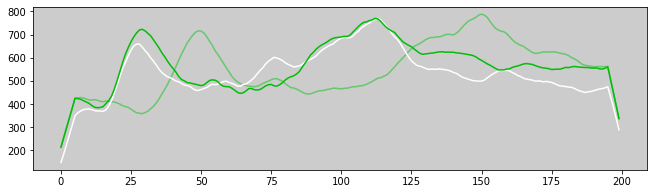

In [1670]:
fig, axs = plt.subplots(ncols=1, figsize=(11,3))
my_pos = 7
axs.plot(moving_average(target_df.reindex(my_choice).to_numpy().T[:200,my_pos]),c='#67c76b')
axs.plot(moving_average(std_values[:200]), c='white')
axs.plot(moving_average(aligned_ver2_df.reindex(my_choice).to_numpy().T[:200,my_pos]),c='#00bd06')
plt.savefig("/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/alignment_example.svg")

(0.6667019272252168, 4.431813768980088e-193)
(-0.01442049458292843, 0.577180741041842)
(0.15382005887249928, 2.202411178354008e-09)


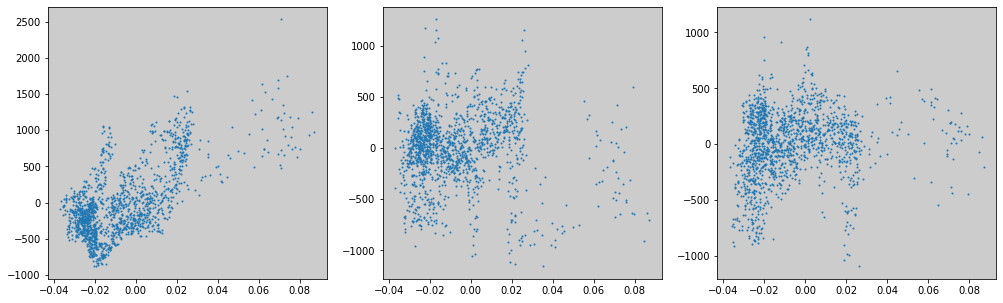

In [1469]:
fig, axs = plt.subplots(ncols=3, figsize=(17,5))
layer4_flux = layer_local_flux_df.reindex(my_choice).loc[:,2]

for i in range(3):
    axs[i].scatter(layer4_flux,pcs[:,i],s=1)

# sns.displot(pd.DataFrame(np.vstack([layer4_flux,pc1]).T),x=0,y=1, kind="kde",thresh=0.01)
print(pearsonr(layer4_flux,pcs[:,0]))
print(pearsonr(layer4_flux,pcs[:,1]))
print(pearsonr(layer4_flux,pcs[:,2]))
# plt.savefig("/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/pc1_local_flux_layer3.svg")

In [1682]:
# visualize the label in 3D with color

points_vis = seeds_df.iloc[:,0:3].reindex(my_choice)
viewer = napari.Viewer()

color_vis = color.get_colormap('viridis').map((pc1-np.percentile(pc1,2)) / (np.percentile(pc1,98)-np.percentile(pc1,2)))#((pc1-pc1.min()) / (pc1.max()-pc1.min()))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((pc2-np.percentile(pc2,2)) / (np.percentile(pc2,98)-np.percentile(pc2,2)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((layer4_flux-np.percentile(layer4_flux,2)) / (np.percentile(layer4_flux,98)-np.percentile(layer4_flux,2)))#((layer4_flux-layer4_flux.min()) / (layer4_flux.max()-layer4_flux.min()))
#color_vis = color.get_colormap('viridis').map((layer4_flux-np.min(layer4_flux)) / (np.max(layer4_flux)-np.min(layer4_flux)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)

viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,100000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3498fa0c10>

In [1489]:
# define function to calculate variable importance in projection
# https://github.com/scikit-learn/scikit-learn/issues/7050
def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [1504]:
# suppose the density is largely affected by divergence,
# how each positions of line are affected by divergence. test this with PLS.
# also read this. http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html
from sklearn.cross_decomposition import PLSRegression
from sklearn import model_selection

kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, aligned_trimmed_zscore, layer4_flux, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)
pls2 = PLSRegression(n_components=np.argmin(mse)).fit(aligned_trimmed_zscore,layer4_flux)

(0.0, 1.8)

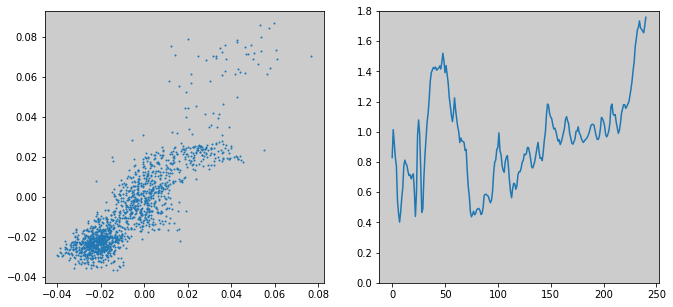

In [1681]:
fig, axs = plt.subplots(ncols=2, figsize=(11,5))
axs[0].scatter(pls2.predict(aligned_trimmed_zscore),layer4_flux,s=1)
axs[1].plot(vip(aligned_trimmed_zscore,layer4_flux,pls2))
axs[1].set_ylim([0, 1.8])
# fig, axs = plt.subplots(ncols=1, figsize=(11,3))
# axs.plot(vip(aligned_trimmed_zscore,layer4_flux,pls2))
# axs.set_ylim([0, 1.8])
# plt.savefig("/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/vip_anlaysis_layer.svg")

In [1655]:
viewer = napari.Viewer()
viewer.add_image(aligned_trimmed.T.to_numpy(), rgb=False, name='aligned', colormap='magma', blending='additive', multiscale=False)
viewer.add_image(aligned_trimmed_zscore.T.to_numpy(), rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)
viewer.add_image(target_df.reindex(my_choice).to_numpy().T, rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)
# viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[33:56,100:], rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)
# viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[77:100,100:], rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)
# viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[220:243,100:], rgb=False, name='zscoreall', colormap='magma', blending='additive', multiscale=False)

<Image layer 'original' at 0x7f34d0ff5b80>

In [1553]:
# how much can I reduce the variance by analysing in my way?
# get bin and divide flux into 10 ranges
# measure SD in each range. SD of 
bin_num = 10
my_bin = np.arange(layer4_flux.min(),layer4_flux.max(),(layer4_flux.max()-layer4_flux.min())/bin_num)
idx = np.digitize(layer4_flux,my_bin)
idx_df = pd.DataFrame(idx,index=my_choice)
sum_count = []
for seed_num in my_choice:
    #tes = target_df.reindex(my_choice)[idx==i]
    cell_count = target_df.loc[seed_num,:]
    loc = round(standard2target_ver2_df.loc[seed_num,:].iloc[layer4[-1]])
    sum_count.append(cell_count.iloc[:loc].sum())
sum_count_df = pd.DataFrame(sum_count,index=my_choice)

In [1564]:
sd_percent = []
for i in range(1,idx.max()+1):
    sd = np.std(sum_count_df[idx==i].to_numpy())
    sd_percent.append(sd/sum_count_df[idx==i].mean().values)
    #sd_list.append()
sd_percent

[array([0.08312438]),
 array([0.12592723]),
 array([0.10199797]),
 array([0.11102986]),
 array([0.07035193]),
 array([0.10140826]),
 array([0.05348969]),
 array([0.13829879]),
 array([0.12956897]),
 array([0.10453193])]

In [1590]:
viewer = napari.Viewer()
viewer.add_image(aligned_ver2_df.reindex(my_choice).T.to_numpy()[:300,620:1310], rgb=False, name='aligned', colormap='viridis', blending='additive', multiscale=False)
#viewer.add_image(aligned_trimmed_zscore.T.to_numpy(), rgb=False, name='zscoreall', colormap='viridis', blending='additive', multiscale=False)
viewer.add_image(target_df.reindex(my_choice).to_numpy().T[:300,620:1310], rgb=False, name='original', colormap='gray', blending='additive', multiscale=False)
#viewer.add_image(aligned_trimmed_zscore.T.to_numpy()[:,::4], rgb=False, name='zscore_skipped', colormap='viridis', blending='additive', multiscale=False)


<Image layer 'original' at 0x7f35475aa250>

In [1698]:
# can I estimate radial glial density with aSMA?
skeleton = np.load(os.path.join(io_directory,'skeleton.npy'))

In [1716]:
viewer = napari.Viewer()

viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,100000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
viewer.add_image(asma_downscale*(~tes), contrast_limits=[0,100000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)
viewer.add_image(skeleton, rgb=False, name='skeleton', colormap='yellow', blending='additive', multiscale=False,visible=False)
#viewer.add_image(skeleton*(~tes), contrast_limits=[0,50],rgb=False, name='segment', colormap='yellow', blending='additive', multiscale=False,visible=False)


<Image layer 'skeleton' at 0x7f3489dd8340>

In [1711]:
tes = binary_erosion(binary_erosion(segmented_tissue, ball(5)),ball(5))#.sum()


In [1282]:
'''DBSCAN did not work because it connects all the population...'''
# # should I take into account the spatial information or clustering?
# # https://stackoverflow.com/questions/66406003/clustering-geospatial-data-on-coordinates-and-non-spatial-feature
# # how about getting pairwise mutual information?
# # both in before and after alignment.
# # before alignment. the length of vectors are adjusted to be same by simply cutting off the longer one.
# standard_end_pos = 300
# combination_mi_df = pd.DataFrame(columns=my_choice,index=my_choice)
# for s1, s2 in tqdm(list(itertools.combinations(my_choice,2))):
#     end_pos1 = round(standard2target_ver2_df.loc[s1,standard_end_pos])
#     end_pos2 = round(standard2target_ver2_df.loc[s2,standard_end_pos])
#     end_pos = np.min([end_pos1,end_pos2])
#     vec1 = target_df.loc[s1,:].to_numpy()[:end_pos]
#     vec2 = target_df.loc[s2,:].to_numpy()[:end_pos]
#     combination_mi_df.loc[s1,s2] = mutual_information(vec1, vec2, bins=10)
#     combination_mi_df.loc[s2,s1] = combination_mi_df.loc[s1,s2]
# # to fill diagonal
# for s in my_choice:
#     end_pos = round(standard2target_ver2_df.loc[s,standard_end_pos])
#     vec = target_df.loc[s,:].to_numpy()[:end_pos]
#     combination_mi_df.loc[s,s] = mutual_information(vec, vec, bins=10)
    
# # cosine similarity ver
# # before alignment. the length of vectors are adjusted to be same by simply cutting off the longer one.
# standard_end_pos = 300
# combination_cs_df = pd.DataFrame(columns=my_choice,index=my_choice,dtype=float)
# for s1, s2 in tqdm(list(itertools.combinations(my_choice,2))):
#     end_pos1 = round(standard2target_ver2_df.loc[s1,standard_end_pos])
#     end_pos2 = round(standard2target_ver2_df.loc[s2,standard_end_pos])
#     end_pos = np.min([end_pos1,end_pos2])
#     vec1 = target_df.loc[s1,:].to_numpy()[:end_pos]
#     vec2 = target_df.loc[s2,:].to_numpy()[:end_pos]
#     combination_cs_df.loc[s1,s2] = cosine_similarity(vec1, vec2)
#     combination_cs_df.loc[s2,s1] = combination_cs_df.loc[s1,s2]
# # to fill diagonal
# for s in my_choice:
#     end_pos = round(standard2target_ver2_df.loc[s,standard_end_pos])
#     vec = target_df.loc[s,:].to_numpy()[:end_pos]
#     combination_cs_df.loc[s,s] = cosine_similarity(vec, vec)
    
# # after alignment. 
# combination_mi_aligned_df = pd.DataFrame(columns=my_choice,index=my_choice, dtype=float)
# for s1, s2 in tqdm(list(itertools.combinations(my_choice,2))):
#     vec1 = aligned_ver2_df.loc[s1,:].to_numpy()[:standard_end_pos]
#     vec2 = aligned_ver2_df.loc[s2,:].to_numpy()[:standard_end_pos]
#     combination_mi_aligned_df.loc[s1,s2] = mutual_information(vec1, vec2, bins=10)
#     combination_mi_aligned_df.loc[s2,s1] = combination_mi_aligned_df.loc[s1,s2]

# # to fill diagonal
# for s in my_choice:
#     vec = aligned_ver2_df.loc[s,:].to_numpy()[:standard_end_pos]
#     combination_mi_aligned_df.loc[s,s] = mutual_information(vec, vec, bins=10)
    
# # DBSCAN using mutual information
# import hdbscan
# db = hdbscan.HDBSCAN(metric='precomputed',min_cluster_size=6)
# clusterer = db.fit((1/combination_cs_df-1).to_numpy())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1119756/1119756 [11:04<00:00, 1685.16it/s]


In [1604]:
values = []

for i in range(4):
    #val = layer_cell_count[i,:]/layer_cell_count[i+1,:] #metric_of_choice
    val = np.log10(layer_cell_count[i,:]) - np.log10(layer_cell_count[i+1,:])
    # val = layer_cell_count_df.reindex(my_choice).to_numpy().T[i,:]/layer_cell_count_df.reindex(my_choice).to_numpy().T[i+1,:]
    # plow = np.percentile(val,15)
    # phigh = np.percentile(val,85)
    
    # val[val<plow] = plow
    # val[val>phigh] = phigh
    
    #values.append((val - np.median(val)) / (phigh - plow))
    values.append(val)
val_df = pd.DataFrame(np.vstack(values).T,index=seed_choice)
val_df = val_df.reindex(my_choice)

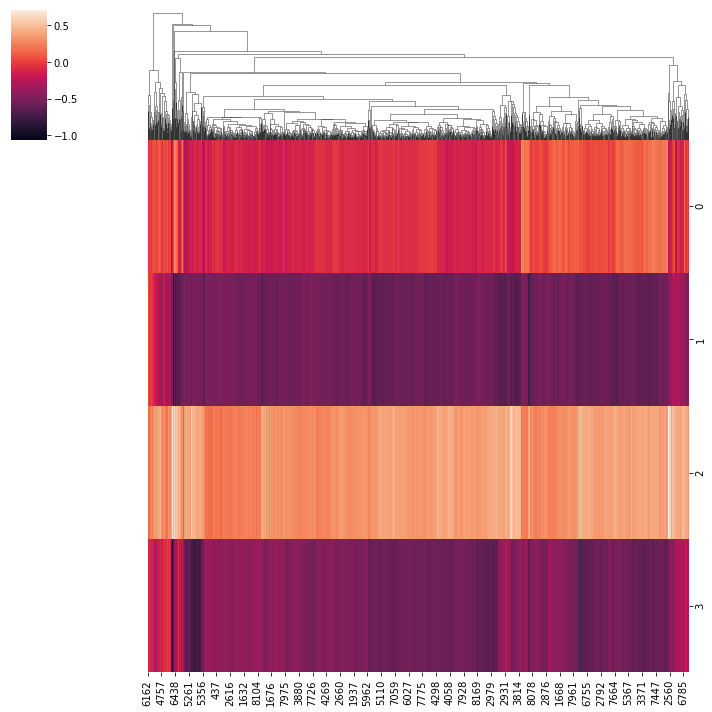

In [1605]:
import seaborn as sns
#from scipy.stats import zscore
from sklearn.cluster import AgglomerativeClustering

# my_mtx = val_df.reindex(my_choice).T
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward').fit(val_df)
label = cluster.labels_
# heatmap should look boring. This is the sampling highly biased onto the region with higher surface area
sns.clustermap(val_df.T, row_cluster=False)
label_df = pd.Series(label,index=my_choice)

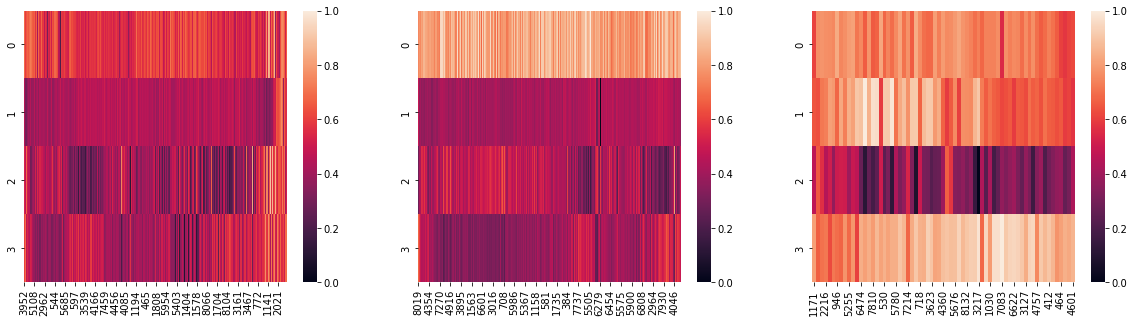

In [1606]:
_, freq = np.unique(label, return_counts=True)
val_df_norm = (val_df - val_df.min(axis=0)) / (val_df.max(axis=0) - val_df.min(axis=0))

fig, axs = plt.subplots(ncols=label.max()+1, figsize=(20,5))
for i in range(label.max()+1):
    sns.heatmap(val_df_norm[label==np.argsort(freq)[-i-1]].T,ax=axs[i],vmin=0.0,vmax=1.0)

In [1126]:
# tes = val_df.groupby(label).sample(n=freq.min())

In [1614]:
# do pca to extract "gyrus-ness"
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(val_df)
pcs = pca.transform(val_df)
pc1 = pcs[:,0]
pc2 = pcs[:,1]
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.46164911 0.2953492  0.12824598 0.11475571]
1.0


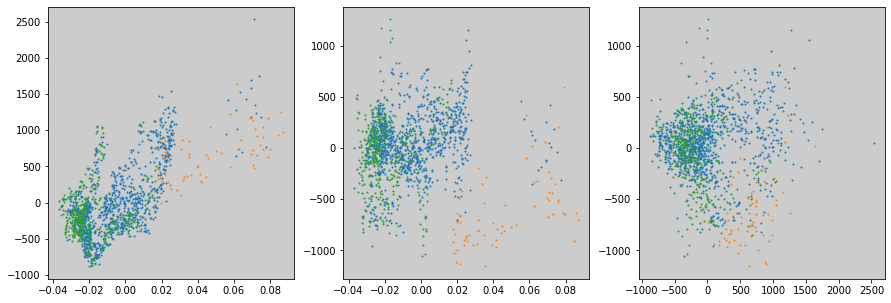

In [1720]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
layer4_flux = layer_local_flux_df.reindex(my_choice).loc[:,2]
for i in range(label.max()+1):
    axs[0].scatter(layer4_flux[label==i],pc1[label==i],s=1)
    axs[1].scatter(layer4_flux[label==i],pc2[label==i],s=1)
    axs[2].scatter(pc1[label==i],pc2[label==i],s=1)

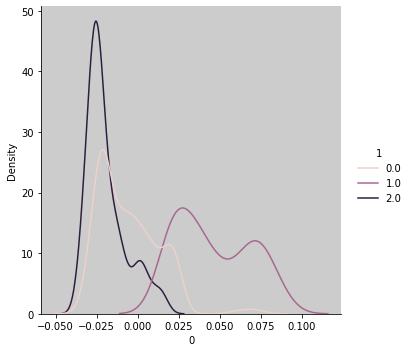

In [1230]:
sns.displot(pd.DataFrame(np.vstack([layer4_flux,label]).T),x=0,hue=1, kind="kde",common_norm=False,hue_order=(0,1,3,5,2,4))

In [1612]:
# visualize the label in 3D with color

points_vis = seeds_df.iloc[:,0:3].reindex(my_choice)
viewer = napari.Viewer()

#('viridis').map((pc1-np.percentile(pc1,2)) / (np.percentile(pc1,98)-np.percentile(pc1,2)))
# color_vis = color.get_colormap('viridis').map((label-label.min()) / (label.max()-label.min()))
# points = viewer.add_points(
#     points_vis,
#     size=10,
#     face_color = color_vis,
#     edge_width=0,
#     symbol='disc',
# )

color_vis = color.get_colormap('viridis').map((pc1-np.percentile(pc1,2)) / (np.percentile(pc1,98)-np.percentile(pc1,2)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((pc2-np.percentile(pc2,2)) / (np.percentile(pc2,98)-np.percentile(pc2,2)))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)
color_vis = color.get_colormap('viridis').map((layer4_flux-np.percentile(layer4_flux,2)) / (np.percentile(layer4_flux,98)-np.percentile(layer4_flux,2)))#(layer4_flux-layer4_flux.min()) / (layer4_flux.max()-layer4_flux.min()))
points = viewer.add_points(
    points_vis,
    size=10,
    face_color = color_vis,
    edge_width=0,
    symbol='disc',
)

viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='gray', blending='translucent', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3438418bb0>

In [1159]:
viewer = napari.Viewer()
shift = -100

for i in range(label_df.max()+1):
    my_tes = aligned_ver2_df.reindex(label_df[label_df==i].index)
    #my_tes = zscore(((my_tes) - (np.roll(my_tes,shift,axis=0))),axis=0)
    viewer.add_image(my_tes.to_numpy().T, rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False) # ((my_tes) - (np.roll(my_tes,shift,axis=0)))

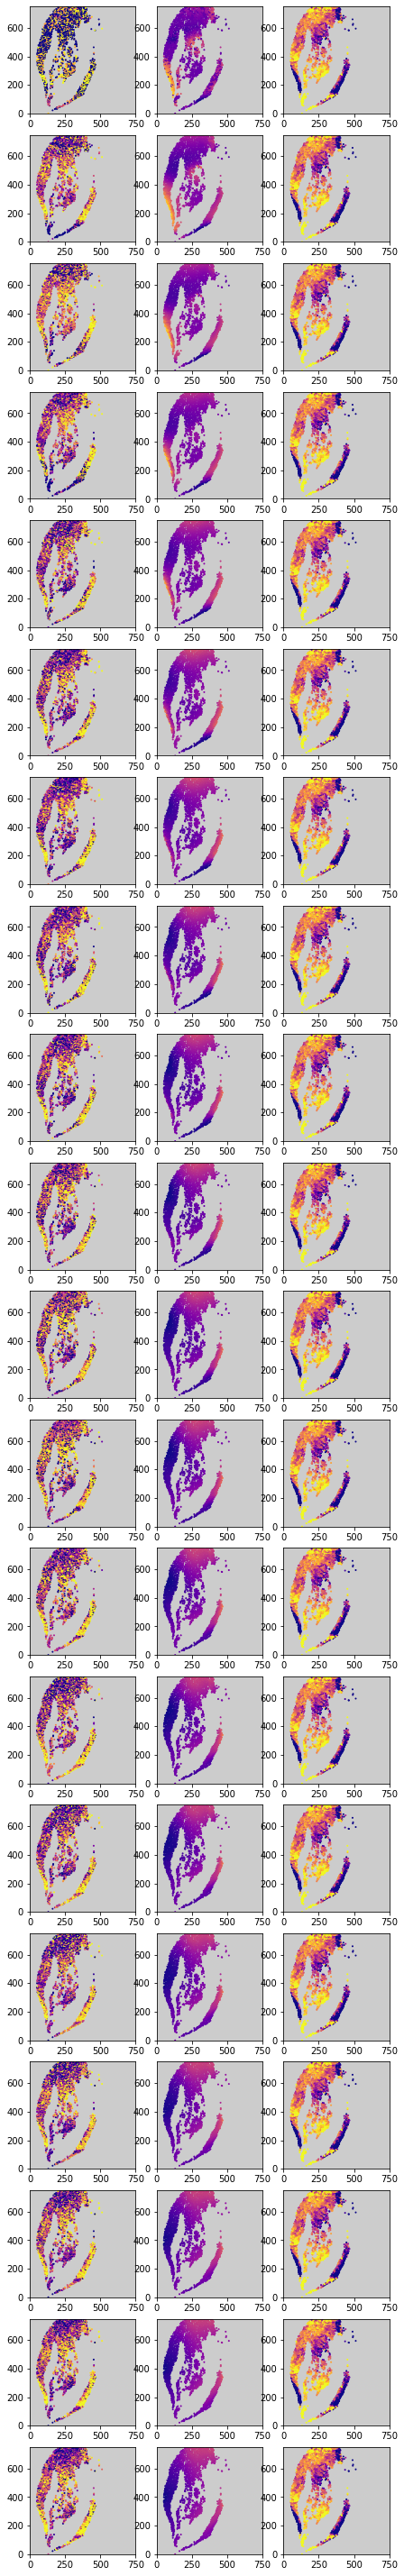

In [678]:
my_list = list(range(0,200,10))
crown_idx = layer_cell_count.shape[1]#(layer4_mean_local_flux!=0)
fig_column = len(my_list)
plt.rcParams['axes.facecolor'] = [0.8,0.8,0.8]
fig = plt.figure(figsize=(2.5*fig_column,2.6*len(my_list))) 

uv_df = translate_manifold2D_df.reindex(my_choice[:crown_idx])
metric_of_choice = layer_thickness[2,:crown_idx]

for idx, i in enumerate(my_list):
    fig.add_subplot(len(my_list),fig_column,fig_column*idx+1)
    val = aligned_ver2[i,:crown_idx]/metric_of_choice
    plow = np.percentile(val,15)
    phigh = np.percentile(val,85)
    val[val<plow] = plow
    val[val>phigh] = phigh
    # val = (val - val.min()) / (val.max() - val.min())
    plt.scatter(uv_df.loc[:,1],uv_df.loc[:,0],s=1,c=val,cmap='plasma')
    plt.xlim(0,750)
    plt.ylim(0,750)

    fig.add_subplot(len(my_list),fig_column,fig_column*idx+2)
    val = aligned_local_flux[i,:crown_idx]#mean_local_flux[:crown_idx]
    plt.scatter(uv_df.reindex(my_choice).loc[:,1],uv_df.reindex(my_choice).loc[:,0],s=1,c=val,cmap='plasma')
    plt.xlim(0,750)
    plt.ylim(0,750)
    
    fig.add_subplot(len(my_list),fig_column,fig_column*idx+3)
    val = metric_of_choice
    plow = np.percentile(val,15)
    phigh = np.percentile(val,85)
    val[val<plow] = plow
    val[val>phigh] = phigh
    plt.scatter(uv_df.reindex(my_choice).loc[:,1],uv_df.reindex(my_choice).loc[:,0],s=1,c=val,cmap='plasma')
    plt.xlim(0,750)
    plt.ylim(0,750)

In [324]:
# # cell density: aligned
# # local flux: aligned_local_flux
# # stretchiness: logFC_df.to_numpy().T
# cell_density = aligned
# local_flux = aligned_local_flux
# stretchiness = logFC_df.to_numpy().T

# cell_num_dist_corrected = cell_density * aligned_travelled_dist
# flux = local_flux * aligned_travelled_dist

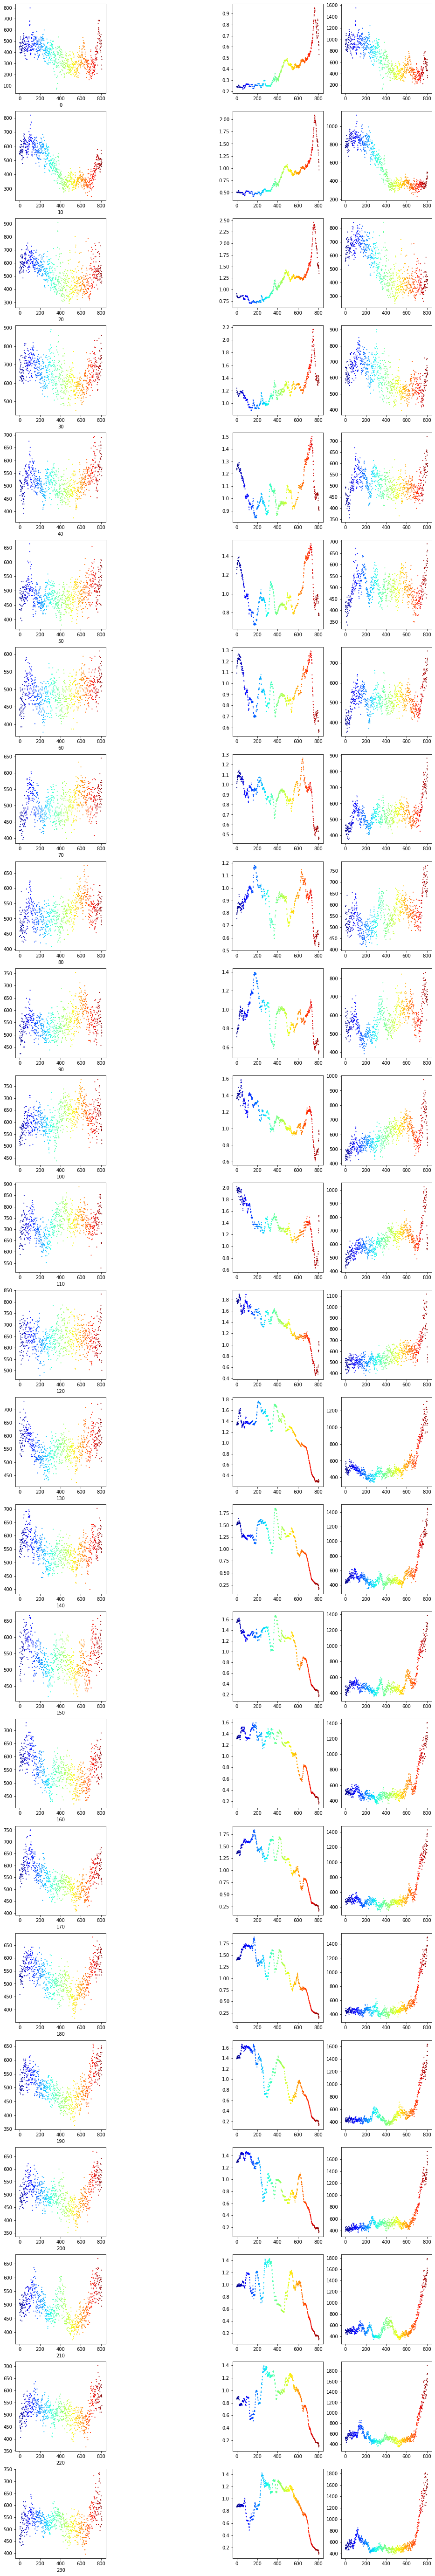

In [1025]:
# # check the correlation of these three for each d' position
# step = 10
# my_range = range(0,240,step)
# fig = plt.figure(figsize=(4*4,4.2*len(my_range)))
# for i, idx in enumerate(my_range):
#     fig.add_subplot(len(my_range),4,4*i+1)
#     plt.scatter(np.arange(len(seed_choice)), cell_density[idx,:],s=1,c=np.arange(len(seed_choice)),cmap='jet')
#     plt.xlabel(idx)
#     # fig.add_subplot(len(my_range),4,4*i+2)
#     # plt.scatter(np.arange(len(seed_choice)), cell_num_dist_corrected[idx,:],s=1,c=np.arange(len(seed_choice)),cmap='jet')
#     fig.add_subplot(len(my_range),4,4*i+3)
#     plt.scatter(np.arange(len(seed_choice)), aligned_travelled_dist[idx,:],s=1,c=np.arange(len(seed_choice)),cmap='jet')
#     fig.add_subplot(len(my_range),4,4*i+4)
#     plt.scatter(np.arange(len(seed_choice)), cell_density[idx,:]/np.sqrt(aligned_travelled_dist[idx,:]),s=1,c=np.arange(len(seed_choice)),cmap='jet')

#     # fig.add_subplot(len(my_range),4,4*i+3)
#     # plt.scatter(stretchiness[idx,:], cell_density[idx,:],s=1,c=np.arange(len(seed_choice)),cmap='jet')
#     # fig.add_subplot(len(my_range),4,4*i+4)
#     # plt.scatter(stretchiness[idx,:], local_flux[idx,:],s=1,c=np.arange(len(seed_choice)),cmap='jet')


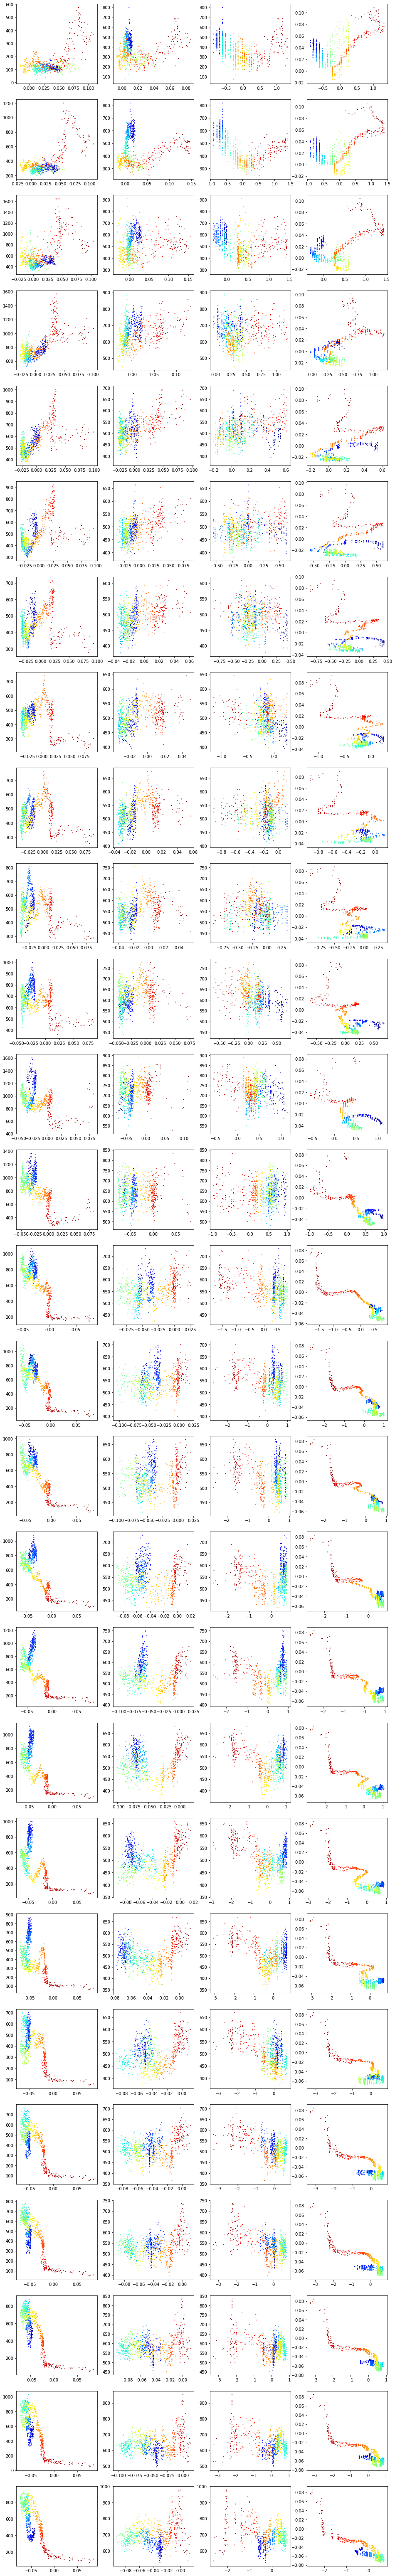

In [1007]:
# # check the correlation of these three for each d' position
# step = 10
# my_range = range(0,270,step)
# fig = plt.figure(figsize=(4*4,4.2*len(my_range)))
# for i, idx in enumerate(my_range):
#     fig.add_subplot(len(my_range),4,4*i+1)
#     plt.scatter(local_flux[idx,:], cell_num_dist_corrected[idx,:],s=1,c=np.arange(len(seed_choice)),cmap='jet')
#     fig.add_subplot(len(my_range),4,4*i+2)
#     plt.scatter(flux[idx,:], cell_density[idx,:],s=1,c=np.arange(len(seed_choice)),cmap='jet')
#     fig.add_subplot(len(my_range),4,4*i+3)
#     plt.scatter(stretchiness[idx,:], cell_density[idx,:],s=1,c=np.arange(len(seed_choice)),cmap='jet')
#     fig.add_subplot(len(my_range),4,4*i+4)
#     plt.scatter(stretchiness[idx,:], local_flux[idx,:],s=1,c=np.arange(len(seed_choice)),cmap='jet')


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 789/807 [00:04<00:00, 146.62it/s]/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 807/807 [00:04<00:00, 175.85it/s]
/tmp/ipykernel_6374/1556010245.py:46: RuntimeWarning:

invalid value encountered in true_divide



(0.0, 44.76372333353829)

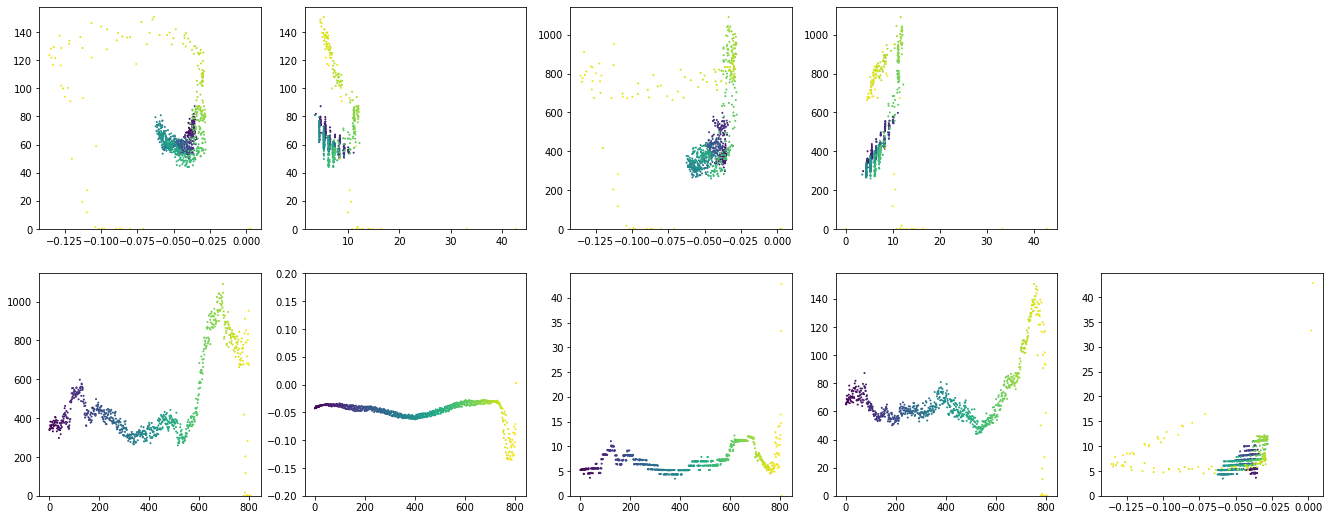

In [937]:
# # get correlation of the cell density and divergence.
# p = 240
# w = 10
# layer_start = p; layer_end = p+w
# # divergence_func = get_divergence_func(clf.coef_,poly.powers_)
# length_list = []
# flux_list = []
# cell_number_list = []
# radius = 10

# for i, seed_num in tqdm(list(enumerate(seed_choice))):
#     virtual_rg = virtual_rgs[seed_num]
#     positions = virtual_rg.trajectory.ode_solution.y.T    
    
#     # get curve length
#     dist = position2distance(positions)
#     eval_range = standard2target_df.loc[seed_num,:].to_numpy()[layer_start:layer_end]
#     cond = np.zeros(standard2target_df.shape[1],dtype=bool)
#     cond[eval_range[0].astype(int):eval_range[-1].astype(int)] = True
#     cond = cond[:dist.size]
#     length_list.append(dist[cond].sum())

#     # get flow on the postion
#     flow = flow_on_coordinate(positions) # flow is normalized

#     # get cell count in the region
#     _, idx, _ = conv_along_line(half_thickness, positions[cond], flow[cond], coords_tree, radius, time_end+1)
#     cell_number_list.append(get_unique_number(idx).size)

#     flux_points_norm = position_on_circunference(radius, n_points=8, dim=3)

#     flux_points = rotate_with_normals(flux_points_norm, flow)
#     translated_flux_points = flux_points + positions

#     temp = flow_on_coordinate(translated_flux_points.reshape(-1, translated_flux_points.shape[-1]))
#     flux_vecs = temp.reshape(translated_flux_points.shape)

#     flux = np.einsum('ijk,ijk->j', flux_vecs, flux_points/radius) / flux_points_norm.shape[0]
    
#     flux_list.append(np.mean(flux[cond]))

# length_np = np.asarray(length_list)
# flux_np = np.asarray(flux_list)
# #dense_np = fix_deform_df.reindex(seed_choice).iloc[:,layer_start:layer_end].mean(axis=1)#pos_disp[layer_start:layer_end,:].mean(axis=0)
# cell_number_np = np.asarray(cell_number_list)
# dense_np = cell_number_np / length_np

# fig = plt.figure(figsize=(23,9))
# fig.add_subplot(2,5,1)
# plt.scatter(flux_np,dense_np,s=1, c=np.arange(flux_np.size))
# plt.ylim(ymin=0) 
# fig.add_subplot(2,5,2)
# plt.scatter(length_np,dense_np,s=1, c=np.arange(length_np.size))
# plt.ylim(ymin=0) 
# fig.add_subplot(2,5,3)
# plt.scatter(flux_np,cell_number_np,s=1, c=np.arange(flux_np.size))
# plt.ylim(ymin=0) 
# fig.add_subplot(2,5,4)
# plt.scatter(length_np,cell_number_np,s=1, c=np.arange(flux_np.size))
# plt.ylim(ymin=0) 

# fig.add_subplot(2,5,6)
# plt.scatter(np.arange(cell_number_np.size),cell_number_np,s=1, c=np.arange(cell_number_np.size))
# plt.ylim(ymin=0) 
# fig.add_subplot(2,5,7)
# plt.scatter(np.arange(flux_np.size),flux_np,s=1, c=np.arange(flux_np.size))
# plt.ylim(ymin=-0.2,ymax=0.2) 
# fig.add_subplot(2,5,8)
# plt.scatter(np.arange(length_np.size),length_np,s=1, c=np.arange(length_np.size))
# plt.ylim(ymin=0) 
# fig.add_subplot(2,5,9)
# plt.scatter(np.arange(dense_np.size),dense_np,s=1, c=np.arange(dense_np.size))
# plt.ylim(ymin=0) 
# fig.add_subplot(2,5,10)
# plt.scatter(flux_np,length_np,s=1, c=np.arange(length_np.size))
# plt.ylim(ymin=0) 

(0.0, 2000.0)

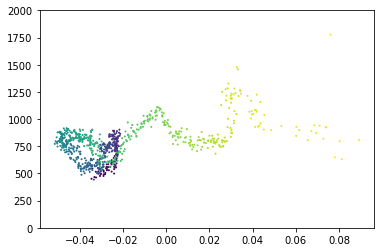

In [849]:
plt.scatter(flux_np,cell_number_np,s=1, c=np.arange(flux_np.size))
plt.ylim(0,2000) 


In [1232]:
# # visualization in uvd space
# vis_img = np.zeros((column_conv_np.shape[0],selected_translate_manifold2D.max(axis=0).astype(int)[0]+1, selected_translate_manifold2D.max(axis=0).astype(int)[1]+1))

# for i, seed_num in enumerate(list(selected_manihold_1D.index)):
#     if mi[seed_num] > thresh:
#         u = int(translate_manifold2D_df.loc[seed_num,0])
#         v = int(translate_manifold2D_df.loc[seed_num,1])
#         vis_img[:,u,v] = pos_disp[:,i]

# # selected_translate_manifold2D
# viewer = napari.Viewer()
# viewer.add_image(vis_img, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='additive', multiscale=False)
# points = viewer.add_points(
#     np.insert(translate_manifold2D,0,0,axis=1),
#     size=2,
#     face_color = 'white',
#     edge_width=0,
#     symbol='disc',
# )

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [1233]:
# # make df with index and dprime position.
# dprime_df = pd.DataFrame(pos_disp.T,index=selected_manihold_1D.index)
# dprime_df = dprime_df[mi>thresh]
# uv_df = translate_manifold2D_df.iloc[dprime_df.index,:]

# # this is for smoothing.
# rbf1 = interpolate.RBFInterpolator(uv_df,dprime_df, smoothing=0.5, kernel='inverse_quadratic', epsilon=1.0)
# val = rbf1(uv_df)
# val_df = pd.DataFrame(val, index=uv_df.index)

# img_arr0 = np.zeros((dprime_df.shape[1], translate_manifold2D_df[0].max().astype(int)+1, translate_manifold2D_df[1].max().astype(int)+1))
# img_arr0[:, uv_df.to_numpy().astype(int)[:,0], uv_df.to_numpy().astype(int)[:,1]] = dprime_df.to_numpy().T
# img_arr1 = np.zeros((dprime_df.shape[1], translate_manifold2D_df[0].max().astype(int)+1, translate_manifold2D_df[1].max().astype(int)+1))
# img_arr1[:, uv_df.to_numpy().astype(int)[:,0], uv_df.to_numpy().astype(int)[:,1]] = val.T

# viewer = napari.Viewer()
# viewer.add_image(img_arr0, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='opaque', multiscale=False)
# viewer.add_image(img_arr1, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='opaque', multiscale=False)
# labels = viewer.add_labels(np.zeros_like(img_arr1.astype(int)), name='labeling')

In [1398]:
# # make df with index and dprime position.
# dprime_df2 = pd.DataFrame(pos_np.T,index=selected_manihold_1D.index)
# dprime_df2 = dprime_df2[mi>thresh]
# uv_df = translate_manifold2D_df.iloc[dprime_df2.index,:]

# # this is for smoothing.
# rbf2 = interpolate.RBFInterpolator(uv_df,dprime_df2, smoothing=0.5, kernel='inverse_quadratic', epsilon=1.0)

# val = rbf2(uv_df)
# val_df = pd.DataFrame(val, index=uv_df.index)

# img_arr0 = np.zeros((dprime_df2.shape[1], translate_manifold2D_df[0].max().astype(int)+1, translate_manifold2D_df[1].max().astype(int)+1))
# img_arr0[:, uv_df.to_numpy().astype(int)[:,0], uv_df.to_numpy().astype(int)[:,1]] = dprime_df2.to_numpy().T
# img_arr1 = np.zeros((dprime_df2.shape[1], translate_manifold2D_df[0].max().astype(int)+1, translate_manifold2D_df[1].max().astype(int)+1))
# img_arr1[:, uv_df.to_numpy().astype(int)[:,0], uv_df.to_numpy().astype(int)[:,1]] = val.T

# viewer = napari.Viewer()
# viewer.add_image(img_arr0, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='opaque', multiscale=False)
# viewer.add_image(img_arr1, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='opaque', multiscale=False)


<Image layer 'flow [1]' at 0x7f3b99123b50>

In [1235]:
# labels = labels.data.max(axis=0)

In [1244]:
# # # Check the labeled positions in 3D
# label_coords = np.asarray(np.nonzero(labels!=0)).astype(int).T

# # # a bit of trick. use pandas to choose the points where they belong to the manual label.
# elem = translate_manifold2D_df.astype(int).reset_index().merge(pd.DataFrame(label_coords),how='inner',on=[0,1]).set_index('index')
# # elem = pd.DataFrame(translate_manifold2D.astype(int),index=seeds_df.index).reset_index().merge(pd.DataFrame(label_coords),how='inner',on=[0,1]).set_index('index')

# cond1 = seeds_df.index.isin(dprime_df.index)
# cond2 = seeds_df.index.isin(elem.index)

# # visualize the label in 3D
# viewer = napari.Viewer()
# points = viewer.add_points(
#     seeds_df.iloc[:,0:3][cond1*cond2],
#     size=2,
#     face_color = 'magenta',
#     edge_width=0,
#     symbol='disc',
# )
# viewer.add_image(autofl, contrast_limits=[0,20000], rgb=False, name='auto', colormap='green', blending='additive', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<Image layer 'asma' at 0x7f3c415fc790>

In [1136]:
# # because the alignment is not continuous, make it continuous by mapping back onto the original 3d tissue space
# # find 3D coordinate and map back onto the 3D image for fitting
# pos_img = np.zeros_like(asma_downscale)
# for i, seed_num in enumerate(list(uv_df.index)):
#     virtual_rg = virtual_rgs[seed_num]
#     positional_displacement = val[i,:]
#     positional_displacement[positional_displacement<0]=0 # clipping

#     positions = virtual_rg.trajectory.ode_solution.y

#     positional_displacement = positional_displacement[:positions.shape[1]]
#     pos_img[tuple(positions.astype(int))] = positional_displacement
    
# pos_img = pos_img * segmented_tissue.astype(np.uint16)

# viewer = napari.Viewer()
# viewer.add_image(pos_img, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='additive', multiscale=False)
# viewer.add_image(autofl, contrast_limits=[0,5000], rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False, visible=False)

<Image layer 'asma' at 0x7f3c46e9f130>

In [958]:
# pos_img = np.zeros_like(asma_downscale).astype(float)

# for i, seed_num in enumerate(seeds_df.index):
#     virtual_rg = virtual_rgs[seed_num]

#     positions = virtual_rg.trajectory.ode_solution.y
#     uv_position = np.repeat(translate_manifold2D_df.iloc[seed_num,:].to_numpy()[...,None].T, positions.shape[1], axis=0)
#     uvt_positions = np.insert(uv_position,0,np.arange(positions.shape[1]),axis=1)
#     coord_ = poly.fit_transform(uvt_positions)
    
#     pos = clf2.predict(coord_)

#     pos_img[tuple(positions.astype(int))] = pos
    
# pos_img = pos_img * segmented_tissue.astype(float)
# viewer = napari.Viewer()
# viewer.add_image(pos_img, contrast_limits=[0,501], rgb=False, name='flow', colormap=turbo_dark, blending='additive', multiscale=False)
# viewer.add_image(autofl, contrast_limits=[0,5000], rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False,visible=False)

<Image layer 'asma' at 0x7f3e534a9a90>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 568/568 [00:14<00:00, 38.76it/s]


(0.0, 238.3859479809714)

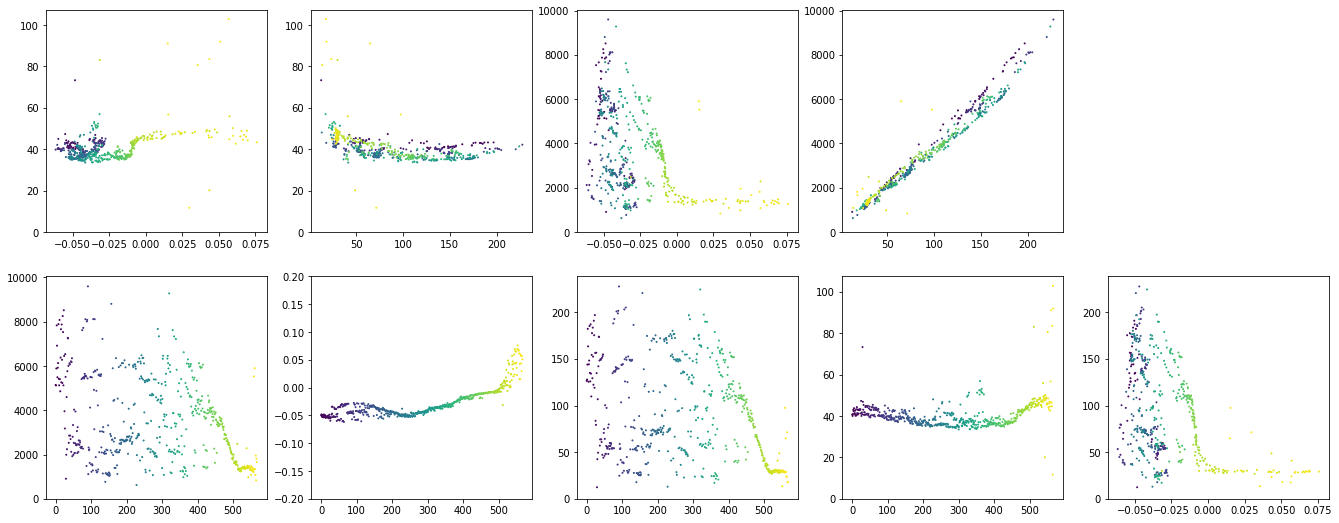

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 639/639 [00:01<00:00, 326.64it/s]


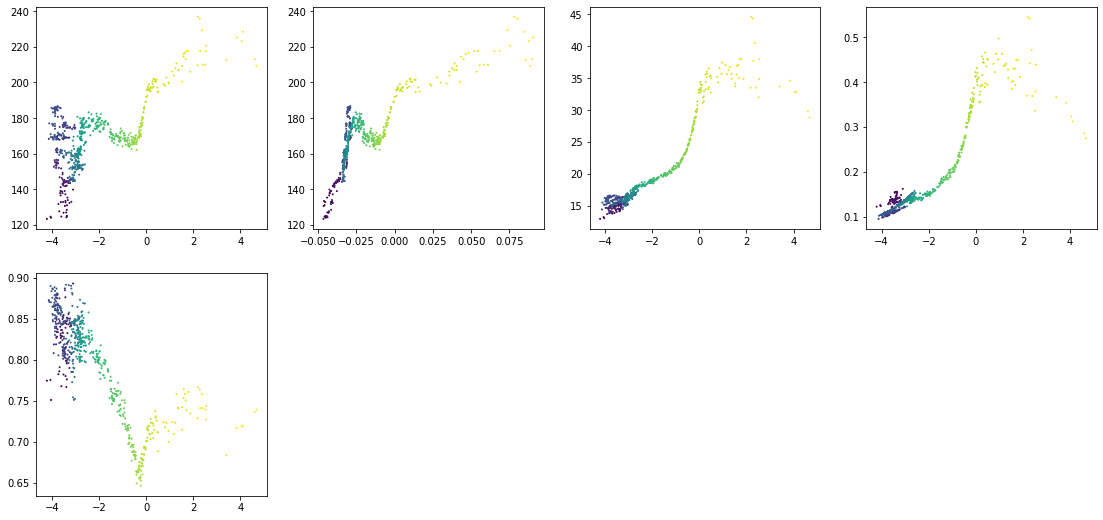

In [1226]:
# get correlation of the cell density and divergence.
bottom = 250
p = 170
w = 20
reference_shift = 50
layer_start = p; layer_end = p+w
# divergence_func = get_divergence_func(clf.coef_,poly.powers_)
length_list = []
flux_list = []
dense_list = []
reference_dense_list = []
radius = 10
for i, seed_num in tqdm(list(enumerate(seed_choice))):
    virtual_rg = virtual_rgs[seed_num]
    
    positions = virtual_rg.trajectory.ode_solution.y.T
    
    # curve length from the bottom
    dist = np.linalg.norm(np.diff(positions,axis=0,prepend=0),ord=2,axis=1)
    if dist.size <= bottom:
        continue
        
    cond1 = (pos_disp[:,i]>=layer_start) * (pos_disp[:,i]<bottom)
    cond1 = cond1[:dist.size]
    # cond2 = (pos_disp[:,i]>=layer_start) * (pos_disp[:,i]<layer_end)
    # cond2 = cond2[:dist.size]
    length_list.append(dist[cond1].sum())

    # get flow on the postion
    # cond = (pos_disp[:,i]>=layer_start) * (pos_disp[:,i]<layer_end)
    flow = flow_on_coordinate(positions, degree, clf) # flow is normalized

    flux_points_norm = position_on_circunference(radius, n_points=8, dim=3)

    flux_points = rotate_with_normals(flux_points_norm, flow)
    translated_flux_points = flux_points + positions

    temp = flow_on_coordinate(translated_flux_points.reshape(-1, translated_flux_points.shape[-1]), degree, clf)
    flux_vecs = temp.reshape(translated_flux_points.shape)

    flux = np.einsum('ijk,ijk->j', flux_vecs, flux_points/radius) / flux_points_norm.shape[0]
    # cond = cond[:flux.size]
    # flux_list.append(np.mean(flux[cond1]))
    flux_dist = flux * dist
    flux_list.append(flux_dist[cond1].sum())
    
    dense_list.append(np.mean(pos_disp[layer_start:layer_end,i]))
    reference_dense_list.append(np.mean(pos_disp[layer_start+reference_shift:layer_start+reference_shift+20,i]))
    
reference_density = np.asarray(reference_dense_list)
length_np = np.asarray(length_list)
flux_np = np.asarray(flux_list)
dense_np = np.asarray(dense_list)#pos_disp[layer_start:layer_end,:].mean(axis=0)
fig = plt.figure(figsize=(19,9))
fig.add_subplot(2,4,1)
plt.scatter(flux_np,dense_np,s=1, c=np.arange(flux_np.size))
fig.add_subplot(2,4,2)
plt.scatter(flux_np/length_np,dense_np,s=1, c=np.arange(flux_np.size))
fig.add_subplot(2,4,3)
plt.scatter(flux_np,dense_np/np.sqrt(length_np),s=1, c=np.arange(flux_np.size))
fig.add_subplot(2,4,4)
plt.scatter(flux_np,np.sqrt(dense_np)/length_np,s=1, c=np.arange(flux_np.size))
# const = 10.
fig.add_subplot(2,4,5)
plt.scatter(flux_np,dense_np/reference_density,s=1, c=np.arange(flux_np.size))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 568/568 [00:02<00:00, 265.65it/s]


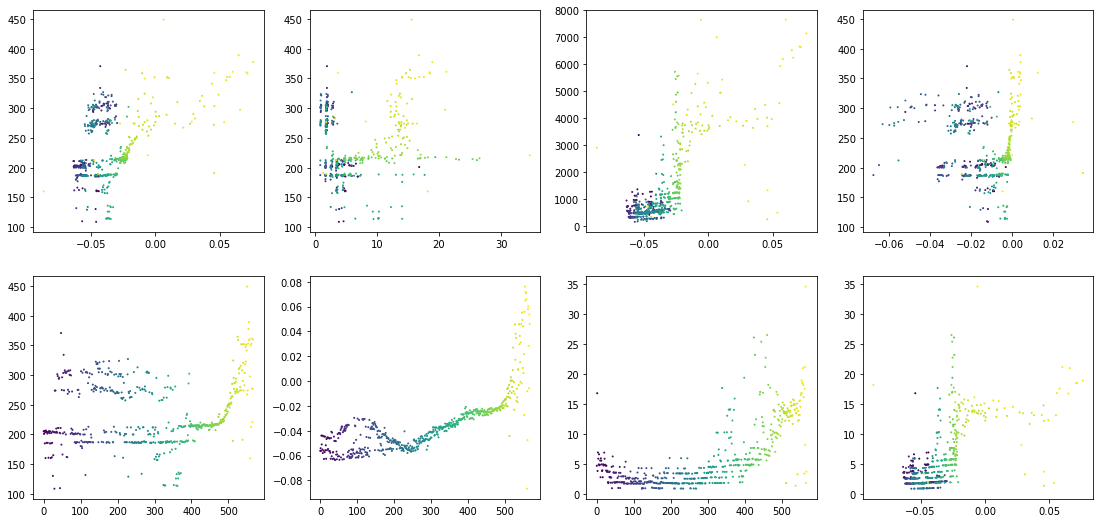

In [ ]:
# l = 10
# fft_threshold = 1e4
# gamma=1

# pos_disp, pos_np, _ = line_wise_dtw_aligner(std_values, initial_displacement, l, fft_threshold=fft_threshold, gamma=gamma)

# pos_disp_df = pd.DataFrame(pos_disp.T,index=seed_choice,dtype=int)
# pos_np_df = pd.DataFrame(pos_np.T,index=seed_choice,dtype=int)

# column_conv_np = initial_displacement

# coords = np.meshgrid(*[range(x) for x in pos_np.shape], indexing='ij')
# coords = np.array(coords).astype(np.int16)
# coords[0,:,:] = pos_np

# fix_deform = map_coordinates(column_conv_np, coords, order=1, mode='constant') # transform fix for better interpretation.
# fix_deform_df = pd.DataFrame(fix_deform.T,index=seed_choice)
# coords[0,:,:] = pos_disp
# mov_deform = map_coordinates(std_np, coords, order=1, mode='constant') # transform fix for better interpretation.
# mov_deform2 = mov_deform.copy()
# # mov_deform2[:,mi < thresh]=0

# mi = [mutual_information(column_conv_np[:,i], mov_deform[:,i],bins=128) for i in range(column_conv_np.shape[1])]
# mi = pd.Series(mi,index=seed_choice)

# plt.hist(mi,bins=100)
# thresh = threshold_otsu(mi)
# print(thresh)

# viewer = napari.Viewer()
# viewer.add_image(std_np, rgb=False, name='std', colormap='green', blending='additive', visible=False)
# viewer.add_image(fix_deform, rgb=False, name='deformed', colormap='magenta', blending='additive')
# viewer.add_image(column_conv_np, rgb=False, name='before', colormap='green', blending='additive')
# viewer.add_image(mov_deform2, rgb=False, name='std_deformed', colormap='green', blending='additive')
# viewer.add_image(pos_disp, rgb=False, name='pos_disp', colormap='magenta', blending='additive', visible=False)


In [ ]:
# %%time
# # try 2 dimensional pydeform
# # set path for log file
# log_file = os.path.join(io_directory,'deform_01.log')

# # convert to itk image for registration
# fix_l_itk = sitk.Cast(sitk.GetImageFromArray(initial_displaced_tar2std[np.newaxis,:,:]),sitk.sitkFloat32) # itk convert numpy zyx to xyz
# mov_l_itk = sitk.Cast(sitk.GetImageFromArray(standard[np.newaxis,:,:]),sitk.sitkFloat32)


# df_sitk = pydeform.register(
#     fix_l_itk,
#     mov_l_itk,
#     # fixed_landmarks=target_landmark_coords_,
#     # moving_landmarks=std_landmark_coords_,
#     settings=settings,
#     log=log_file,
#     log_level=pydeform.LogLevel.Verbose,
#     num_threads=60,
#     use_gpu=True
# )

# displacement = sitk.GetArrayFromImage(df_sitk)[0,:,:,1] #pos = sitk.GetArrayFromImage(df_sitk)[:,0,0,2]

In [ ]:
# def line_wise_aligner(std, target, initial_displacement, settings):
#     pos_np = np.zeros_like(target)
#     f = interpolate.interp1d(np.arange(std.size), std, bounds_error=False, fill_value='extrapolate')

#     for line in tqdm(range(target.shape[1])):
#         # load initial_displacement
#         shift = initial_displacement[:,line]
        
#         # initial transform for the registration
#         std_shift = f(np.arange(shift.size)-shift)

#         # run pydeform line by line
#         target_np = target[:,line]
        
#         # convert to itk image for registration
#         fix_l_itk = sitk.Cast(sitk.GetImageFromArray(target_np[:, np.newaxis, np.newaxis]),sitk.sitkFloat32)
#         mov_l_itk = sitk.Cast(sitk.GetImageFromArray(std_shift[:, np.newaxis, np.newaxis]),sitk.sitkFloat32)

#         df_sitk = pydeform.register(
#             fix_l_itk,
#             mov_l_itk,
#             settings=settings,
#             num_threads=60,
#             use_gpu=True
#         )

#         pos = sitk.GetArrayFromImage(df_sitk)[:,0,0,2]
#         pos_np[:,line] = pos - shift
        
#     return pos_np

# pos_np = line_wise_aligner(std_values, column_conv_np, initial_displacement, settings)

# coords = np.meshgrid(*[range(x) for x in pos_np.shape], indexing='ij')
# coords = np.array(coords).astype(np.int16)
# pos_disp = coords[0,:,:]+pos_np
# coords[0,:,:] = coords[0,:,:]-pos_np

# fix_deform = map_coordinates(column_conv_np, coords, order=1, mode='constant') # transform fix for better interpretation.

# viewer = napari.Viewer()
# viewer.add_image(std_np, rgb=False, name='std', colormap='green', blending='additive', visible=False)
# viewer.add_image(fix_deform, rgb=False, name='deformed', colormap='magenta', blending='additive')
# viewer.add_image(column_conv_np, rgb=False, name='before', colormap='green', blending='additive')
# viewer.add_image(pos_disp, rgb=False, name='pos_disp', colormap='magenta', blending='additive', visible=False)
# # viewer.add_image(pos_disp_fft, rgb=False, name='pos_disp_fft', colormap='magenta', blending='additive', visible=False)

# # Do Fourier to remove the low frequency
# from virtualRG import utils
# pos_disp_fft = utils.fourier_masker_hamming(pos_disp, val=1, size=50)
# pos_disp_fft[0:13,:] = pos_disp[0:13,:]

# pos_disp_large = pos_disp#resize(pos_disp_fft, column_conv_np_.shape, preserve_range=True)

# from skimage import io

# io.imsave('/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/alignment/nuc.tif',autofl)

In [ ]:
# sitk.WriteImage(fix_l_itk, os.path.join(io_directory,'fix.nrrd'))
# sitk.WriteImage(mov_l_itk, os.path.join(io_directory,'mov.nrrd'))

# fix_l_itk = pyd.read_volume(os.path.join(io_directory,'fix.nrrd'))
# mov_l_itk = pyd.read_volume(os.path.join(io_directory,'mov.nrrd'))

# df_sitk = pyd.register(
#     fix_l_itk,
#     mov_l_itk,
#     fixed_landmarks=target_landmark_coords_,
#     moving_landmarks=std_landmark_coords_,
#     settings=settings,
#     log=log_file,
#     log_level=pydeform.LogLevel.Verbose,
#     num_threads=60,
#     use_gpu=True
# )

# pyd.write_volume(os.path.join(io_directory,'result.nrrd'), df_sitk)

# df = sitk.ReadImage(os.path.join(io_directory,'result.nrrd'))
# displacement = sitk.GetArrayFromImage(df)[0,:,:,1]
# displacement.shape

In [ ]:
# # sparse 3D strategy did not work well. The deformation is not that flexible.
# # giving landmarks did not help at all. hmm.

# # prepare tuv image with FFT denoising.
# fft_threshold = 1e3

# # make tuv image
# tuv_target = np.zeros((time_end+1,) + tuple(translate_manifold2D.max(axis=0).astype(int)+1)) # tuv order.
# tuv_std = np.zeros_like(tuv_target)

# std_seed = 4724
# std = column_conv.loc[std_seed].to_numpy()
# std_fft = filter_signal(std, threshold=fft_threshold)

# for i, seed_num in tqdm(list(enumerate(column_conv.index.to_list()))):
#     # get uv coordinates
#     uv = translate_manifold2D_df.loc[seed_num,:].astype(int)
#     u = uv[0]; v = uv[1]
#     # count the number of cells in a disk along the line
#     tuv_target[:,u,v] = filter_signal(column_conv.loc[seed_num].to_numpy(), threshold=fft_threshold)#conv_along_line(half_thickness, positions, flow, coords_tree, radius, time_end+1)
#     tuv_std[:,u,v] = std_fft

# tuv_std_full = np.repeat(std_fft[:,np.newaxis,np.newaxis],tuv_std.shape[1],axis=1)
# tuv_std_full = np.repeat(tuv_std_full,tuv_std.shape[2],axis=2)

# viewer = napari.Viewer()
# viewer.add_image(tuv_target, rgb=False, name='target', colormap='magenta', blending='additive', multiscale=False)
# viewer.add_image(tuv_std, rgb=False, name='standard', colormap='green', blending='additive', multiscale=False)
# viewer.add_image(tuv_std_full, rgb=False, name='standard', colormap='green', blending='additive', multiscale=False)
# #labels = viewer.add_labels(np.zeros_like(tuv_target.astype(int)), name='labeling')

# # process landmarks

# # make initial displacement using manual labels.
# labels_np = labels.data

# std_landmark = np.array([0,38,140,252]) # these are fixed numbers.
# std_landmark_coords = []
# target_landmark_coords = []

# uv_coords = translate_manifold2D_df.astype(int)

# for seed_num in seed_choice:

#     uv = uv_coords.loc[seed_num,:].to_numpy()
#     label_line = labels_np[:,uv[0],uv[1]]
    
#     if label_line.sum()>1:
#         for i in range(1, std_landmark.size):
#             # make landmarks of target
#             landmark_t = std_landmark.copy()
#             positions = np.where(label_line==i)[0]
#             if positions.size != 0:
#                 landmark_t[i] = round(positions.mean())
#             else:
#                 landmark_t[i] = std_landmark[i]
#         landmark_u = np.full(landmark_t.size,uv[0])
#         landmark_v = np.full(landmark_t.size,uv[1])

#         std_landmark_coords.append(np.vstack([landmark_v,landmark_u,std_landmark]).T)
#         target_landmark_coords.append(np.vstack([landmark_v,landmark_u,landmark_t]).T)
        
# target_landmark_coords_ = np.asarray(target_landmark_coords)
# target_landmark_coords_ = target_landmark_coords_.reshape(-1, target_landmark_coords_.shape[-1])

# std_landmark_coords_ = np.asarray(std_landmark_coords)
# std_landmark_coords_ = std_landmark_coords_.reshape(-1, std_landmark_coords_.shape[-1])

In [ ]:
# # set parameters
# settings = {
#     'pyramid_levels':6, # larger number can deteriorate the initial alignment.
#     'pyramid_stop_level': 3, # 1 is good. 2 is just enough, 3 is not enough. 
#     # 'landmarks_weight': 1.0,
#     # 'landmarks_stop_level': 0,
#     'step_size': [1.0, 1.0, 1.0], # [1.0,1.0,1.0] seems enough. more than that will degrade the quality
#     'block_size': [32,32,32],#[512,512,512],
#     'block_energy_epsilon':1e-7,
#     'max_iteration_count':100,
#     'constraints_weight':1000.0,
#     'regularization_weight': 0.15, # default 0.25
#     'regularization_scale': 1.0, # default 1.0
#     'regularization_exponent': 2.0, # default 2.0
#     'image_slots':[{
#             'resampler': 'gaussian',
#             'normalize': True,
#             'cost_function':[
#                 {
#                     'function':'ncc',
#                     'weight':1.0,
#                     'radius':7
#                 }
#             ]
#         }]
# }

# %%time
# # try 2 dimensional pydeform
# # set path for log file
# log_file = os.path.join(io_directory,'deform_01.log')

# # convert to itk image for registration
# fix_l_itk = sitk.Cast(sitk.GetImageFromArray(tuv_std_full),sitk.sitkFloat32) # itk convert numpy zyx to xyz
# mov_l_itk = sitk.Cast(sitk.GetImageFromArray(tuv_target),sitk.sitkFloat32)


# df_sitk = pydeform.register(
#     fix_l_itk,
#     mov_l_itk,
#     settings=settings,
#     log=log_file,
#     log_level=pydeform.LogLevel.Verbose,
#     num_threads=60,
#     use_gpu=True
# )

# mov_l_deform_itk = pydeform.transform(mov_l_itk,df_sitk)

# viewer = napari.Viewer()
# viewer.add_image(tuv_target, rgb=False, name='fix', colormap='turbo', blending='additive')
# viewer.add_image(tuv_std_full, rgb=False, name='mov_affine', colormap='blue', blending='additive',visible=False)
# viewer.add_image(sitk.GetArrayFromImage(mov_l_deform_itk), rgb=False, name='mov_deform', colormap='gray', blending='additive')

In [269]:
# # make initial displacement using manual labels.
# labels_np = labels.data

# initial_displacement = np.zeros_like(std_np)

# std_landmark = np.array([0,38,138,252,std_np.shape[0]]) # these are fixed numbers.
# target_landmarks = [] 
# for line in range(std_np.shape[1]):
#     # make landmarks_fix
#     landmark = std_landmark.copy()
#     for i in range(1, std_landmark.size-1):
#         positions = np.where(labels_np[:,line]==i)[0]
#         if positions.size != 0:
#             landmark[i] = round(positions.mean())
#         else:
#             landmark[i] = std_landmark[i]
#     target_landmarks.append(landmark)
#     # # make manually generated position shift
#     # coord = np.arange(column_conv_np.shape[0])
#     # shift = interpolate.griddata(landmarks_mov,landmarks_fix-landmarks_mov,xi=coord,method='cubic') # cubic distort the thing...
#     # initial_displacement[:,line] = shift


LinearRegression(fit_intercept=False)

In [ ]:
'''try simple itk bspline and point transformation'''
# # https://simpleitk.readthedocs.io/en/v1.2.3/Examples/ImageRegistrationMethodBSpline3/Documentation.html
# # https://simpleitk.org/SPIE2019_COURSE/04_basic_registration.html

# def command_iteration(method, bspline_transform) :
#     if method.GetOptimizerIteration() == 0:
#         # The BSpline is resized before the first optimizer
#         # iteration is completed per level. Print the transform object
#         # to show the adapted BSpline transform.
#         print(bspline_transform)


#     print("{0:3} = {1:10.5f}".format(method.GetOptimizerIteration(),
#                                      method.GetMetricValue()))



# def command_multi_iteration(method) :
#     # The sitkMultiResolutionIterationEvent occurs before the
#     # resolution of the transform. This event is used here to print
#     # the status of the optimizer from the previous registration level.
#     if R.GetCurrentLevel() > 0:
#         print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
#         print(" Iteration: {0}".format(R.GetOptimizerIteration()))
#         print(" Metric value: {0}".format(R.GetMetricValue()))

#     print("--------- Resolution Changing ---------")

# fixed = sitk.Cast(sitk.GetImageFromArray(sorted_column_conv),sitk.sitkFloat32) # itk convert numpy zyx to xyz
# moving = sitk.Cast(sitk.GetImageFromArray(std_np),sitk.sitkFloat32)

# # fixed = sitk.ReadImage(sys.argv[1], sitk.sitkFloat32)
# # moving = sitk.ReadImage(sys.argv[2], sitk.sitkFloat32)
# transformDomainMeshSize=[2]*fixed.GetDimension()
# tx = sitk.BSplineTransformInitializer(fixed,
#                                       transformDomainMeshSize )

# R = sitk.ImageRegistrationMethod()
# R.SetMetricAsJointHistogramMutualInformation()
# R.SetOptimizerAsGradientDescentLineSearch(5.0,
#                                           100,
#                                           convergenceMinimumValue=1e-4,
#                                           convergenceWindowSize=5)

# R.SetInterpolator(sitk.sitkLinear)
# R.SetInitialTransformAsBSpline(tx,
#                                inPlace=True,
#                                scaleFactors=[1,2,5])
# R.SetShrinkFactorsPerLevel([16,8,4])
# R.SetSmoothingSigmasPerLevel([16,8,4])

# R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R, tx) )
# R.AddCommand( sitk.sitkMultiResolutionIterationEvent, lambda: command_multi_iteration(R) )

# outTx = R.Execute(fixed, moving)

# # print("-------")
# # print(tx)
# # print(outTx)
# # print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
# # print(" Iteration: {0}".format(R.GetOptimizerIteration()))
# # print(" Metric value: {0}".format(R.GetMetricValue()))

# resampler = sitk.ResampleImageFilter()
# resampler.SetReferenceImage(fixed);
# resampler.SetInterpolator(sitk.sitkLinear)
# resampler.SetDefaultPixelValue(100)
# resampler.SetTransform(outTx)

# out = resampler.Execute(moving)
# simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
# simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
# cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)

# plt.imshow(sitk.GetArrayFromImage(simg2))

In [387]:
# convolve the cell count along the growthline.

half_thickness = 1. # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer

# prepare column cell number convolution
seed_choice = manifold_1D_df.index.to_list()[::downsample]
column_conv_np2 = np.zeros((time_end+1, len(seed_choice)))
initial_displacement2 = np.zeros_like(std_np)
grad_field = get_gradient_func(clf2.coef_,poly.powers_)

# column cell number convolution
for i, seed_num in tqdm(list(enumerate(seed_choice))):
    virtual_rg = virtual_rgs[seed_num]

    # get position of a line as 1D array.
    positions = virtual_rg.trajectory.ode_solution.y.T
    # get flow on the postion
    gradient = grad_field(positions.T)
    flow = (gradient / np.sqrt((gradient**2).sum(axis=0))).T # normalization of the gradient
    # flow = flow_on_coordinate(positions, degree, clf)
    
    # calculate displacement after fitting
    positional_displacement = clf2.predict(poly.fit_transform(positions))
    shift = np.arange(positional_displacement.size) - positional_displacement # convert to the relative shift. Be aware of the sign.
    # shift[~virtual_rg.trajectory.inloc] = 0 # remove the information outside of the tissue.
    shift = np.pad(shift, (0, time_end+1-shift.size), 'constant', constant_values=(0, 0))
    initial_displacement2[:,i] = shift
    
    # count the number of cells in a disk along the line
    column_conv_np2[:, i] = conv_along_line(half_thickness, positions, flow, coords_tree, radius, time_end+1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 639/639 [00:48<00:00, 13.31it/s]


In [388]:
viewer = napari.Viewer()
viewer.add_image(column_conv_np, rgb=False, name='before', colormap='green', blending='additive') #contrast_limits=[-100,100], 
viewer.add_image(column_conv_np2, rgb=False, name='deformed', colormap='magenta', blending='additive')

<Image layer 'deformed' at 0x7ee6e9e33490>

In [285]:
pos_np2 = line_wise_aligner(std_values, column_conv_np2, initial_displacement2, settings)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 639/639 [00:35<00:00, 18.07it/s]


In [291]:
coords = np.meshgrid(*[range(x) for x in pos_np2.shape], indexing='ij')
coords = np.array(coords).astype(np.int16)
coords[0,:,:] = coords[0,:,:]-pos_np2

fix_deform2 = map_coordinates(column_conv_np2, coords, order=1, mode='constant') # transform fix for better interpretation.

viewer = napari.Viewer()
viewer.add_image(std_np, rgb=False, name='before', colormap='green', blending='additive')
viewer.add_image(fix_deform2, rgb=False, name='deformed2', colormap='magenta', blending='additive')

coords = np.meshgrid(*[range(x) for x in pos_np.shape], indexing='ij')
coords = np.array(coords).astype(np.int16)
coords[0,:,:] = coords[0,:,:]-pos_np

fix_deform = map_coordinates(column_conv_np, coords, order=1, mode='constant') # transform fix for better interpretation.
viewer.add_image(fix_deform, rgb=False, name='deformed1', colormap='magenta', blending='additive')

<Image layer 'deformed1' at 0x7ee70a6e3520>

In [ ]:
# uvt = column_conv_np[column_conv_np.sum(axis=1)!=0].T
# std_values = uvt[:,547]
# uvt_std = np.repeat(std_values[:,np.newaxis],uvt.shape[1],axis=1)
# viewer = napari.Viewer()
# viewer.add_image(uvt, rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)
# viewer.add_image(uvt_std, rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)

In [ ]:
# umap approach failed

# import umap


# column_conv_pos = column_conv.copy()
# column_conv_pos[['x0','x1','x2']] = seeds_df.reindex(column_conv.index)[['x0','x1','x2']]*10

# # sort vectors using values of the vector, not based on xyz coordinate
# reducer = umap.UMAP(n_components=1)
# embedding = reducer.fit_transform(column_conv_pos)
# # make series to sort lines
# sorter = pd.Series(embedding.flatten(),index=column_conv.index)
# sorter = sorter.sort_values()

# sorted_lines = column_conv.reindex(sorter.index)
# viewer = napari.Viewer()
# viewer.add_image(sorted_lines.to_numpy().T, rgb=False, name='before', colormap='gray', blending='additive', multiscale=False)

In [ ]:
'''medoid picking'''

In [ ]:
# def pick_median_nearest_point(array, r, median_shift=True):
#     """
#     Find points which are within a certain distance (r) to the median point. If median_shift is true, the point closest to the median is used as a center of kNN.  
#     Input:
#         array: ndarray. 3D coordinate of points. 
#         r: int. number of neighbors
#         median_shift: boolean
#     Output:
#         index: index (row) of the nearest neighbor       
#     """
#     if not isinstance(array, np.ndarray):
#         array = np.array(array)
    
#     kd_tree = spatial.KDTree(array)
#     median = np.median(array,axis=0)
#     if median_shift:
#         _, i = kd_tree.query(median, 1)
#         median_nn = array[i,:]
#         index = kd_tree.query_ball_point(median,r)
#     else:
#         index = kd_tree.query_ball_point(median,r)
        
#     return index

In [ ]:
# # To avoid picking short fibers as a representitive, limit the area around median center point.
# # Select the seeds for analysis.
# seed_choice = seeds_df.index[seeds_df.iloc[:,3:6].all(axis=1)].tolist() # seeds_df.iloc[:,3:]
# seeds_df2 = seeds_df.loc[seed_choice,:]#.iloc[:,:3]

# # Find seeds around a median point.
# center_seeds = seeds_df2.iloc[pick_median_nearest_point(seeds_df2,20),:] # Consider voxel size.

# # Choose the exemplar seed.
# X = np.array([virtual_rgs[seed_num].trajectory.values_on_trajectory for seed_num in center_seeds.index.tolist()])
# medoids = KMedoids(n_clusters=1, random_state=0).fit(X) # n_cluster = 1
# medoids_idx = center_seeds.iloc[medoids.medoid_indices_,:].index.tolist()
# medoid_idx = medoids_idx[0]
# virtual_rg_medoid = virtual_rgs[medoid_idx]
# print(virtual_rg_medoid.seed_position)
# # Plot for QC.
# fig = plt.figure(figsize=(16,3))
# fig.add_subplot(1,1,1)
# for med in medoids_idx:
#     plt.plot(virtual_rgs[med].trajectory.values_on_trajectory)

In [ ]:
# # manually define position of interest.
# pos = (214,347,435)#(222,468,372)#(156,512,376)
# medoid_idx = ((seeds_df['x0']-pos[0])**2 + (seeds_df['x1']-pos[1])**2 + (seeds_df['x2']-pos[2])**2).idxmin()
# virtual_rg_medoid = virtual_rgs[medoid_idx]
# print(virtual_rg_medoid.seed_position)
# # Plot for QC.
# fig = plt.figure(figsize=(16,3))
# fig.add_subplot(1,1,1)
# plt.plot(virtual_rg_medoid.trajectory.values_on_trajectory)

In [ ]:
'''manihold 1D'''

In [171]:
# %%time
# seed_choice = seeds_df.index[seeds_df.iloc[:,4:6].all(axis=1)].tolist()
# # https://benalexkeen.com/isomap-for-dimensionality-reduction-in-python/
# X0 = seeds_df.loc[seed_choice,:].iloc[:,0:3] / marching_step_size
# X0_sampled = X0.sample(frac=0.01, replace=False, random_state=1) # downsample for faster computation
# iso = manifold.Isomap(n_neighbors=20, n_components=1, n_jobs=-1)
# iso.fit(X0_sampled)
# manifold_1D = iso.transform(X0)

CPU times: user 53.3 s, sys: 10.4 s, total: 1min 3s
Wall time: 30.7 s


In [37]:
# # Translate u corrdinate to make 2D image 
# manifold_1D = ((manifold_1D-manifold_1D.min())/(manifold_1D.max()-manifold_1D.min()))*manifold_1D.size
# translate_position_grid_df = pd.DataFrame(np.round_(manifold_1D,decimals=0).astype(int),index=X0.index,columns=['u']) # This may need optimization. Grid step is fixed to be 1.
# selected_uv_df = translate_position_grid_df[~translate_position_grid_df.duplicated(keep='first')] # Remove if duplicated. 
# duplication_table = generate_duplication_table(translate_position_grid_df) # Duplication correspondance table to retrieve removed seeds.
# print((duplication_table.index != duplication_table).sum()) # Print mean number of duplication. The smaller the better.
# print(duplication_table.size)

89106
223421


In [234]:
# # Make 2D image in ut space
# uvt = np.zeros([time_end+1] + (selected_uv_df.max(axis=0)+1).to_list(),dtype=float) # Make zeros array to reconstruct the 3D image  
# for seed_num in selected_uv_df.index.tolist():
#     virtual_rg = virtual_rgs[seed_num]
#     u = selected_uv_df.loc[seed_num,:].iloc[0]
#     values_on_trajectory = virtual_rg.trajectory.values_on_trajectory
#     values_on_trajectory = np.pad(values_on_trajectory, (0, time_end+1-values_on_trajectory.size), 'constant', constant_values=(0, 0))
#     uvt[:,u] = values_on_trajectory#virtual_rg.trajectory.values_on_trajectory
#     inloc = virtual_rg.trajectory.inloc
#     inloc = np.pad(inloc, (0, time_end+1-inloc.size), 'constant', constant_values=(False, False))
#     uvt[~inloc,u] = 0
    
# # Make 3D standard uvt image for registration
# std_values = virtual_rg_medoid.trajectory.values_on_trajectory
# std_values = np.pad(std_values, (0, time_end+1-std_values.size), 'constant', constant_values=(0, 0))
# uvt_std = np.repeat(std_values[:,np.newaxis],selected_uv_df.iloc[:,0].max(axis=0)+1,axis=1)

In [93]:
# %%time
# # Interpolate the image to fill the empty values
# uvt_interp = np.copy(uvt)
# nonzero_coord = np.argwhere(uvt!=0)
# zero_coord = np.argwhere(uvt==0)
# val = interpolate.griddata(nonzero_coord,uvt[tuple(nonzero_coord.T)],xi=zero_coord,method='nearest') # nearest extrapolates while linear not.
# uvt_interp[tuple(zero_coord.T)] = val

CPU times: user 1min 18s, sys: 1.1 s, total: 1min 19s
Wall time: 1min 18s


In [165]:
# viewer = napari.Viewer()
# viewer.add_image(uvt_interp[:,::200], contrast_limits=[0,2000], rgb=False, name='ut', colormap='magenta', blending='additive', multiscale=False)
# viewer.add_image(uvt_std[:,::200], contrast_limits=[0,2000], rgb=False, name='ut_standard', colormap='green', blending='additive', multiscale=False)

<Image layer 'ut_standard' at 0x7fc583f68520>

In [94]:
# from skimage import io
# io.imsave(os.path.join(io_directory,'2D_ut5.tif'),uvt_interp[:,::200])
# io.imsave(os.path.join(io_directory,'2D_ut_std5.tif'),uvt_std[:,::200])

In [315]:
# displacement_field = io.imread('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/trash/ants_reg/disp_1D_ver2.tif')

In [382]:
# # write aligned time information onto fiber, and export as image
# flow_img = np.zeros_like(asma_downscale)
# for seed_num in translate_position_grid_df.index.tolist():
#     virtual_rg = virtual_rgs[seed_num]

#     duplicated_seed_num = duplication_table.loc[seed_num]
#     displacement = displacement_field[:,translate_position_grid_df.loc[duplicated_seed_num,'u']]

#     warp_pos = np.arange(displacement.size) + displacement
#     inloc = virtual_rg.trajectory.inloc.astype(float)
#     inloc = np.pad(inloc,(0, warp_pos.size-inloc.size), 'constant', constant_values=(0, 0))
#     position = virtual_rg.trajectory.ode_solution.y
#     position = np.pad(position,((0,0),(0, warp_pos.size-position.shape[1])), 'constant', constant_values=(0, 0))
    
#     # warp_pos = warp_pos * inloc
#     warp_pos[warp_pos<=0] = 0
#     flow_img = fill_value_in_range(flow_img,position,warp_pos)
# #imageio.mimwrite(os.path.join(io_directory,'info4_flow_inverse4.tif'),flow_img)

In [383]:
# %%time
# # Interpolate the image section by section. This is to fill the gap voxels which was not predicted.
# flow_interp = np.copy(flow_img)
# flag = 0
# for i in range(flow_img.shape[0]):
#     print(i)
#     flow_section = flow_interp[i,:,:]
#     nonzero_coord = np.argwhere(flow_section!=0)
#     if nonzero_coord.size == 0:
#         if i==0:
#             flow_interp[i,:,:] = 0
#         else:
#             flow_interp[i,:,:] = flow_interp[i-1,:,:]
#         if flag==0:
#             continue
#         else:
#             break
#     flag = 1
#     zero_coord = np.argwhere(flow_section==0)
#     val = interpolate.griddata(nonzero_coord,flow_section[tuple(nonzero_coord.T)],xi=zero_coord,method='linear') # nearest extrapolates while linear not.
#     flow_interp[tuple(np.vstack([np.full_like(zero_coord.T[0,:],i),zero_coord.T]))] = val
# # io.imsave(os.path.join(io_directory,'cortical_depth.tif'),flow_interp*segmented_tissue)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [1]:
# turbo_list = [[0.0,0.0,0.0],[0.19483,0.08339,0.26149],[0.19956,0.09498,0.29024],[0.20415,0.10652,0.31844],[0.20860,0.11802,0.34607],[0.21291,0.12947,0.37314],[0.21708,0.14087,0.39964],[0.22111,0.15223,0.42558],[0.22500,0.16354,0.45096],[0.22875,0.17481,0.47578],[0.23236,0.18603,0.50004],[0.23582,0.19720,0.52373],[0.23915,0.20833,0.54686],[0.24234,0.21941,0.56942],[0.24539,0.23044,0.59142],[0.24830,0.24143,0.61286],[0.25107,0.25237,0.63374],[0.25369,0.26327,0.65406],[0.25618,0.27412,0.67381],[0.25853,0.28492,0.69300],[0.26074,0.29568,0.71162],[0.26280,0.30639,0.72968],[0.26473,0.31706,0.74718],[0.26652,0.32768,0.76412],[0.26816,0.33825,0.78050],[0.26967,0.34878,0.79631],[0.27103,0.35926,0.81156],[0.27226,0.36970,0.82624],[0.27334,0.38008,0.84037],[0.27429,0.39043,0.85393],[0.27509,0.40072,0.86692],[0.27576,0.41097,0.87936],[0.27628,0.42118,0.89123],[0.27667,0.43134,0.90254],[0.27691,0.44145,0.91328],[0.27701,0.45152,0.92347],[0.27698,0.46153,0.93309],[0.27680,0.47151,0.94214],[0.27648,0.48144,0.95064],[0.27603,0.49132,0.95857],[0.27543,0.50115,0.96594],[0.27469,0.51094,0.97275],[0.27381,0.52069,0.97899],[0.27273,0.53040,0.98461],[0.27106,0.54015,0.98930],[0.26878,0.54995,0.99303],[0.26592,0.55979,0.99583],[0.26252,0.56967,0.99773],[0.25862,0.57958,0.99876],[0.25425,0.58950,0.99896],[0.24946,0.59943,0.99835],[0.24427,0.60937,0.99697],[0.23874,0.61931,0.99485],[0.23288,0.62923,0.99202],[0.22676,0.63913,0.98851],[0.22039,0.64901,0.98436],[0.21382,0.65886,0.97959],[0.20708,0.66866,0.97423],[0.20021,0.67842,0.96833],[0.19326,0.68812,0.96190],[0.18625,0.69775,0.95498],[0.17923,0.70732,0.94761],[0.17223,0.71680,0.93981],[0.16529,0.72620,0.93161],[0.15844,0.73551,0.92305],[0.15173,0.74472,0.91416],[0.14519,0.75381,0.90496],[0.13886,0.76279,0.89550],[0.13278,0.77165,0.88580],[0.12698,0.78037,0.87590],[0.12151,0.78896,0.86581],[0.11639,0.79740,0.85559],[0.11167,0.80569,0.84525],[0.10738,0.81381,0.83484],[0.10357,0.82177,0.82437],[0.10026,0.82955,0.81389],[0.09750,0.83714,0.80342],[0.09532,0.84455,0.79299],[0.09377,0.85175,0.78264],[0.09287,0.85875,0.77240],[0.09267,0.86554,0.76230],[0.09320,0.87211,0.75237],[0.09451,0.87844,0.74265],[0.09662,0.88454,0.73316],[0.09958,0.89040,0.72393],[0.10342,0.89600,0.71500],[0.10815,0.90142,0.70599],[0.11374,0.90673,0.69651],[0.12014,0.91193,0.68660],[0.12733,0.91701,0.67627],[0.13526,0.92197,0.66556],[0.14391,0.92680,0.65448],[0.15323,0.93151,0.64308],[0.16319,0.93609,0.63137],[0.17377,0.94053,0.61938],[0.18491,0.94484,0.60713],[0.19659,0.94901,0.59466],[0.20877,0.95304,0.58199],[0.22142,0.95692,0.56914],[0.23449,0.96065,0.55614],[0.24797,0.96423,0.54303],[0.26180,0.96765,0.52981],[0.27597,0.97092,0.51653],[0.29042,0.97403,0.50321],[0.30513,0.97697,0.48987],[0.32006,0.97974,0.47654],[0.33517,0.98234,0.46325],[0.35043,0.98477,0.45002],[0.36581,0.98702,0.43688],[0.38127,0.98909,0.42386],[0.39678,0.99098,0.41098],[0.41229,0.99268,0.39826],[0.42778,0.99419,0.38575],[0.44321,0.99551,0.37345],[0.45854,0.99663,0.36140],[0.47375,0.99755,0.34963],[0.48879,0.99828,0.33816],[0.50362,0.99879,0.32701],[0.51822,0.99910,0.31622],[0.53255,0.99919,0.30581],[0.54658,0.99907,0.29581],[0.56026,0.99873,0.28623],[0.57357,0.99817,0.27712],[0.58646,0.99739,0.26849],[0.59891,0.99638,0.26038],[0.61088,0.99514,0.25280],[0.62233,0.99366,0.24579],[0.63323,0.99195,0.23937],[0.64362,0.98999,0.23356],[0.65394,0.98775,0.22835],[0.66428,0.98524,0.22370],[0.67462,0.98246,0.21960],[0.68494,0.97941,0.21602],[0.69525,0.97610,0.21294],[0.70553,0.97255,0.21032],[0.71577,0.96875,0.20815],[0.72596,0.96470,0.20640],[0.73610,0.96043,0.20504],[0.74617,0.95593,0.20406],[0.75617,0.95121,0.20343],[0.76608,0.94627,0.20311],[0.77591,0.94113,0.20310],[0.78563,0.93579,0.20336],[0.79524,0.93025,0.20386],[0.80473,0.92452,0.20459],[0.81410,0.91861,0.20552],[0.82333,0.91253,0.20663],[0.83241,0.90627,0.20788],[0.84133,0.89986,0.20926],[0.85010,0.89328,0.21074],[0.85868,0.88655,0.21230],[0.86709,0.87968,0.21391],[0.87530,0.87267,0.21555],[0.88331,0.86553,0.21719],[0.89112,0.85826,0.21880],[0.89870,0.85087,0.22038],[0.90605,0.84337,0.22188],[0.91317,0.83576,0.22328],[0.92004,0.82806,0.22456],[0.92666,0.82025,0.22570],[0.93301,0.81236,0.22667],[0.93909,0.80439,0.22744],[0.94489,0.79634,0.22800],[0.95039,0.78823,0.22831],[0.95560,0.78005,0.22836],[0.96049,0.77181,0.22811],[0.96507,0.76352,0.22754],[0.96931,0.75519,0.22663],[0.97323,0.74682,0.22536],[0.97679,0.73842,0.22369],[0.98000,0.73000,0.22161],[0.98289,0.72140,0.21918],[0.98549,0.71250,0.21650],[0.98781,0.70330,0.21358],[0.98986,0.69382,0.21043],[0.99163,0.68408,0.20706],[0.99314,0.67408,0.20348],[0.99438,0.66386,0.19971],[0.99535,0.65341,0.19577],[0.99607,0.64277,0.19165],[0.99654,0.63193,0.18738],[0.99675,0.62093,0.18297],[0.99672,0.60977,0.17842],[0.99644,0.59846,0.17376],[0.99593,0.58703,0.16899],[0.99517,0.57549,0.16412],[0.99419,0.56386,0.15918],[0.99297,0.55214,0.15417],[0.99153,0.54036,0.14910],[0.98987,0.52854,0.14398],[0.98799,0.51667,0.13883],[0.98590,0.50479,0.13367],[0.98360,0.49291,0.12849],[0.98108,0.48104,0.12332],[0.97837,0.46920,0.11817],[0.97545,0.45740,0.11305],[0.97234,0.44565,0.10797],[0.96904,0.43399,0.10294],[0.96555,0.42241,0.09798],[0.96187,0.41093,0.09310],[0.95801,0.39958,0.08831],[0.95398,0.38836,0.08362],[0.94977,0.37729,0.07905],[0.94538,0.36638,0.07461],[0.94084,0.35566,0.07031],[0.93612,0.34513,0.06616],[0.93125,0.33482,0.06218],[0.92623,0.32473,0.05837],[0.92105,0.31489,0.05475],[0.91572,0.30530,0.05134],[0.91024,0.29599,0.04814],[0.90463,0.28696,0.04516],[0.89888,0.27824,0.04243],[0.89298,0.26981,0.03993],[0.88691,0.26152,0.03753],[0.88066,0.25334,0.03521],[0.87422,0.24526,0.03297],[0.86760,0.23730,0.03082],[0.86079,0.22945,0.02875],[0.85380,0.22170,0.02677],[0.84662,0.21407,0.02487],[0.83926,0.20654,0.02305],[0.83172,0.19912,0.02131],[0.82399,0.19182,0.01966],[0.81608,0.18462,0.01809],[0.80799,0.17753,0.01660],[0.79971,0.17055,0.01520],[0.79125,0.16368,0.01387],[0.78260,0.15693,0.01264],[0.77377,0.15028,0.01148],[0.76476,0.14374,0.01041],[0.75556,0.13731,0.00942],[0.74617,0.13098,0.00851],[0.73661,0.12477,0.00769],[0.72686,0.11867,0.00695],[0.71692,0.11268,0.00629],[0.70680,0.10680,0.00571],[0.69650,0.10102,0.00522],[0.68602,0.09536,0.00481],[0.67535,0.08980,0.00449],[0.66449,0.08436,0.00424],[0.65345,0.07902,0.00408],[0.64223,0.07380,0.00401],[0.63082,0.06868,0.00401],[0.61923,0.06367,0.00410],[0.60746,0.05878,0.00427],[0.59550,0.05399,0.00453],[0.58336,0.04931,0.00486],[0.57103,0.04474,0.00529],[0.55852,0.04028,0.00579],[0.54583,0.03593,0.00638],[0.53295,0.03169,0.00705],[0.51989,0.02756,0.00780],[0.50664,0.02354,0.00863],[0.49321,0.01963,0.00955],[0.47960,0.01583,0.01055]]
# turbo_alpha = []
# for i, rgb in enumerate(turbo_list):
#     if i == 0:
#         turbo_alpha.append(rgb+[0.0])
#     else:
#         turbo_alpha.append(rgb+[1.0])
    
# turbo = Colormap(turbo_alpha)
# viewer = napari.Viewer()
# viewer.add_image((flow_interp*segmented_tissue), contrast_limits=[0,501], rgb=False, name='layer', colormap=turbo, blending='additive', multiscale=False)
# viewer.add_image((autofl*segmented_tissue), contrast_limits=[0,65535], rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False, visible=False)
# viewer.add_image(autofl_gauss, contrast_limits=[0,2000], rgb=False, name='auto_blur', colormap='gray', blending='additive', multiscale=False)
# viewer.add_image(asma_downscale, contrast_limits=[0,65535], rgb=False, name='asma', colormap='gray', blending='additive', multiscale=False, visible=False)

NameError: name 'Colormap' is not defined

In [272]:
from skimage import io
io.imsave(os.path.join(io_directory,'2D_ut_col.tif'),uvt)
io.imsave(os.path.join(io_directory,'2D_ut_std_col.tif'),uvt_std)

In [485]:
# # make initial displacement using manual labels.
# labels_np = labels.data

# initial_displacement = np.zeros_like(std_np)

# landmarks_mov = np.array([0,33,130,250,340,std_np.shape[0]]) # these are fixed numbers.
# for line in range(std_np.shape[1]):
#     # make landmarks_fix
#     landmarks_fix = landmarks_mov.copy()
#     for i in range(1, landmarks_mov.size-1):
#         positions = np.where(labels_np[:,line]==i)[0]
#         if positions.size != 0:
#             landmarks_fix[i] = round(positions.mean())
#         else:
#             landmarks_fix[i] = landmarks_mov[i]

#     # make manually generated position shift
#     coord = np.arange(column_conv_np.shape[0])
#     shift = interpolate.griddata(landmarks_mov,landmarks_fix-landmarks_mov,xi=coord,method='cubic') # cubic distort the thing...
#     initial_displacement[:,line] = shift
#     # if (np.diff(shift)<-1).sum()>0:
#     #     print(line, 'crazy is gonig on')


In [ ]:
# # set parameters
# settings = {
#     'pyramid_levels':2, # larger number can deteriorate the initial alignment.
#     'pyramid_stop_level': 0, # 1 is good. 2 is just enough, 3 is not enough. 
#     'step_size': [10.0, 10.0, 10.0], # [1.0,1.0,1.0] seems enough. more than that will degrade the quality
#     'block_size': [0,0,0],#[512,512,512],
#     'block_energy_epsilon':1e-7,
#     'max_iteration_count':-1,
#     'constraints_weight':1000.0,
#     'regularization_weight': 0.25, # default 0.25
#     'regularization_scale': 1.0, # default 1.0
#     'regularization_exponent': 2.0, # default 2.0
#     'image_slots':[{
#             'resampler': 'gaussian',
#             'normalize': True,
#             'cost_function':[
#                 {
#                     'function':'ncc',
#                     'weight':1.0,
#                     'radius':15
#                     # 'function': 'mi',
#                     # 'weight': 1.0,
#                     # 'sigma': 4.5,
#                     # 'bins': 256,
#                     # 'update_interval': 1,
#                     # 'interpolator': 'nearest'
#                 }
#             ]
#         }]
# }

# def line_wise_aligner(std, target, initial_displacement, settings):
#     pos_np = np.zeros_like(target)
#     f = interpolate.interp1d(np.arange(std.size), std, bounds_error=False, fill_value='extrapolate')

#     for line in tqdm(range(target.shape[1])):
#         # load initial_displacement
#         shift = initial_displacement[:,line]
        
#         # initial transform for the registration
#         std_shift = f(np.arange(shift.size)-shift)

#         # run pydeform line by line
#         target_np = target[:,line]
        
#         # convert to itk image for registration
#         fix_l_itk = sitk.Cast(sitk.GetImageFromArray(target_np[:, np.newaxis, np.newaxis]),sitk.sitkFloat32)
#         mov_l_itk = sitk.Cast(sitk.GetImageFromArray(std_shift[:, np.newaxis, np.newaxis]),sitk.sitkFloat32)

#         df_sitk = pydeform.register(
#             fix_l_itk,
#             mov_l_itk,
#             settings=settings,
#             num_threads=60,
#             use_gpu=True
#         )

#         pos = sitk.GetArrayFromImage(df_sitk)[:,0,0,2]
#         pos_np[:,line] = pos - shift
        
#     return pos_np

In [ ]:
# pos_np = line_wise_aligner(std_values, column_conv_np, initial_displacement, settings)

# coords = np.meshgrid(*[range(x) for x in pos_np.shape], indexing='ij')
# coords = np.array(coords).astype(np.int16)
# pos_disp = coords[0,:,:]+pos_np
# coords[0,:,:] = coords[0,:,:]-pos_np

# fix_deform = map_coordinates(column_conv_np, coords, order=1, mode='constant') # transform fix for better interpretation.

# viewer = napari.Viewer()
# viewer.add_image(std_np, rgb=False, name='std', colormap='green', blending='additive', visible=False)
# viewer.add_image(fix_deform, rgb=False, name='deformed', colormap='magenta', blending='additive')
# viewer.add_image(column_conv_np, rgb=False, name='before', colormap='green', blending='additive')
# viewer.add_image(pos_disp, rgb=False, name='pos_disp', colormap='magenta', blending='additive', visible=False)
# # viewer.add_image(pos_disp_fft, rgb=False, name='pos_disp_fft', colormap='magenta', blending='additive', visible=False)

# # Do Fourier to remove the low frequency
# from virtualRG import utils
# pos_disp_fft = utils.fourier_masker_hamming(pos_disp, val=1, size=50)
# pos_disp_fft[0:13,:] = pos_disp[0:13,:]

# pos_disp_large = pos_disp#resize(pos_disp_fft, column_conv_np_.shape, preserve_range=True)

# from skimage import io

# io.imsave('/home/tmurakami/src/misc_notebooks/human_nucleus_analysis/alignment/nuc.tif',autofl)

In [498]:
# for i, seed_num in enumerate(seed_choice):

#     virtual_rg = virtual_rgs[seed_num]
#     position = virtual_rg.trajectory.ode_solution.y
#     gradient = grad_field(position)
#     pos_img[tuple(position.astype(np.int32))] = abs(gradient.T)
    
# viewer = napari.Viewer()
# for i in range(3):
#     viewer.add_image(pos_img[...,i], rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)

CPU times: user 52.9 s, sys: 2.13 s, total: 55.1 s
Wall time: 54.4 s


<Image layer 'auto [1]' at 0x7fb092b0e2e0>

In [474]:
# all_coord = np.indices(asma_downscale.shape)
# all_coord = np.stack([all_coord[i,:,:,:].flatten() for i in range(dim)], axis=1).astype(int)
# all_coord_ = poly.fit_transform(all_coord)

# fit_img = clf2.predict(all_coord_)
# fit_img = fit_img.reshape(asma_downscale.shape)


In [91]:
# start alignment against the downsampled seeds
#seeds_df[seeds_df.index.isin(elem.index)].iloc[:,4:6].all(axis=1)
seed_choice = elem.index.intersection(seeds_df.index[seeds_df.iloc[:,4:6].all(axis=1)])
seed_choice = seed_choice.to_list()

X0 = seeds_df.loc[seed_choice,:].iloc[:,0:3] / marching_step_size
X0_sampled = X0.sample(frac=0.01, replace=False, random_state=1) # downsample for faster computation
iso = manifold.Isomap(n_neighbors=20, n_components=1, n_jobs=-1)
iso.fit(X0_sampled)
manifold_1D = iso.transform(X0)

manifold_1D = ((manifold_1D-manifold_1D.min())/(manifold_1D.max()-manifold_1D.min()))*manifold_1D.size
translate_position_grid_df = pd.DataFrame(np.round_(manifold_1D,decimals=0).astype(int),index=X0.index,columns=['u']) # This may need optimization. Grid step is fixed to be 1.
selected_uv_df = translate_position_grid_df[~translate_position_grid_df.duplicated(keep='first')] # Remove if duplicated. 
duplication_table = generate_duplication_table(translate_position_grid_df) # Duplication correspondance table to retrieve removed seeds.
print((duplication_table.index != duplication_table).sum()) # Print mean number of duplication. The smaller the better.
print(duplication_table.size)

3564
9720


In [94]:
# Make 2D image in ut space
uvt = np.zeros([time_end+1] + (selected_uv_df.max(axis=0)+1).to_list(),dtype=float) # Make zeros array to reconstruct the 3D image  
for seed_num in selected_uv_df.index.tolist():
    virtual_rg = virtual_rgs[seed_num]
    u = selected_uv_df.loc[seed_num,:].iloc[0]
    values_on_trajectory = virtual_rg.trajectory.values_on_trajectory
    values_on_trajectory = np.pad(values_on_trajectory, (0, time_end+1-values_on_trajectory.size), 'constant', constant_values=(0, 0))
    uvt[:,u] = values_on_trajectory#virtual_rg.trajectory.values_on_trajectory
    inloc = virtual_rg.trajectory.inloc
    inloc = np.pad(inloc, (0, time_end+1-inloc.size), 'constant', constant_values=(False, False))
    uvt[~inloc,u] = 0
    
# Make 3D standard uvt image for registration
std_values = virtual_rg_medoid.trajectory.values_on_trajectory
std_values = np.pad(std_values, (0, time_end+1-std_values.size), 'constant', constant_values=(0, 0))
uvt_std = np.repeat(std_values[:,np.newaxis],selected_uv_df.iloc[:,0].max(axis=0)+1,axis=1)

In [98]:
# Interpolate the image to fill the empty values
uvt_interp = np.copy(uvt)
nonzero_coord = np.argwhere(uvt!=0)
zero_coord = np.argwhere(uvt==0)
val = interpolate.griddata(nonzero_coord,uvt[tuple(nonzero_coord.T)],xi=zero_coord,method='nearest') # nearest extrapolates while linear not.
uvt_interp[tuple(zero_coord.T)] = val

CPU times: user 2.83 s, sys: 43.9 ms, total: 2.87 s
Wall time: 2.83 s


In [100]:
viewer = napari.Viewer()
viewer.add_image(uvt_interp, rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(uvt_std, rgb=False, name='auto', colormap='gray', blending='additive', multiscale=False)

<Image layer 'auto [1]' at 0x7f86ee042070>

In [101]:
from skimage import io
io.imsave(os.path.join(io_directory,'2D_ut_sel.tif'),uvt_interp[:,::10])
io.imsave(os.path.join(io_directory,'2D_ut_std_sel.tif'),uvt_std[:,::10])

In [115]:
# # Translate uv corrdinate to make 3D image 
# translate_position2D = manifold_2D - manifold_2D.min(axis=0)[np.newaxis,:]
# translate_position_grid_df2D = pd.DataFrame(np.round_(translate_position2D,decimals=0).astype(int),index=X0.index,columns=['v','u']) # This may need optimization. Grid step is fixed to be 1.
# selected_uv_df2D = translate_position_grid_df2D[~translate_position_grid_df2D.duplicated(keep='first')] # Remove if duplicated. 
# duplication_table2D = generate_duplication_table(translate_position_grid_df2D) # Duplication correspondance table to retrieve removed seeds.
# print((duplication_table2D.index != duplication_table2D).sum()) # Print mean number of duplication. The smaller the better.
# print(duplication_table2D.size)

In [259]:
# # Make 3D displacement image in uvt space
# uvt = np.zeros([time_end+1] + (selected_uv_df2D.max(axis=0)+1).to_list(),dtype=float) # Make zeros array to reconstruct the 3D image  
# for seed_num in selected_uv_df2D.index.tolist():
#     duplicated_seed_num = duplication_table.loc[seed_num]
#     displacement = displacement_field[:,translate_position_grid_df.loc[duplicated_seed_num,'u']]

#     virtual_rg = virtual_rgs[seed_num]
#     u = selected_uv_df2D.loc[seed_num,'u']
#     v = selected_uv_df2D.loc[seed_num,'v']
#     uvt[:,v,u] = displacement#virtual_rg.trajectory.values_on_trajectory    

In [295]:
# %%time
# uvt_fft = utils.fourier_masker_hamming(uvt,val=1,size=36)

CPU times: user 33.3 s, sys: 2.71 s, total: 36 s
Wall time: 35.5 s


In [292]:
# # Check image
# viewer = napari.Viewer()
# viewer.add_image(uvt, rgb=False, name='uvt', colormap='magenta', blending='additive', multiscale=False)
# viewer.add_image(uvt_fft, rgb=False, name='uvt_fft', colormap='green', blending='additive', multiscale=False)

<Image layer 'uvt_fft' at 0x7fc58750aeb0>

In [296]:
# # write aligned time information onto fiber, and export as image uvt ver
# flow_img = np.zeros_like(asma_downscale)
# for seed_num in translate_position_grid_df2D.index.tolist():
#     virtual_rg = virtual_rgs[seed_num]

#     duplicated_seed_num = duplication_table2D.loc[seed_num]
#     displacement = uvt_fft[:,translate_position_grid_df2D.loc[duplicated_seed_num,'v'],translate_position_grid_df2D.loc[duplicated_seed_num,'u']]

#     warp_pos = np.arange(displacement.size) + displacement
#     inloc = virtual_rg.trajectory.inloc.astype(float)
#     inloc = np.pad(inloc,(0, warp_pos.size-inloc.size), 'constant', constant_values=(0, 0))
#     position = virtual_rg.trajectory.ode_solution.y
#     position = np.pad(position,((0,0),(0, warp_pos.size-position.shape[1])), 'constant', constant_values=(0, 0))
    
#     warp_pos = warp_pos * inloc
#     flow_img = fill_value_in_range(flow_img,position,warp_pos)
# #imageio.mimwrite(os.path.join(io_directory,'info4_flow_inverse4.tif'),flow_img)

In [347]:
# from vispy.color import Colormap
# label_red = Colormap(['#000000', [1.0, 0.0, 0.0, 1.0]])

In [379]:
#

In [302]:
# %%time
# outprefix='/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/trash/ants_reg/tf'
# # https://antspyx.readthedocs.io/en/latest/ants.registration.html
# res = ants.registration(
#     uvt_interp_ants, uvt_std_ants,
#     type_of_transform='SyN', 
#     initial_transform=None, 
#     outprefix=outprefix, 
#     mask=None, 
#     grad_step=0.2, flow_sigma=3, total_sigma=0, 
#     aff_metric='mattes', aff_sampling=32, aff_random_sampling_rate=0.2, 
#     syn_metric='CC', syn_sampling=5, 
#     reg_iterations=(3000, 3000, 300, 0, 0), 
#     aff_iterations=(0,), aff_shrink_factors=(0,), aff_smoothing_sigmas=(0,), 
#     write_composite_transform=False, 
#     random_seed=None, 
#     verbose=False, 
#     multivariate_extras=None, 
#     restrict_transformation=(0,1)
# )

In [68]:
# warped= ants.apply_transforms(
#     fixed=uvt_interp_ants, moving=uvt_std_ants,
#     transformlist=res['fwdtransforms']
# )
# warped = warped.numpy()

# viewer = napari.Viewer()
# viewer.add_image(ut_interp[:,::100], contrast_limits=[0,2000], rgb=False, name='uvt', colormap='magenta', blending='additive', multiscale=False)
# viewer.add_image(warped, contrast_limits=[0,2000], rgb=False, name='std', colormap='green', blending='additive', multiscale=False)

<Image layer 'std' at 0x7f6afea166a0>

In [76]:
# warped= ants.apply_transforms(
#     fixed=uvt_std_ants, moving=uvt_interp_ants,
#     transformlist=res['invtransforms']
# )
# warped = warped.numpy()

# viewer = napari.Viewer()
# viewer.add_image(ut_interp[:,::100], contrast_limits=[0,2000], rgb=False, name='uvt', colormap='magenta', blending='additive', multiscale=False)
# viewer.add_image(warped, contrast_limits=[0,2000], rgb=False, name='std', colormap='green', blending='additive', multiscale=False)

<Image layer 'std' at 0x7f6aff5d2d90>

In [48]:
# # It is better to downsample to make even distribution.
# manifold_df = pd.DataFrame(manifold_1D,index=X0.index)
# bins = 1000
# binrange = np.arange(manifold_1D.min(),manifold_1D.max(),(manifold_1D.max()-manifold_1D.min())/(bins+1))
# even_selection = manifold_df.groupby(pd.cut(manifold_df[0], binrange)).sample(n=1, random_state=1)

# # Make 2D image in ut space
# ut = np.zeros([time_end+1,bins],dtype=float) # Make zeros array to reconstruct the 2D image  
# for u, seed_num in enumerate(even_selection.index.tolist()):
#     virtual_rg = virtual_rgs[seed_num]
#     values_on_trajectory = virtual_rg.trajectory.values_on_trajectory
#     values_on_trajectory = np.pad(values_on_trajectory, (0, time_end+1-values_on_trajectory.size), 'constant', constant_values=(0, 0))
#     ut[:,u] = values_on_trajectory#virtual_rg.trajectory.values_on_trajectory
#     inloc = virtual_rg.trajectory.inloc
#     inloc = np.pad(inloc, (0, time_end+1-inloc.size), 'constant', constant_values=(False, False))
#     ut[~inloc,u] = 0
    
# # Make 2D standard ut image for registration
# std_values = virtual_rg_medoid.trajectory.values_on_trajectory
# std_values = np.pad(std_values, (0, time_end+1-std_values.size), 'constant', constant_values=(0, 0))
# ut_std = np.repeat(std_values[:,np.newaxis],bins,axis=1)#

In [39]:
%%time
seed_choice = seeds_df.index[seeds_df.iloc[:,4:6].all(axis=1)].tolist()
# https://benalexkeen.com/isomap-for-dimensionality-reduction-in-python/
X0 = seeds_df.loc[seed_choice,:].iloc[:,0:3] / marching_step_size
X0_sampled = X0.sample(frac=0.01, replace=False, random_state=1)
iso = manifold.Isomap(n_neighbors=20, n_components=2, n_jobs=-1)
iso.fit(X0_sampled)
manifold_2Da = iso.transform(X0)

CPU times: user 59.2 s, sys: 12.5 s, total: 1min 11s
Wall time: 30.9 s


In [40]:
# Translate uv corrdinate to make 3D image 
translate_position = manifold_2Da - manifold_2Da.min(axis=0)[np.newaxis,:]
translate_position_grid_df = pd.DataFrame(np.round_(translate_position,decimals=0).astype(int),index=X0.index,columns=['v','u']) # This may need optimization. Grid step is fixed to be 1.
selected_uv_df = translate_position_grid_df[~translate_position_grid_df.duplicated(keep='first')] # Remove if duplicated. 
duplication_table = generate_duplication_table(translate_position_grid_df) # Duplication correspondance table to retrieve removed seeds.
print((duplication_table.index != duplication_table).sum()) # Print mean number of duplication. The smaller the better.
print(duplication_table.size)

20999
223421


In [41]:
# Make 3D image in uvt space
uvt = np.zeros([time_end+1] + (selected_uv_df.max(axis=0)+1).to_list(),dtype=float) # Make zeros array to reconstruct the 3D image  
for seed_num in selected_uv_df.index.tolist():
    virtual_rg = virtual_rgs[seed_num]
    u = selected_uv_df.loc[seed_num,'u']
    v = selected_uv_df.loc[seed_num,'v']
    values_on_trajectory = virtual_rg.trajectory.values_on_trajectory
    values_on_trajectory = np.pad(values_on_trajectory, (0, time_end+1-values_on_trajectory.size), 'constant', constant_values=(0, 0))
    #values_on_trajectory += [0] * ((time_end+1) - len(values_on_trajectory))
    uvt[:,v,u] = values_on_trajectory#virtual_rg.trajectory.values_on_trajectory
    inloc = virtual_rg.trajectory.inloc
    inloc = np.pad(inloc, (0, time_end+1-inloc.size), 'constant', constant_values=(False, False))
    uvt[~inloc,v,u] = 0
    
# Make 3D standard uvt image for registration
std_values = virtual_rg_medoid.trajectory.values_on_trajectory
std_values = np.pad(std_values, (0, time_end+1-std_values.size), 'constant', constant_values=(0, 0))
uvt_std = np.repeat(std_values[:,np.newaxis,np.newaxis],selected_uv_df['v'].max(axis=0)+1,axis=1)
uvt_std = np.repeat(uvt_std,selected_uv_df['u'].max(axis=0)+1,axis=2)

In [42]:
%%time
# Interpolate the image section by section. This is to fill the blank voxels which was lost due to gridding.
uvt_interp = np.copy(uvt)
flag = 0
for i in range(time_end+1):
    print(i)
    uvt_section = uvt_interp[i,:,:]
    nonzero_coord = np.argwhere(uvt_section!=0)
    if nonzero_coord.size == 0:
        if i==0:
            uvt_interp[i,:,:] = 0
        else:
            uvt_interp[i,:,:] = uvt_interp[i-1,:,:]
        if flag==0:
            continue
        else:
            break
    flag = 1
    zero_coord = np.argwhere(uvt_section==0)
    val = interpolate.griddata(nonzero_coord,uvt_section[tuple(nonzero_coord.T)],xi=zero_coord,method='nearest') # nearest extrapolates while linear not.
    uvt_interp[tuple(np.vstack([np.full_like(zero_coord.T[0,:],i),zero_coord.T]))] = val
uvt_interp = uvt_interp[0:i,:,:] # Trim the image
uvt_std = uvt_std[0:i,:,:]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [101]:
viewer = napari.Viewer()
viewer.add_image(uvt_interp, contrast_limits=[0,2000], rgb=False, name='uvt', colormap='magenta', blending='additive', multiscale=False)
viewer.add_image(uvt_std, contrast_limits=[0,2000], rgb=False, name='std', colormap='green', blending='additive', multiscale=False)

<Image layer 'std' at 0x7f9a3f1d7f40>

In [102]:
# from skimage import io
# io.imsave(os.path.join(io_directory,'3D_uvt.tif'),uvt_interp)
# io.imsave(os.path.join(io_directory,'3D_uvt_std.tif'),uvt_std)

In [103]:
uvt_interp_ants = ants.from_numpy(uvt_interp)
uvt_std_ants = ants.from_numpy(np.pad(uvt_std, (10, 10), 'constant', constant_values=(0, 0)))

In [104]:
%%time
outprefix='/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/trash/ants_reg/tf'
# https://antspyx.readthedocs.io/en/latest/ants.registration.html
res = ants.registration(
    uvt_interp_ants, uvt_std_ants,
    type_of_transform='SyN', 
    initial_transform=None, 
    outprefix=outprefix, 
    mask=None, 
    grad_step=0.1, flow_sigma=3, total_sigma=0, 
    aff_metric='mattes', aff_sampling=32, aff_random_sampling_rate=0.2, 
    syn_metric='CC', syn_sampling=5, 
    reg_iterations=(3000, 3000, 0, 0, 0), 
    aff_iterations=(0,), aff_shrink_factors=(0,), aff_smoothing_sigmas=(0,), 
    write_composite_transform=False, 
    random_seed=None, 
    verbose=False, 
    multivariate_extras=None, 
    restrict_transformation=(1,0,0)
)

CPU times: user 2h 31min 45s, sys: 1min 4s, total: 2h 32min 49s
Wall time: 8min 49s


In [105]:
warped= ants.apply_transforms(
    fixed=uvt_interp_ants, moving=uvt_std_ants,
    transformlist=res['fwdtransforms']
)
warped = warped.numpy()

viewer = napari.Viewer()
viewer.add_image(uvt_interp, contrast_limits=[0,2000], rgb=False, name='uvt', colormap='magenta', blending='additive', multiscale=False)
viewer.add_image(warped, contrast_limits=[0,2000], rgb=False, name='warped', colormap='green', blending='additive', multiscale=False)
viewer.add_image(uvt_std, contrast_limits=[0,2000], rgb=False, name='std', colormap='green', blending='additive', multiscale=False)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


<Image layer 'std' at 0x7f9d20e632b0>

In [92]:
warped= ants.apply_transforms(
    fixed=uvt_std_ants, moving=uvt_interp_ants,
    transformlist=res['invtransforms']
)
warped = warped.numpy()

viewer = napari.Viewer()
viewer.add_image(uvt_interp, contrast_limits=[0,2000], rgb=False, name='uvt', colormap='magenta', blending='additive', multiscale=False)
viewer.add_image(warped, contrast_limits=[0,2000], rgb=False, name='warped', colormap='green', blending='additive', multiscale=False)

IOStream.flush timed out


<Image layer 'std' at 0x7f9a3fcf1e50>

In [107]:
# displacement_field = sitk.ReadImage('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/trash/ants_reg/global_displacement01.nrrd')
# displacement_field = sitk.GetArrayFromImage(displacement_field)[...,0]
displacement_field_ants = ants.image_read(res['invtransforms'][1]) # Use InverseWarp, not Warp.
displacement_field = ants.core.ants_image.ANTsImage.numpy(displacement_field_ants)[...,0]

# # Remove padding
# if padding !=0:
#     displacement_field = displacement_field[padding:-padding,padding:-padding,padding:-padding]
if time_end+1-len(displacement_field) !=0:
    displacement_field = np.append(displacement_field,np.zeros((time_end+1-len(displacement_field),) + displacement_field.shape[1:]),axis=0)

In [108]:
# write aligned time information onto fiber, and export as image
flow_img = np.zeros_like(asma_downscale)
for seed_num in translate_position_grid_df.index.tolist():
    virtual_rg = virtual_rgs[seed_num]

    duplicated_seed_num = duplication_table.loc[seed_num]
    displacement = displacement_field[:,translate_position_grid_df.loc[duplicated_seed_num,'v'],translate_position_grid_df.loc[duplicated_seed_num,'u']]

    warp_pos = np.arange(displacement.size) + displacement
    inloc = virtual_rg.trajectory.inloc.astype(float)
    inloc = np.pad(inloc,(0, warp_pos.size-inloc.size), 'constant', constant_values=(0, 0))
    position = virtual_rg.trajectory.ode_solution.y
    position = np.pad(position,((0,0),(0, warp_pos.size-position.shape[1])), 'constant', constant_values=(0, 0))
    
    warp_pos = warp_pos * inloc
    flow_img = fill_value_in_range(flow_img,position,warp_pos)
#imageio.mimwrite(os.path.join(io_directory,'info4_flow_inverse4.tif'),flow_img)


In [109]:
viewer = napari.Viewer()
viewer.add_image(flow_img, contrast_limits=[0,501], rgb=False, name='layer', colormap='turbo', blending='additive', multiscale=False)
viewer.add_image(autofl, contrast_limits=[0,2000], rgb=False, name='auto', colormap='green', blending='additive', multiscale=False, visible=False)
viewer.add_image(autofl_gauss, contrast_limits=[0,2000], rgb=False, name='auto_blur', colormap='gray', blending='additive', multiscale=False)
viewer.add_image(asma_downscale, contrast_limits=[0,2000], rgb=False, name='asma', colormap='yellow', blending='additive', multiscale=False, visible=False)

<Image layer 'asma' at 0x7f9d20a55c70>

In [110]:
#

In [140]:
'''Following is to selection of fibers and alignment.'''

'Following is to selection of fibers and alignment.'

In [31]:
from matplotlib import pyplot as plt

from scipy import interpolate
import dtw

# import pydeform #https://github.com/simeks/deform
# import pydeform.sitk_api as pydeformsitk
import SimpleITK as sitk
# sns.set(rc={'figure.figsize':(18,2)})
#from sdtw import SoftDTW
#from sdtw.distance import SquaredEuclidean

In [40]:
# std_anatomy = np.zeros_like(virtual_rg_std.values_on_trajectory).astype(int)
# anatomy = {0:'void',1:'1', 2:'2', 3:'34a', 4:'4b', 5:'4c', 6: '56', 7:'wm'}

In [ ]:
'''
indentation is to express multiple objects in a class
Design tissue class as soon as possible.
Attributions are:
-. isotropic 5-um volume image (SMA)
-. isotropic 5-um volume image (malat1? nucleic staining?)
-. sma mask image (after clearmap)
-. tissue mask image (from malat1)
-. gauss cell density image (from malat1)
-. eigen field info.
-. field model (and args)
-. seeds number (just after marching cube)
-. seeds position (marching cube) and inner product with the model

-. k-means clustering label, seletion
    -> -. virtual_rg (virtual RG class, one object per selected seed)
        - seed number, seed position, (model and args), 
        -> ODE related solutions, seletion
            - attributions: scikit-learn object, distances, values on trajectory
        -> Mask related solutions, seletion
            - attributions: inloc, selected or not
        -> dtw related solutions, seletion
        -> pydeform related solution, seletion
        -> down stream analysis

'''

In [ ]:
'''To avoid the pairwise DTW, choose the representitive fibers first.'''

In [36]:
def min_max_normalize(vector):
    return (vector - vector.min()) / (vector.max() - vector.min())

In [38]:
def calc_dtw_coverage(query, template):
    """
    """
    dtw_alignment = dtw.dtw(
        query,
        template,
        step_pattern='symmetric2',
        keep_internals=True,
        open_end=True,
        open_begin=False # Assume the beginning is consistent over seeds.
    )

    coverage_of_query_in_template = (dtw_alignment.index2.max()-dtw_alignment.index2.min()+1) / float(template.size)
    
    # Calculate mutual information
    f1 = interpolate.interp1d(np.arange(template.size),template, kind='cubic', fill_value='extrapolate')
    template_warp = f1(dtw_alignment.index2)
    f2 = interpolate.interp1d(np.arange(query.size),query, kind='cubic', fill_value='extrapolate')
    query_warp = f2(dtw_alignment.index1)
    mi = mutual_information(template_warp, query_warp, bins=10)
    
    return coverage_of_query_in_template, mi

In [39]:
@ray.remote
def parallel_update_pairwise_coverage(query_rg, template_rg):
    """
    """
    coverage_of_query_in_template, mi = calc_dtw_coverage(
        min_max_normalize(query_rg.trajectory.values_on_trajectory[query_rg.trajectory.inloc]),
        min_max_normalize(template_rg.trajectory.values_on_trajectory[template_rg.trajectory.inloc])
    )
    
    return query_rg.seed_number, template_rg.seed_number, coverage_of_query_in_template, mi

In [110]:
# Make combinatorial list of the medoid and other seeds.
seed_choice = seeds_df.index[seeds_df.iloc[:,4:6].all(axis=1)].tolist()
seed_permutation = list(itertools.product(medoids_idx, seed_choice))

In [111]:
%%time
pairwise_coverage_results = []
for i in seed_permutation:
    pairwise_coverage_results.append(parallel_update_pairwise_coverage.remote(virtual_rgs[i[0]], virtual_rgs[i[1]]))

(parallel_update_pairwise_coverage pid=818724) 
(parallel_update_pairwise_coverage pid=818772) 
(parallel_update_pairwise_coverage pid=818746) 
(parallel_update_pairwise_coverage pid=818726) 
(parallel_update_pairwise_coverage pid=818683) 
(parallel_update_pairwise_coverage pid=818692) 
(parallel_update_pairwise_coverage pid=818751) 
(parallel_update_pairwise_coverage pid=818755) 
(parallel_update_pairwise_coverage pid=818683) 
(parallel_update_pairwise_coverage pid=818755) 
CPU times: user 12min 9s, sys: 7min 38s, total: 19min 47s
Wall time: 10min 15s


In [113]:
pairwise_coverage_results = ray.get(pairwise_coverage_results)
for result in pairwise_coverage_results:
    [query_seed_num, template_seed_num, coverage_of_query_in_template, mi] = result
    virtual_rgs[query_seed_num].update_coverage(template_seed_num, coverage_of_query_in_template)
    virtual_rgs[query_seed_num].update_mutual_information(template_seed_num, mi)

In [ ]:
# %%time
# # Compute pairwise coverages.
# with concurrent.futures.ProcessPoolExecutor(48) as executor:
#     pairwise_coverage_results = executor.map(parallel_update_pairwise_coverage,[(virtual_rgs[i[0]], virtual_rgs[i[1]]) for i in seed_permutation])

In [64]:
# %%time
# # This process is a sequential process.
# for result in pairwise_coverage_results:
#     [query_seed_num, template_seed_num, coverage_of_query_in_template, mi] = result
#     virtual_rgs[query_seed_num].update_coverage(template_seed_num, coverage_of_query_in_template)
#     virtual_rgs[query_seed_num].update_mutual_information(template_seed_num, mi)

CPU times: user 5min 32s, sys: 11.1 s, total: 5min 44s
Wall time: 5min 30s


In [43]:
from sklearn.cluster import AgglomerativeClustering

0.6786221590909092


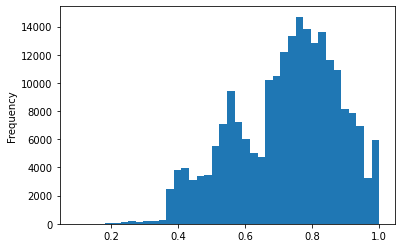

In [114]:
'''Selection based on the quality of the alignment.'''
seed_num = medoids_idx[0]
dtw_pairwise_matrix = virtual_rgs[seed_num].dtw.dtw_coverages
seeds_df['sel6'] = False

if len(medoids_idx)>1:
    for seed_num in medoids_idx[1:]:
        dtw_pairwise_matrix = pd.concat([dtw_pairwise_matrix, virtual_rgs[seed_num].dtw.dtw_coverages],axis=1)
    # Start hierarchial clustering and the selection. Set cluster number to 2.
    # https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
    cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
    label = cluster.fit_predict(dtw_pairwise_matrix)

    # Select the major cluster in both of query side and template side. Note the matrix is not symmetry.
    (uniq, freq) = np.unique(label,return_counts=True)
    major_seed_num = dtw_pairwise_matrix.index[label == uniq[np.argmax(np.asarray(freq))]] # Extract the major cluster

    seeds_df.loc[major_seed_num,'sel6']=True
else:
    thresh = threshold_otsu(dtw_pairwise_matrix)
    print(thresh)
    # thresh = 0.4
    dtw_pairwise_matrix.plot.hist(bins=40)
    selected_seed_num = dtw_pairwise_matrix[dtw_pairwise_matrix>=thresh].index
    seeds_df.loc[selected_seed_num,'sel6'] = True

1.187554531168841


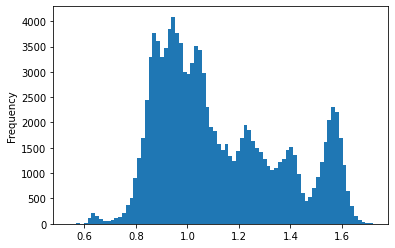

In [88]:
'''Selection based on the mutual information of the alignment.'''
seed_choice = seeds_df.index[seeds_df.iloc[:,3:].all(axis=1)].tolist()

# Exclude the virtual fibers with low mutual information combination.
seed_num = medoids_idx[0]
dtw_mi_matrix = virtual_rgs[seed_num].dtw.mutual_information
#selection_df['sel7'] = False

if len(medoids_idx)>1:
    for seed_num in medoids_idx[1:]:
        dtw_mi_matrix = pd.concat([dtw_mi_matrix, virtual_rgs[seed_num].dtw.mutual_information],axis=1)
    dtw_mi_matrix = dtw_mi_matrix[dtw_mi_matrix.index.isin(seed_choice)]# remove fibers filtered at the previous step

    # Start hierarchial clustering and the selection. Set cluster number to 2.
    cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
    label = cluster.fit_predict(dtw_mi_matrix)

    # Select the major cluster in both of query side and template side. Note the matrix is not symmetry.
    (uniq, freq) = np.unique(label,return_counts=True)
    major_seednum = dtw_mi_matrix.index[label == uniq[np.argmax(freq)]] # Extract the major cluster
    mi_selected_seeds = major_seednum.to_numpy()

#    selection_df.loc[major_seednum,'sel7'] = True

else:
    dtw_mi_matrix = dtw_mi_matrix[dtw_mi_matrix.index.isin(seed_choice)]
    thresh = threshold_otsu(dtw_mi_matrix)
    print(thresh)
    dtw_mi_matrix.plot.hist(bins=80)
    selected_seed_num = dtw_mi_matrix[dtw_mi_matrix>=thresh].index
#    selection_df.loc[selected_seed_num,'sel7'] = True

In [ ]:
# def extract_largest_cluster_index(coord):
#     """
#     input
#         coord: 2d array. coordinate in column.
#     return
#         index_array: index of points in the major cluster.
#     """
    
#     coord = coord.T.astype(int)
#     binary_array = np.zeros(coord.max(axis=1)+1)
#     binary_array[tuple(coord)] = 1
    
#     largest_object = extract_largest_object_from_binary(binary_array)
#     selected_coord = np.transpose(largest_object.nonzero()) # Get the largest objects. Extract index. Transpose to original orientation.

#     index_array = np.array([])
#     for point in tuple(selected_coord):
#         index = np.where((coord.T==point).all(axis=1))[0]
#         if index.size!=0:
#             index_array = np.append(index_array,index)
            
#     index_array = index_array.astype(int)

#     return index_array

In [90]:
# Remove seeds if the seeds are isolated from other seeds
seed_choice = seeds_df.index[seeds_df.iloc[:,3:7].all(axis=1)].tolist()

comp_coord = (seeds_df.loc[seed_choice,:].iloc[:,:3] / marching_step_size).astype(int)
idx = extract_largest_cluster_index(comp_coord.to_numpy())
seeds_df['sel7'] = False
seeds_df.loc[comp_coord.index[idx],'sel7'] = True

In [119]:
seeds_df.iloc[:,4:7]

sel4   sel5   sel6
0       False  False  False
1        True  False  False
2        True  False  False
3        True  False  False
4        True  False  False
...       ...    ...    ...
250466   True  False  False
250467   True  False  False
250468   True  False  False
250469   True  False  False
250470   True  False  False

[250471 rows x 3 columns]

In [127]:
# Export the selected seeds and flows if necessary
if True:
    seed_choice = seeds_df.index[seeds_df.iloc[:,4:7].all(axis=1)].tolist()

    flow_img = np.zeros_like(asma_downscale)
    for seed_num in seed_choice:
        virtual_rg = virtual_rgs[seed_num]
        flow_img = fill_value_in_range(flow_img,virtual_rg.trajectory.ode_solution.y)
#     imageio.mimwrite(os.path.join(io_directory,'predicted_flow2.tif'),flow_img)
    viewer=napari.Viewer()
    viewer.add_image(asma_downscale, contrast_limits=[0,20000], rgb=False, name='sma', colormap='magenta', blending='additive')
    viewer.add_image(flow_img, contrast_limits=[0,500], rgb=False, name='flow', colormap='green', blending='additive')

In [ ]:
'''inter fiber registration'''

In [ ]:
"""
1, project curved surface onto 2D (use PCA for simplicity. See how grid pattern changes in the projected space. I can always fine minimal unit.)
In my current case, building network is overkill. Just remove y coordinate.
2, Decide pixel unit. Reconstruct sparse 3D image.
This time, use marching cube size.
3, Make mask, make reference.
4, Do ants registration.
4D did not work well probably because too much constrain could not provide enough distortion in time dimension. Or, simply too sparse.
If dense, 4D will be large data set. Incapable of transformation.
"""

In [2]:
# from sklearn import manifold
# import ants

In [54]:
# %%time
# seed_choice = selection_df.index[selection_df.iloc[:,0:7].all(axis=1)].tolist()
# # https://benalexkeen.com/isomap-for-dimensionality-reduction-in-python/
# X0 = seeds_df.loc[seed_choice,:] / marching_step_size
# iso = manifold.Isomap(n_neighbors=20, n_components=2, n_jobs=num_cpus)
# iso.fit(X0)
# manifold_2Da = iso.transform(X0)

CPU times: user 22min 44s, sys: 2min 54s, total: 25min 39s
Wall time: 19min 29s


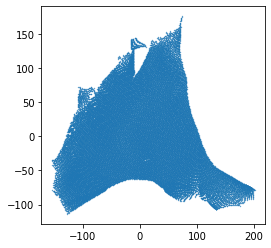

In [55]:
# fig = plt.figure(figsize=(4,4))
# fig.add_subplot(1,1,1)
# plt.scatter(manifold_2Da[:,0],manifold_2Da[:,1],s=0.1)

In [57]:
# # Translate uv corrdinate to make 3D image 
# translate_position = manifold_2Da - manifold_2Da.min(axis=0)[np.newaxis,:]
# translate_position_grid_df = pd.DataFrame(np.round_(translate_position,decimals=0).astype(int),index=X0.index,columns=['v','u']) # This may need optimization. Grid step is fixed to be 1.
# selected_uv_df = translate_position_grid_df[~translate_position_grid_df.duplicated(keep='first')] # Remove if duplicated. 
# duplication_table = generate_duplication_table(translate_position_grid_df) # Duplication correspondance table to retrieve removed seeds.
# print((duplication_table.index != duplication_table).sum()) # Print mean number of duplication. The smaller the better.
# print(duplication_table.size)

3406
40917


In [ ]:
'''
Strategy
- transform to uvd space.
- interpolation
- padding, save

I found the edge of uvt is less deformed. I think it is necessary to remove the edges using mutual information etc.
This edge effect may come from the fact that edge has shorter fibers. This speculation comes from the fact that interpolation couldn't prevent it (double confirmed).
If the mask is applied, it only degrades the situation.
But this maybe due to really misalinged
One of the soluion is to remove these edges after registration. This is not ideal solution...

- Mutual information of transformed fibers against transformed medoid.
'''

In [72]:
# # Make 3D image in uvt space
# uvt = np.zeros([time_end+1] + (selected_uv_df.max(axis=0)+1).to_list(),dtype=float) # Make zeros array to reconstruct the 3D image  
# for seed_num in selected_uv_df.index.tolist():
#     virtual_rg = virtual_rgs[seed_num]
#     u = selected_uv_df.loc[seed_num,'u']
#     v = selected_uv_df.loc[seed_num,'v']
#     uvt[:,v,u] = virtual_rg.trajectory.values_on_trajectory
#     uvt[~virtual_rg.trajectory.inloc,v,u] = 0
# uvt_std = np.repeat(virtual_rg_medoid.trajectory.values_on_trajectory[:,np.newaxis,np.newaxis],selected_uv_df['v'].max(axis=0)+1,axis=1)
# uvt_std = np.repeat(uvt_std,selected_uv_df['u'].max(axis=0)+1,axis=2)

In [73]:
# %%time
# # Interpolate the image section by section. This is to fill the blank voxels which was lost due to gridding.
# uvt_pad = np.copy(uvt)
# flag = 0
# for i in range(time_end+1):
#     uvt_section = uvt_pad[i,:,:]
#     nonzero_coord = np.argwhere(uvt_section!=0)
#     if nonzero_coord.size == 0:
#         uvt_pad[i,:,:] = uvt_pad[i-1,:,:] # wrap if i == 0
#         if flag==1:
#             break
#         else:
#             continue
#     flag = 1
#     zero_coord = np.argwhere(uvt_section==0)
#     val = interpolate.griddata(nonzero_coord,uvt_section[tuple(nonzero_coord.T)],xi=zero_coord,method='nearest') # nearest extrapolates while linear not.
#     uvt_pad[tuple(np.vstack([np.full_like(zero_coord.T[0,:],i),zero_coord.T]))] = val
# uvt_pad = uvt_pad[0:i,:,:] # Trim the image
# uvt_std = uvt_std[0:i,:,:]

CPU times: user 1min 55s, sys: 3.58 s, total: 1min 59s
Wall time: 1min 56s


In [234]:
# uvt_std = np.repeat(virtual_rg_medoid.trajectory.values_on_trajectory[:,np.newaxis,np.newaxis],selected_uv_df['v'].max(axis=0)+1+padding*2,axis=1)
# uvt_std = np.repeat(uvt_std,selected_uv_df['u'].max(axis=0)+1+padding*2,axis=2)
# uvt_std = np.pad(uvt_std,((padding,padding),(0,0),(0,0)),mode='constant',constant_values=0)
# uvt_std = uvt_std[0:i,:,:]

In [69]:
# Padding of the uvt image for border-unconfinded ANTs registration
padding = 20 # Default 50
uvt_pad = np.pad(uvt_pad,((padding,padding),(padding,padding),(padding,padding)),mode='constant',constant_values=0)
uvt_std = np.pad(uvt_std,((padding,padding),(padding,padding),(padding,padding)),mode='constant',constant_values=0)

In [243]:
# Make mask image
ants_io_directory = os.path.join(io_directory,'ants_reg','padding08')
uvt_pad_mask = np.pad((np.invert(uvt[0:i,:,:]==0.0)).astype(float),((padding,padding),(padding,padding),(padding,padding)),mode='constant',constant_values=0)
uvt_pad_mask_nii = os.path.join(ants_io_directory,'uvt_pad_mask.nii.gz')
uvt_pad_mask_ants = ants.from_numpy(uvt_pad_mask, spacing=[1.0,1.0,1.0])
ants.image_write(uvt_pad_mask_ants,uvt_pad_mask_nii)

# ants.image_write(ants.from_numpy(uvd.T, spacing=[1.0,1.0,1.0]),os.path.join(ants_io_directory,'uvd_original.nii.gz'))

In [244]:
#ants_io_directory = os.path.join(io_directory,'ants_reg','padding')
mov_nii = os.path.join(ants_io_directory,'uvt.nii.gz')
fix_nii = os.path.join(ants_io_directory,'uvt_std.nii.gz')
# mask_nii = os.path.join(ants_io_directory,'uvd_mask.nii.gz')

mov_ants = ants.from_numpy(uvt_pad.astype(float), spacing=[1.0,1.0,1.0]) # Transpose for better visibility in FIJI
fix_ants = ants.from_numpy(uvt_std.astype(float), spacing=[1.0,1.0,1.0])#[1.0,marching_step_size,marching_step_size])
# mask_ants = ants.from_numpy((np.invert(uvd==0)).astype(float).T, spacing=[1.0,1.0,1.0])

ants.image_write(mov_ants,mov_nii)
ants.image_write(fix_ants,fix_nii)
# ants.image_write(mask_ants,mask_nii)

transform_prefix = os.path.join(ants_io_directory,'F2M_')
forward_transform = os.path.join(ants_io_directory,'F2M_Warped.nii.gz')
inverse_transform = os.path.join(ants_io_directory,'F2M_InvWarped.nii.gz')

In [343]:
%%time
!export ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS=48
!antsRegistration --dimensionality 3 \
--initial-moving-transform [{fix_nii},{mov_nii},2] \
--interpolation Linear \
--use-histogram-matching 1 \
--float 1 \
--verbose 1 \
--output [{transform_prefix},{forward_transform},{inverse_transform}] \
--transform SyN[0.1,3.0,0.1] --metric CC[{fix_nii},{mov_nii},1,5] --convergence [10000x10000x0,1e-6,10] --shrink-factors 16x8x1 --smoothing-sigmas 2x1x0vox \
#--restrict-deformation 1x0x0

# -x {uvt_pad_mask_nii}
# Masking may not be necessary if interpolated.
# I am able to rewrite this with antspy https://antspy.readthedocs.io/en/latest/_modules/ants/registration/interface.html#registration
# Regularization SyN[0.1,3.0,0.1] fix the wobbly deformation shape while its affect on edge effect is not clear (maybe no effect). SyN[0.1,3.0,1.0] was too much restriction. 
# If "total" gradient regularizer = 1.0, the larger the "updated" regularizer, the smoother... Why?? Let it be 3.0 for now.

# Alternative parameter is 
# --transform SyN[0.1,3.0,0.0] --metric CC[{fix_nii},{mov_nii},1,5] --convergence [10000x10000x10000x0,1e-6,10] --shrink-factors 16x8x4x1 --smoothing-sigmas 2x1x1x0vox \
# --transform SyN[0.1,3.0,0.0] --metric MI[{fix_nii},{mov_nii},1,32,Regular,0.25] --convergence [10000x10000x0,1e-6,10] --shrink-factors 16x8x1 --smoothing-sigmas 2x1x0vox \

All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Image origin alignment using fixed image: /home/tmurakami/tmurakami03/lsfm_py/vessel/vessel_analysis/ants_reg/padding08/uvt_std.nii.gz and moving image: /home/tmurakami/tmurakami03/lsfm_py/vessel/vessel_analysis/ants_reg/padding08/uvt.nii.gz (type = Euler3DTransform)
  number of levels = 3
  fixed image: /home/tmurakami/tmurakami03/lsfm_py/vessel/vessel_analysis/ants_reg/padding08/uvt_std.nii.gz
  moving image: /home/tmurakami/tmurakami03/lsfm_py/vessel/vessel_analysis/ants_reg/padding08/uvt.nii.gz
Dimension = 3
Number of stages = 1
Use Histogram Matching true
Winsorize image intensities false
Lower quantile = 0
Upper quantile = 1
Stage 1 State
   Image metric = CC
     Fixed image = Image (0x33737e0)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 2
  Modified Time: 1630
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (non

In [346]:
displacement_field_ants = ants.image_read(os.path.join(ants_io_directory,'F2M_1InverseWarp.nii.gz')) # Use InverseWarp, not Warp.
displacement_field = ants.core.ants_image.ANTsImage.numpy(displacement_field_ants)[...,0]
# Remove padding
if padding !=0:
    displacement_field = displacement_field[padding:-padding,padding:-padding,padding:-padding]
if time_end+1-len(displacement_field) !=0:
    displacement_field = np.append(displacement_field,np.zeros((time_end+1-len(displacement_field),) + displacement_field.shape[1:]),axis=0)

In [345]:
# write aligned time information onto fiber, and export as image
flow_img = np.zeros_like(asma_downscale)
for seed_num in translate_position_grid_df.index.tolist():
    virtual_rg = virtual_rgs[seed_num]

    duplicated_seed_num = duplication_table.loc[seed_num]
    displacement = displacement_field[:,translate_position_grid_df.loc[duplicated_seed_num,'v'],translate_position_grid_df.loc[duplicated_seed_num,'u']]

    warp_pos = np.arange(displacement.size) + displacement
    warp_pos = warp_pos * virtual_rg.trajectory.inloc.astype(float)
    flow_img = fill_value_in_range(flow_img,virtual_rg.trajectory.ode_solution.y,warp_pos)
imageio.mimwrite(os.path.join(io_directory,'info4_flow_inverse4.tif'),flow_img)

In [ ]:
'''Transform the reference time to the referece distance'''
# Making medoid distance - deformed time correspondance table.
medoid_seed_num = medoids_idx[0]
medoid_distance = virtual_rg_medoid.trajectory.distance

duplicated_seed_num = duplication_table.loc[medoid_seed_num]
displacement = displacement_field[:,translate_position_grid_df.loc[duplicated_seed_num,'v'],translate_position_grid_df.loc[duplicated_seed_num,'u']]
displacement = np.pad(displacement,(0,time_end +1 - len(displacement_field)),mode='constant',constant_values=0)
medoid_warp_pos = np.arange(displacement.size) + displacement
f = interpolate.interp1d(medoid_warp_pos, medoid_distance, kind='cubic', fill_value='extrapolate')

for seed_num in translate_position_grid_df.index.tolist():
    virtual_rg = virtual_rgs[seed_num]

    duplicated_seed_num = duplication_table.loc[seed_num]
    displacement = displacement_field[:,translate_position_grid_df.loc[duplicated_seed_num,'v'],translate_position_grid_df.loc[duplicated_seed_num,'u']]
    displacement = np.pad(displacement,(0,time_end +1 - len(displacement_field)),mode='constant',constant_values=0)
    warp_pos = np.arange(displacement.size) + displacement
    virtual_rg.trajectory.warp_position = f(warp_pos)

In [416]:
%%time
'''normalize over the fibers (not along the layer)'''
dist_df = []

for seed_num in translate_position_grid_df.index.tolist():
    virtual_rg = virtual_rgs[seed_num]
    # Get the correspondant seed coordinate
    duplicated_seed_num = duplication_table.loc[seed_num]
    displacement = displacement_field[:,translate_position_grid_df.loc[duplicated_seed_num,'v'],translate_position_grid_df.loc[duplicated_seed_num,'u']]

    warp_pos = np.arange(displacement.size) + displacement
    traveled_distance = interpolate.griddata(warp_pos, virtual_rg.trajectory.distance, np.arange(displacement.size),method='cubic') # this does not extrapolate.
    dist = np.insert(np.diff(traveled_distance),0,0)
    dist_df.append(pd.Series(dist,name=seed_num))
dist_df = pd.DataFrame(dist_df)

CPU times: user 32.5 s, sys: 1.88 s, total: 34.4 s
Wall time: 33.7 s


In [438]:
normalized_dist_df = -np.subtract(dist_df,dist_df.mean(axis=0))
flow_img = np.zeros_like(asma_downscale)
for seed_num in normalized_dist_df.index.tolist():
    virtual_rg = virtual_rgs[seed_num]
    value = normalized_dist_df.loc[seed_num,:].to_numpy() * virtual_rg.trajectory.inloc.astype(float)
    flow_img = fill_value_in_range(flow_img,virtual_rg.trajectory.ode_solution.y,value)
imageio.mimwrite(os.path.join(io_directory,'info_dist.tif'),flow_img)

1.076939284250405


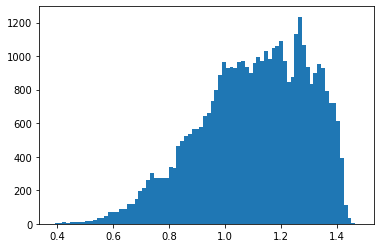

In [437]:
'''Visualize mutual information of the alignment.'''
# Quality control of fibers. Measure mutual information to the reference medoid fiber.

# Exclude the virtual fibers with low mutual information combination.
medoid_seed_num = medoids_idx[0]
template = virtual_rgs[medoid_seed_num].trajectory.values_on_trajectory # * virtual_rgs[medoid_seed_num].trajectory.inloc.astype(float)
f = interpolate.interp1d(np.arange(template.size), template, kind='cubic', fill_value='extrapolate')
mi = []

flow_img = np.zeros_like(asma_downscale)
for seed_num in translate_position_grid_df.index.tolist():
    virtual_rg = virtual_rgs[seed_num]

    duplicated_seed_num = duplication_table.loc[seed_num]
    displacement = displacement_field[:,translate_position_grid_df.loc[duplicated_seed_num,'v'],translate_position_grid_df.loc[duplicated_seed_num,'u']]
    warp_pos = np.arange(displacement.size) + displacement
    warped_medoid = f(warp_pos)[virtual_rg.trajectory.inloc]
    query = virtual_rg.trajectory.values_on_trajectory[virtual_rg.trajectory.inloc]
    mutual_info = mutual_information(query, warped_medoid, bins=10)
    flow_img = fill_value_in_range(flow_img,virtual_rg.trajectory.ode_solution.y,mutual_info)
    mi.append(mutual_info)
    
imageio.mimwrite(os.path.join(io_directory,'info_mi.tif'),flow_img)
mi = np.array(mi)

thresh = threshold_otsu(mi)
print(thresh)
_ = plt.hist(mi,bins=80)

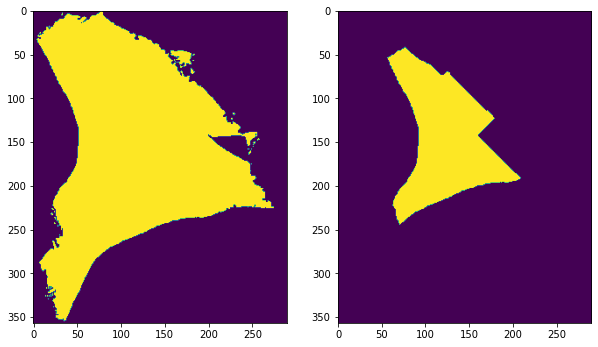

In [483]:
'''Erosion in UV space'''
#plt.scatter(translate_position_grid_df.loc[:,'v'],translate_position_grid_df.loc[:,'u'],s=0.5)
uv = np.zeros((selected_uv_df.max(axis=0)+1).to_list(),dtype=float)
#for seed_num in translate_position_grid_df.index.tolist():
#    u = translate_position_grid_df.loc[seed_num]
uv[tuple(selected_uv_df.to_numpy().T)] = 1.0
uv = ndi.binary_fill_holes(uv) # fill holes
uv = ndi.median_filter(uv,size=(3,3)) # smooth edges
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(uv)
iterations = 40 # the amount of dilation, unit = pixel
uv_erode = ndi.binary_erosion(uv,iterations=iterations)
fig.add_subplot(1,2,2)
plt.imshow(uv_erode)

In [484]:
seed_choice = translate_position_grid_df[uv_erode[tuple(translate_position_grid_df.to_numpy().T)]].index.tolist()

normalized_dist_df = -np.subtract(dist_df.loc[seed_choice,:],dist_df.loc[seed_choice,:].mean(axis=0))
flow_img = np.zeros_like(asma_downscale)
for seed_num in normalized_dist_df.index.tolist():
    virtual_rg = virtual_rgs[seed_num]
    value = normalized_dist_df.loc[seed_num,:].to_numpy() * virtual_rg.trajectory.inloc.astype(float)
    flow_img = fill_value_in_range(flow_img,virtual_rg.trajectory.ode_solution.y,value)
imageio.mimwrite(os.path.join(io_directory,'info_dist_choice.tif'),flow_img)

In [78]:
settings = {
    'pyramid_levels':6,
    'pyramid_stop_level': 3,
    'block_size':[16,16,16],
    'max_iteration_count':-1,
    'constraints_weight':1000.0,
    'regularization_weight':0.1,# default is 0.1
    'regularization_scale':1.0,
    'regularization_exponent':2.0,
    'image_slots': 
    [
        {
            # How to resample the images when building the resolution pyramid
            'resampler': 'gaussian',
            # Should the images be normalized prior to the registration
            'normalize': True,
            # Which cost function to use.
            'cost_function': 
            [
                {
                    'function':'ncc',
                    'weight':1.0,
                    'radius':7,
                    'window':'sphere'
                }
            ]
        }
    ]
}


In [76]:
# Padding of the uvt image for border-unconfinded ANTs registration
padding = 0 # Default 50
uvt_fix = np.pad(uvt_pad,((padding,padding),(0,0),(0,0)),mode='constant',constant_values=0)
uvt_mov = np.pad(uvt_std,((padding,padding),(0,0),(0,0)),mode='constant',constant_values=0)

In [79]:
%%time
fix_itk = sitk.GetImageFromArray(uvt_fix)
mov_itk = sitk.GetImageFromArray(uvt_mov)

deform_io_directory = os.path.join(io_directory,'pydeform_reg','trial04')

df = pydeformsitk.register(
    fix_itk,
    mov_itk,
#    fixed_mask = fixed_mask,
#    moving_mask = moving_mask,
    log=os.path.join(deform_io_directory,'deform.log'),
    log_level=pydeformsitk.LogLevel.Verbose,
    settings=settings,
    num_threads=72
)

mov_transformed = sitk.GetArrayFromImage(
    sitk.Resample(
        mov_itk,
        df,
        sitk.DisplacementFieldTransform(sitk.Cast(df, sitk.sitkVectorFloat64)),
        sitk.sitkLinear,
        useNearestNeighborExtrapolator=True
    )
)


fix_ants = ants.from_numpy(uvt_fix, spacing=[1.0,1.0,1.0])
ants.image_write(fix_ants,os.path.join(deform_io_directory,'uvt_pad.tif'))
mov_ants = ants.from_numpy(uvt_mov, spacing=[1.0,1.0,1.0])
ants.image_write(mov_ants,os.path.join(deform_io_directory,'uvt_std.tif'))
mov_transformed_ants = ants.from_numpy(mov_transformed.astype(float), spacing=[1.0,1.0,1.0]) 
ants.image_write(mov_transformed_ants,os.path.join(deform_io_directory,'pydeformed.tif'))

CPU times: user 3d 10h 11min 23s, sys: 15min 32s, total: 3d 10h 26min 56s
Wall time: 2h 57min 42s


<AxesSubplot:>

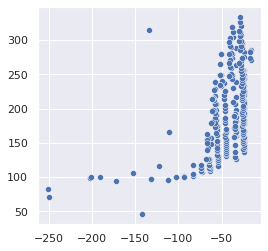

In [635]:
# '''Test of UV projection'''
# degree = 3
# poly = PolynomialFeatures(degree=degree)# I use 3 because 4 returned extreme value at the edge. Overfitting?
# sel_seeds_ = poly.fit_transform(sel_seeds)
# sel_seeds_normal = normalize(clf.predict(sel_seeds_),axis=1)
# u_vec = normalize(np.vstack([sel_seeds_normal[:,0], -sel_seeds_normal[:,1], np.zeros_like(sel_seeds_normal[:,1])]).T)
# v_vec = normalize(np.cross(sel_seeds_normal,u_vec))
# u_coord = np.sum(u_vec*sel_seeds, axis=1)#np.matmul(u_vec, sel_seeds.T)
# v_coord = np.sum(v_vec*sel_seeds, axis=1)
# sns.scatterplot(x=u_coord, y=v_coord)

In [542]:
#from sklearn.neighbors import KDTree
#from scipy import stats
#from scipy import spatial
# https://stackoverflow.com/questions/32424604/find-all-nearest-neighbors-within-a-specific-distance
# https://moonbooks.org/Articles/How-to-calculate-a-Gaussian-density-probability-function-at-a-given-point-in-python-/
# Does gaussian weighting make sense? Simple moving average may be better. (Please do this. I do not see the reason this is bad.)

In [551]:
# marching_step_size = 10
# point_tree = KDTree(np.array(seeds))
# point_tree.query_radius(np.array(seeds[0:2]), marching_step_size * 2, return_distance=True)

(array([array([55, 53,  0, 52,  1, 54,  4, 56]),
        array([53,  0,  1, 54,  4, 56,  5,  6, 57, 58,  2])], dtype=object),
 array([array([14.14213562, 14.14213562,  0.        , 17.32050808, 10.        ,
               14.14213562, 17.32050808, 14.14213562])                         ,
        array([17.32050808, 10.        ,  0.        , 10.        , 14.14213562,
               10.        , 14.14213562, 17.32050808, 14.14213562, 14.14213562,
               14.14213562])                                                   ],
       dtype=object))

1.0438341246045006
0.6655206192653196
CPU times: user 165 ms, sys: 28.4 ms, total: 194 ms
Wall time: 173 ms


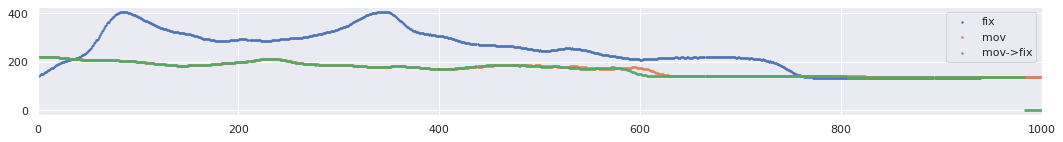

In [494]:
%%time
# Try mask version
# Test 500 and 1667. Those are two difficult to align.
# Easy example is Test 500 and 399. Those are two difficult to align.
seed_num1 = 500
seed_num2 = 1667

virtual_rg_fix = virtual_rgs[seed_num1]
virtual_rg_mov = virtual_rgs[seed_num2]

fix_itk = sitk.GetImageFromArray(virtual_rg_fix.trajectory.values_on_trajectory[np.newaxis,np.newaxis,:]) # The value without min-max normalization is used. The normalization is performed inside of pydeform.
mov_itk = sitk.GetImageFromArray(virtual_rg_mov.trajectory.values_on_trajectory[np.newaxis,np.newaxis,:]) # The new axes are added because pydeform only accepts 3D array.

fix_mask = sitk.GetImageFromArray(virtual_rg_fix.trajectory.inloc.astype(float)[np.newaxis,np.newaxis,:])
mov_mask = sitk.GetImageFromArray(virtual_rg_mov.trajectory.inloc.astype(float)[np.newaxis,np.newaxis,:])

df = pydeformsitk.register(
    fix_itk,
    mov_itk,
    fixed_mask = fix_mask,
    moving_mask = mov_mask,
    settings=settings,
    num_threads=1
)

mov_transformed = sitk.GetArrayFromImage(pydeformsitk.transform(mov_itk, df)).squeeze()
mov_mask_transformed = (sitk.GetArrayFromImage(pydeformsitk.transform(mov_mask, df)).squeeze() > 0)
displacement = sitk.GetArrayFromImage(df).squeeze()[:,0] # .squeeze()[:,0] is to reduce dimensions.
overlapped_mask = np.logical_and(virtual_rg_fix.trajectory.inloc,mov_mask_transformed)

# Check if overlapped mask makes sense.
plt.scatter(np.arange(virtual_rg_fix.trajectory.values_on_trajectory.size), virtual_rg_fix.trajectory.values_on_trajectory, s=2, label='fix')
plt.scatter(np.arange(virtual_rg_mov.trajectory.values_on_trajectory.size), virtual_rg_mov.trajectory.values_on_trajectory, s=2, label='mov')
# plt.scatter(np.arange(mov_mask_transformed.size), mov_mask_transformed, s=2, label='mov->fix')
plt.scatter(np.arange(mov_transformed.size), mov_transformed, s=2, label='mov->fix')
plt.xlim([virtual_rg_fix.trajectory.t_start,virtual_rg_fix.trajectory.t_end])
plt.legend()

'''calculate mutual information'''
s1 = virtual_rg_fix.trajectory.values_on_trajectory
s2 = mov_transformed
partial_mi = mutual_information(s1[overlapped_mask], s2[overlapped_mask], bins=10)
print(partial_mi)
full_mi = mutual_information(s1, s2, bins=10)
print(full_mi)

'''calculate the log distance (density) ratio'''
mov_time_warp = displacement + np.arange(displacement.size)
func_dist_interpolate = interpolate.interp1d(virtual_rg_mov.trajectory.ode_solution.t, virtual_rg_mov.trajectory.distance, kind='cubic', fill_value="extrapolate")
mov_aligned_distance = func_dist_interpolate(mov_time_warp)
fix_distance = virtual_rg_fix.trajectory.distance

mov_fix_dist_log_ratio = np.log2(np.diff(mov_aligned_distance)) - np.log2(np.diff(fix_distance))
mov_fix_dist_log_ratio[np.isneginf(mov_fix_dist_log_ratio)] = np.nan # Replace negative infinete caused by log0.
mov_fix_dist_log_ratio = np.insert(mov_fix_dist_log_ratio,0,mov_fix_dist_log_ratio[0]) # Set the size of the array consistent to time array by adding zero to the first position

# What I want as a return.
# (0. fixed seed)
# 1. alinged mov
# 2. aligned mask
# (3. fixed mask)
# 4. overlapped mask, overlapped mask ratio in the larger mask.
# 5. mutual information
# 6. mov_fix_dist_log_ratio

In [495]:
#plt.scatter(np.arange(mov_fix_dist_log_ratio.size),mov_fix_dist_log_ratio,s=2)
#plt.scatter(np.arange(virtual_rg_fix.trajectory.inloc.astype(float).size), virtual_rg_fix.trajectory.inloc.astype(float), s=2, label='mov->fix')
#plt.scatter(np.arange(mov_mask_transformed.size), mov_mask_transformed, s=2, label='mov->fix')


{'dtw_coverages': 1663    1.0
 Name: 1663, dtype: float64,
 'dtw_selection': False}

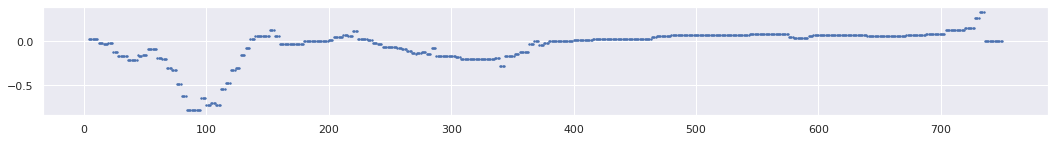

In [392]:
plt.scatter(np.arange(mov_fix_dist_log_ratio.size),mov_fix_dist_log_ratio,s=2)

CPU times: user 152 ms, sys: 3.43 ms, total: 155 ms
Wall time: 147 ms


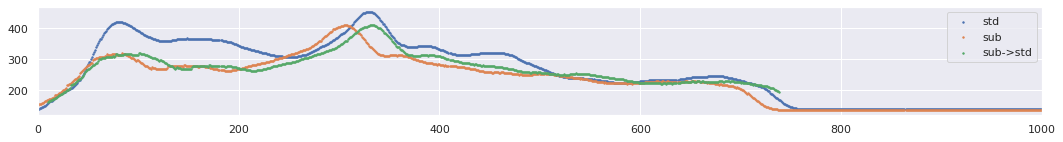

In [1487]:
%%time
# Use seed, 207 as DTW failed, 250 as successful, 399 as good example
#for seed_num, seed in enumerate(seeds):
for seed_num in [399]:#range(len(seeds)):
    virtual_rg = virtual_rgs[seed_num]
    if virtual_rg.dtw.dtw_selection:
        sub_val = virtual_rg.trajectory.values_on_trajectory[virtual_rg.trajectory.inloc]
        #inloc_outloc_count = count_inloc_outloc(virtual_rg.inloc.tolist(), inloc_outloc_count = []) # Always set empty list to inloc_outloc_count.
        
        # perform pydeform
        std_itk = sitk.GetImageFromArray(std_val[np.newaxis,np.newaxis,:]) # The value without min-max normalization is used. The normalization is performed inside of pydeform.
        sub_itk = sitk.GetImageFromArray(sub_val[np.newaxis,np.newaxis,:]) # The new axes are added because pydeform only accepts 3D array.
        df = pydeformsitk.register(
            std_itk,
            sub_itk,
            settings=settings,
            num_threads=1
        )

        #transformed = pydeformsitk.transform(sub_itk, df)
        displacement = sitk.GetArrayFromImage(df).squeeze()[:,0] # .squeeze()[:,0] is to reduce dimensions.
        sub_time = inloc_outloc_count[0] + displacement + np.arange(displacement.size) # the size of sub_time is equal to the size of std. Each element indicates time in the subject.
        if len(std_inloc_outloc_count) == 2:
            pad_sub_time = np.pad(sub_time,std_inloc_outloc_count[0],constant_values=np.nan)[:-std_inloc_outloc_count[0]]
        elif len(std_inloc_outloc_count) == 3:
            pad_sub_time = np.pad(sub_time,(std_inloc_outloc_count[0],std_inloc_outloc_count[2]),constant_values=np.nan) # fill the non-analyzed range with nan
        else:
            pass

        func_interpolate = interpolate.interp1d(virtual_rg.ode_solution.t, virtual_rg.values_on_trajectory, kind='cubic', fill_value="extrapolate")
        sub_aligned = func_interpolate(pad_sub_time).squeeze() # the size of sub_aligned is equal to the size of the argument
        sub_aligned[pad_sub_time<virtual_rg.trajectory.inloc_outloc_count[0]] = np.nan #1 
        sub_aligned[pad_sub_time>virtual_rg.trajectory.inloc_outloc_count[1]] = np.nan #2: #1 and #2 are to keep the time used for the registration.

        s1 = virtual_rg_std.values_on_trajectory[~np.isnan(sub_aligned)]
        s2 = sub_aligned[~np.isnan(sub_aligned)]
        mi = mutual_information(s1, s2, bins=10)
        plt.scatter(np.arange(virtual_rg_std.values_on_trajectory.size), virtual_rg_std.values_on_trajectory, s=2, label='std')
        plt.scatter(np.arange(virtual_rg.values_on_trajectory.size), virtual_rg.values_on_trajectory, s=2, label='sub')
        plt.scatter(np.arange(sub_aligned.size), sub_aligned, s=2, label='sub->std')
        plt.xlim([virtual_rg_std.t_start,virtual_rg_std.t_end])
        plt.legend()

        # Convert time to distance.
        func_dist_interpolate = interpolate.interp1d(virtual_rg.ode_solution.t, virtual_rg.distance, kind='cubic', fill_value="extrapolate")
        sub_aligned_distance = func_dist_interpolate(pad_sub_time).squeeze() # the size of sub_aligned_distance is equal to the size of the argument
        std_distance = virtual_rg_std.distance
        sub_std_dist_log_ratio = np.log2(np.diff(sub_aligned_distance)) - np.log2(np.diff(std_distance))
        sub_std_dist_log_ratio[np.isneginf(sub_std_dist_log_ratio)] = np.nan # Replace negative infinete caused by log0.
        sub_std_dist_log_ratio = np.insert(sub_std_dist_log_ratio,0,sub_std_dist_log_ratio[0]) # Set the size of the array consistent to time array.

        #print('successfully aligned.')

        analyzed_timerange_in_stdspace = ~np.isnan(sub_aligned)
        analysis_results[seed_num]['analyzed_timerange_in_stdspace'] = ~np.isnan(sub_aligned)
        analysis_results[seed_num]['aligned_values_in_stdspace'] = sub_aligned
        analysis_results[seed_num]['aligned_distance_in_stdspace'] = sub_aligned_distance
        analysis_results[seed_num]['distance_log_ratio_in_stdspace'] = sub_std_dist_log_ratio
        analysis_results[seed_num]['mutual_information'] = mi


In [1483]:
flow_img = np.zeros_like(asma_downscale)
for seed_num, w0 in enumerate(seeds):
    virtual_rg = virtual_rgs[seed_num]
    value = analysis_results[seed_num]['aligned_distance_in_stdspace']
    if value is None:
        continue
    else:
        flow_img = fill_value_in_range(flow_img,virtual_rg.ode_solution.y,value)
imageio.mimwrite(os.path.join(io_directory,'info_flow.tif'),flow_img)

In [1467]:
'''
%%time
#import lowess
# lowess takes 580 msec per one voxel. If 512 x 768 x 290, 765 days... This is already parallelized...
#v = np.hstack(vals)
#v1 = v[~np.isnan(v)]
#c = np.hstack(coord)[:,~np.isnan(v)]
#lowess.lowess(c[:,::10], v1[::10], np.array([[65,91,87,65,91,87],[91,200,245,91,200,245],[91,200,245,91,200,245]]), deg=3, l=24)
'''

CPU times: user 1min 1s, sys: 2min 41s, total: 3min 43s
Wall time: 3.7 s


array([  0.        , 173.89798633, 239.14072056,   0.        ,
       173.89798633, 239.14072056])

In [446]:
'''
def discretize(distance, value, increment=1, kind='cubic', **kwargs):
    f = interpolate.interp1d(distance, value, kind=kind, **kwargs)
    discretized_distance = np.arange(np.ceil(distance.min()), np.ceil(distance.max()), increment)
    discretized_value = f(discretized_distance)
    return discretized_distance, discretized_value
'''

In [554]:
%%time
# Discretize the distance. This is because DTW assumes the constant sampling.
increment = 1
std_dist, std_val = discretize(
    virtual_rg_std.distance[virtual_rg_std.inloc],
    virtual_rg_std.values_on_trajectory[virtual_rg_std.inloc],
    increment=increment
)
_, discretized_anatomy = discretize(
    virtual_rg_std.distance[virtual_rg_std.inloc],
    std_anatomy[virtual_rg_std.inloc],
    kind='nearest',
    increment=increment
)
discretized_anatomy = discretized_anatomy.astype(int)
std_norm_val = (std_val - std_val.min()) / (std_val.max() - std_val.min())

CPU times: user 3.25 ms, sys: 0 ns, total: 3.25 ms
Wall time: 2.07 ms


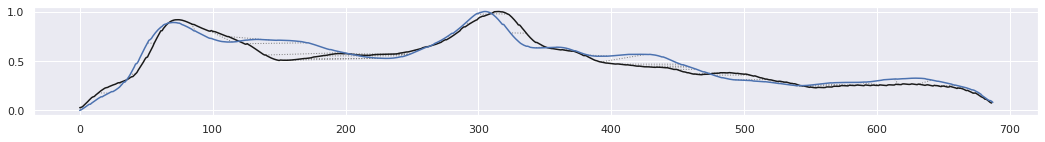

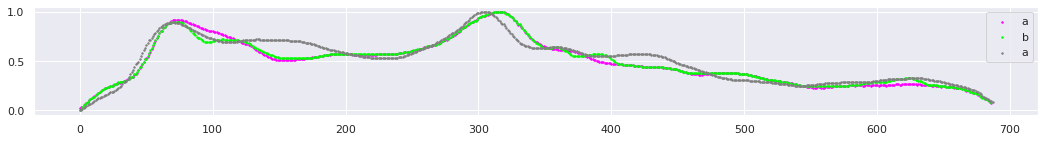

In [551]:
# partial dtw to determine the edge.
alignment = dtw.dtw(sub_norm_val, std_norm_val, step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=False) # One of open_end and open_begin should be false.
alignment.plot(type='twoway')

plt.scatter(np.arange(sub_norm_val.size),sub_norm_val,label='a', c='magenta', s=2) # The elements of np.diff(alignment.index1) are all equal to 1.
plt.scatter(np.arange(std_norm_val[alignment.index2].size),std_norm_val[alignment.index2],label='b', c='lime', s=2)
plt.scatter(np.arange(std_norm_val.size),std_norm_val,label='a', c='grey', s=2)
plt.legend()

In [653]:
'''To Do: include distance as a parameter. compute the distortion'''
seed_num = 550 #550 as a similar and 220 as a bad example
if np.diff(virtual_rgs[seed_num].inloc).sum() < 3: # Discard the seed where the flow is disrupted.
    # discretize the distance for the subject.
    sub_dist, sub_val = discretize(
        virtual_rgs[seed_num].distance[virtual_rgs[seed_num].inloc],
        virtual_rgs[seed_num].values_on_trajectory[virtual_rgs[seed_num].inloc],
        increment
    )
    sub_norm_val = (sub_val - std_val.min()) / (sub_val.max() - std_val.min()) # normalize using the values of standard. 
    
    # select the range of standard using hard DTW.
    alignment = dtw.dtw(sub_norm_val, std_norm_val, step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=False) 
    # trim the range of the standard, in case of open_end = True.
    trim_std_norm_val = std_norm_val[0:alignment.index2.max():increment]
    # trim the range of the subject, in case of open_end = True.
    trim_sub_norm_val = sub_norm_val[0:alignment.index1.max():increment]
    
    # soft dynamic time warping
    D = SquaredEuclidean(trim_std_norm_val.reshape(-1, 1), trim_sub_norm_val.reshape(-1, 1)) # TO DO: this is ignoring the distance.
    sdtw = SoftDTW(D, gamma=0.05) # soft-DTW discrepancy, approaches DTW as gamma -> 0. After normalization, around 0.05 seems decent.
    value = sdtw.compute() # discrepancy
    E = sdtw.grad()
    G = D.jacobian_product(E) # (I think G is like difference between transformed sub and std.)
    warp_idx = E.argmax(axis=0)
    print(value)
else:
    print('skip')

-56.228340280701886


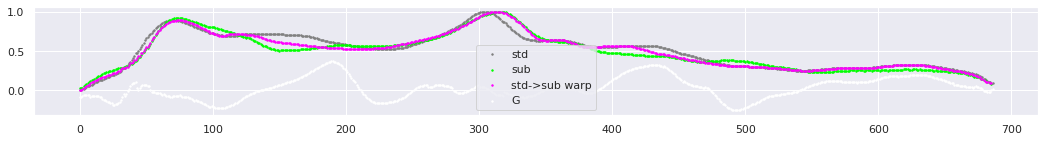

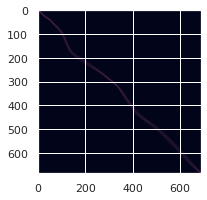

In [654]:
plt.scatter(np.arange(trim_std_norm_val.size), trim_std_norm_val, label='std', c='grey', s=2)
plt.scatter(np.arange(trim_sub_norm_val.size), trim_sub_norm_val, label='sub', c='lime', s=2)
plt.scatter(np.arange(trim_std_norm_val[warp_idx].size), trim_std_norm_val[warp_idx], label='std->sub warp',c='magenta', s=2)
plt.scatter(np.arange(G.size), G, label='G', c='white', s=2)
plt.legend()
# create figure and subplots
fig = plt.figure(figsize=(3,3))
fig.add_subplot(1, 1, 1)
plt.imshow(E)# / E.max())

In [320]:
'''
#np.diff(virtual_rg_std.inloc).sum()
counter = 0
for i in range(len(seeds)):
    if np.diff(virtual_rgs[i].inloc).sum() < 3: # Discard the seed where the flow is disrupted.
        pass#print(i)
    else:
        counter += 1
print(counter)
print(len(seeds))
'''

3
6
7
8
9
10
11
12
13
14
20
27
30
32
38
39
40
41
42
43
44
46
47
48
49
50
55
60
61
62
67
68
79
80
86
88
92
95
99
104
109
111
113
114
115
118
119
120
121
122
123
124
126
127
128
129
132
133
134
135
137
138
142
144
146
150
151
160
161
162
164
165
166
169
170
171
173
174
175
179
184
186
187
188
189
191
192
193
195
196
199
203
204
205
206
207
208
210
211
212
213
215
216
220
223
224
225
227
228
229
231
232
233
235
236
237
242
243
245
246
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
266
267
268
269
270
271
274
276
277
278
280
281
282
283
284
285
286
287
288
289
290
292
293
295
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
331
333
334
336
337
338
339
340
341
342
343
344
346
349
350
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
378
379
380
381
382
384
386
387
388
389
390
391
392
393
394
395
396
397
399
400
401
403
404
405
406
407
408
409


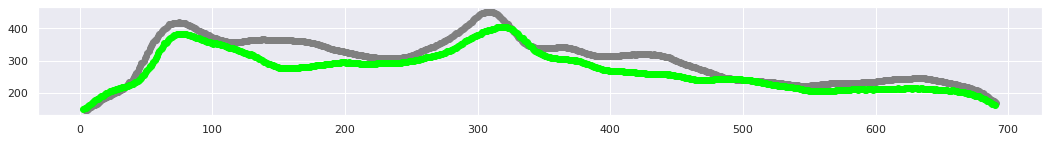

In [324]:
plt.scatter(std_dist, std_val, label='std', c='grey')
plt.scatter(sub_dist, sub_val, label='sub', c='lime')

In [ ]:
'''For intra fiber registration, use convoluted image not the centroids because centroids loses a lot of information.'''

In [ ]:
lsfm_sytox = io.imread(os.path.join(io_directory,'190819_HB_NeuN_SytoX_C1_isotropic.tif'))
lsfm_sytox_gauss = gaussian(lsfm_sytox,sigma=6,mode='nearest')

In [ ]:
lsfm_test = np.mean(np.mean(lsfm_sytox_gauss[100:100+window,:,:],axis=0)[:600,220:220+window],axis=1)
lsfm_test = (lsfm_test - lsfm_test.min()) / (lsfm_test.max() - lsfm_test.min())
plt.scatter(np.arange(lsfm_test.size),lsfm_test)

In [ ]:
D = SquaredEuclidean(lsfm_test.reshape(-1, 1), mov.reshape(-1, 1))
sdtw = SoftDTW(D, gamma=0.05) # soft-DTW discrepancy, approaches DTW as gamma -> 0. After normalization, around 0.05 seems decent.
value = sdtw.compute()
E = sdtw.grad()
G = D.jacobian_product(E)
warp_idx = E.argmax(axis=0)

In [ ]:
plt.scatter(np.arange(lsfm_test.size),lsfm_test,label='fix')
plt.scatter(np.arange(mov.size),mov,label='mov')
plt.scatter(np.arange(lsfm_test[warp_idx].size),lsfm_test[warp_idx],label='fix->mov warp')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(6,12))
fig.add_subplot(1, 1, 1)
plt.imshow(E / E.max())

In [ ]:
'''
%%time
# https://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html
# https://stackoverflow.com/questions/16909779/any-way-to-solve-a-system-of-coupled-differential-equations-in-python
flow_img = np.zeros_like(asma_downscale)
t0 = 0
t1 = 1000
for w0 in seeds:
    sol = solve_ivp(vectorfield, (t0,t1), y0=w0, t_eval=np.linspace(t0,t1,t1+1), args=(clf.coef_,poly.powers_))
    flow_img = fill_value_in_range(flow_img,sol.y)
    d = np.linalg.norm(sol.y.T - np.roll(sol.y.T,1,axis=0),2,axis=1) # d is the distance between t and t+1
    d[0] = 0
    cumsum_d = np.cumsum(d) # Cumlative distance. Distance from point t0 to point t.
'''

In [ ]:
'''Count the number of cells around virtual radial glial flows'''
'''The following code is under construction. Just for one representative flow.''''

In [39]:
t0 = 0
t1 = 1000
w0 = seeds[500]
print(w0)
sol = solve_ivp(vectorfield, (t0,t1), y0=w0, t_eval=np.linspace(t0,t1,t1+1), args=(clf.coef_,poly.powers_))

[90, 50, 120]


In [66]:
d = np.linalg.norm(sol.y.T - np.roll(sol.y.T,1,axis=0),2,axis=1) # Calculate length of trace from t0 to t1.
d[0] = 0
cumsum_d = np.cumsum(d)

CPU times: user 282 µs, sys: 929 µs, total: 1.21 ms
Wall time: 936 µs


In [500]:
# How to count the number of points within a given shape. In case of sphere, it looks easy.
#https://stackoverflow.com/questions/32424604/find-all-nearest-neighbors-within-a-specific-distance
# Use kernel looks like a top/bottom trimmed sphere.Easy to calculate, more meaningful than column.
# To do so, select the points within sphere. Calculate dot product of vector to the selected points and tangent vectors. If the dot product is in the range of c, that is the points to be chosen.

In [41]:
from scipy import spatial
# Use centroids of segmented cells. These are prepared by somewhere else.
centers = np.load('/home/tmurakami/tmurakami03/lsfm_py/vessel/vessel_analysis/stackC02_segment_center_resize.npy')

In [42]:
points = sol.y.T
points_ = poly.fit_transform(points)
tangent_vectors = clf.predict(points_)
norm_tangent_vectors = tangent_vectors / np.linalg.norm(tangent_vectors,axis=1)[:,np.newaxis]

In [43]:
radius = 20. # unit is voxel. All the following analysis assume isotropic voxel.
half_width = 5.
point_tree = spatial.KDTree(centers)
#point_tree.query_ball_point(point,radius)

In [44]:
cell_counts = np.zeros(cumsum_d.shape)
for num, p in enumerate(point_tree.query_ball_point(points,radius).tolist()):#This returns wobbly shape array.
    projected_distance = np.matmul(centers[p] - points[num,:],norm_tangent_vectors[num]) # Calculate dot product of the tangent vector and the vector from center to the point. 
    cell_counts[num] = (np.abs(projected_distance) <= half_width).sum()

[(0.0, 700.0)]

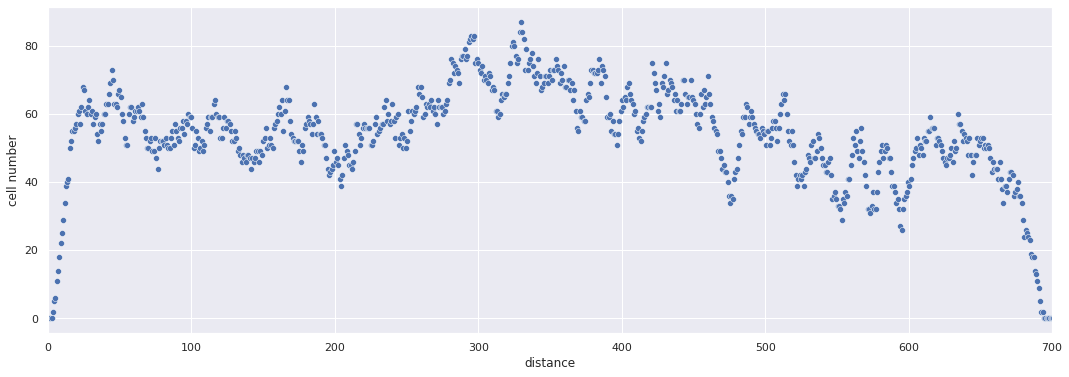

In [46]:
sns.set(rc={'figure.figsize':(18,6)})
dat = pd.DataFrame(np.stack([cumsum_d,cell_counts]).T,columns=['distance','cell number'])
ax = sns.scatterplot(data=dat,x='distance',y='cell number')
ax.set(xlim=(0, 700))

In [ ]:
'''Dynamit time warping (1D registration). There are couples of python packages. Choose one which support differentiable wapring.'''
# https://github.com/RealPolitiX/ptw
# https://github.com/pearsonkyle/Signal-Alignment
# https://github.com/pierre-rouanet/dtw
# https://github.com/slaypni/fastdtw/blob/master/fastdtw/fastdtw.py
'''
import dtw
alignment = dtw.dtw(mov,fix, dist_method='euclidean', keep_internals=True, step_pattern='asymmetric') # step_pattern='asymmetric' restrict the size not to be compressed/expanded.
#alignment.plot(type="twoway")

plt.scatter(np.arange(mov[alignment.index1].size),mov[alignment.index1],label='mov')
#plt.scatter(np.arange(mov.size),mov)
plt.scatter(np.arange(fix[alignment.index2].size),fix[alignment.index2],label='fix')
plt.scatter(np.arange(fix.size),fix)
plt.legend()
'''

